# setup

* I struggled with the installation witb GPU support, only able to fix from: https://gemini.google.com/app/f3ec74b59f92f56f

* This Gemini thread helpped me setup the dual CPU/GPU support: https://g.co/gemini/share/6c4f43639380

In [ ]:
import os
import torch
import time
import numpy as np
import pandas as pd
import math
from collections import Counter
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

path = '/content/drive/MyDrive/dev/'

Mounted at /content/drive/


In [ ]:
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")

CUDA version: 12.4


In [ ]:
if torch.cuda.is_available():
    !nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [ ]:
if torch.cuda.is_available():
    !nvidia-smi

Mon Jul 21 14:33:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Uninstall any existing version to ensure a clean slate
print("Uninstalling existing llama-cpp-python to ensure a clean install...")
!pip uninstall -y llama-cpp-python

Uninstalling existing llama-cpp-python to ensure a clean install...


In [ ]:
# Check if a CUDA-enabled GPU is available
if torch.cuda.is_available():
    print("GPU detected. Installing the CUDA-enabled version of llama-cpp-python ...")
    # This command will install the version compatible with the Colab GPU's CUDA version
    # The --no-cache-dir flag helps ensure a fresh download
    !pip install llama-cpp-python --extra-index-url https://abetlen.github.io/llama-cpp-python/whl/cu124 --no-cache-dir
else:
    print("No GPU detected. Installing the CPU-only version of llama-cpp-python ...")
    # This is the standard command for a CPU-only installation
    !pip install llama-cpp-python

GPU detected. Installing the CUDA-enabled version of llama-cpp-python ...
Looking in indexes: https://pypi.org/simple, https://abetlen.github.io/llama-cpp-python/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 MB 297.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 223.4 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.3.14-cp311-cp311-linux_x86_64.whl size=4299385 sha256=d77acc11a9630718d69e68a8ad754851c823a9c866a88d954da00ff8e0ff35d5
  Stored in directory: /tmp/pip-ephem-wheel-cache-1p2fl14o/wheels/3f/b6/cf/7315ec7b0149210d2d4447d9c3338b36d10e56a1ecddcd35c0
Successfully built llama-cpp-python


In [ ]:
# Verify the installation
try:
    from llama_cpp import Llama, LlamaGrammar
    print("llama-cpp-python imported successfully!")
except Exception as e:
    print(f"Error importing llama-cpp-python: {e}")

llama-cpp-python imported successfully!


# models

## n_gpu_layers

* This Notebook is just to test running various quantized TinyLlama models

* As a result, we will either use either n_gpu_layers = 0 (for running on CPU only) or n_gpu_layers = 33 (33 GPU layers)

* Refer to the Gemini explanation below in order to optimize n_gpu_layers when running the code for getting results

In [ ]:
# Check if a CUDA-enabled GPU is available
if torch.cuda.is_available():
    n_gpu_layers = 33 # GPU
else:
    n_gpu_layers = 0 # CPU

https://g.co/gemini/share/1de12d982e5f

That's an excellent and very important question for getting the best performance out of your models. Setting `n_gpu_layers` is the primary way you control the balance between CPU and GPU work.

Here’s a breakdown of what it means and how to find the optimal value for your specific system.

### What `n_gpu_layers` Does

This parameter determines how many layers of the neural network are "offloaded" to your GPU's VRAM.

  * **CPU:** Your computer's main processor. It has access to a large amount of slower system RAM.
  * **GPU:** Your graphics card. It has a smaller amount of very fast video RAM (VRAM) and is designed for the massive parallel calculations that LLMs require.

**The trade-off is simple:**

  * **More layers on the GPU (`n_gpu_layers` is high):** Inference (generating text) is much faster.
  * **Fewer layers on the GPU (`n_gpu_layers` is low):** More work is done on the slower CPU, but it uses less of your precious VRAM.

The "optimal" value is therefore: **The maximum number of layers you can fit into your GPU's VRAM without causing errors, while leaving a small buffer for your operating system.**

-----

### How to Find the Optimal Value: A Practical Guide

The best way to find the perfect number is through a bit of experimentation. Here is a simple, effective process:

#### Step 1: Know Your Total VRAM

First, check how much VRAM your GPU has.

  * **On Windows:** Open the Task Manager, go to the "Performance" tab, and click on your GPU. Look for "Dedicated GPU Memory".
  * **On Linux (with NVIDIA):** Open a terminal and run the command `nvidia-smi`. It will show you your GPU's total memory (e.g., `8192MiB`).

#### Step 2: Start High and Let the Model Tell You

You don't need to guess the number of layers. The easiest method is to set `n_gpu_layers` to a very high number. The `llama-cpp-python` library is smart enough to only offload as many layers as it can actually fit.

Modify your model loading code like this:

```python
from llama_cpp import Llama

llm = Llama(
    model_path="/path/to/your/model.gguf",
    # Set a very high number to offload as many layers as possible
    n_gpu_layers=999,  # <--- START WITH A HIGH NUMBER
    n_ctx=2048,
    verbose=True  # <--- Set to True to see the loading output
)
```

#### Step 3: Observe the Output

When you run this code, `llama.cpp` will print detailed information as it loads the model. Look for a line that looks like this:

```
llama_model_load_internal: offloaded 33 of 33 layers to GPU
```

or

```
llm_load_tensors: offloaded 33/33 layers to GPU
```

**That number is your answer.** In this example, the model has 33 layers, and all of them fit into your VRAM. Your optimal `n_gpu_layers` is **33**. You can then set `n_gpu_layers=33` in your code for future runs to be precise.

#### What If It Crashes?

If you set the number too high manually and your system becomes unstable or the program crashes with a "CUDA out of memory" error, it means you've exceeded your VRAM. In that case, simply lower the number and try again. For example, if `n_gpu_layers=33` crashes, try `30`, then `28`, until you find a stable number.

**Pro Tip:** Often, the last one or two layers of a model can be disproportionately large. If you find that offloading all layers works but your computer feels sluggish, try reducing the number by 1 or 2 (e.g., `n_gpu_layers=31` instead of `33`). This leaves a bit more VRAM for your operating system and can lead to a smoother overall experience with a negligible impact on performance.
That's an excellent and very practical question. Finding the optimal `n_gpu_layers` is the key to getting the best performance out of your hardware. Here’s a breakdown of what it means and how to find the best value for your specific setup.

### What `n_gpu_layers` Does

This parameter controls how many layers of the model are "offloaded" from your system's RAM to the GPU's dedicated, high-speed VRAM.

  * **`n_gpu_layers = 0`**: The entire model runs on your CPU. This is the slowest option but uses the least VRAM.
  * **`n_gpu_layers > 0`**: The specified number of layers are moved to the GPU. Since GPUs are massively parallel, they can process these layers much faster than a CPU, leading to a significant speedup in generating tokens.
  * **The Goal**: Offload as many layers as possible to the GPU without running out of VRAM.

### The Trade-Off: Speed vs. VRAM

The main limiting factor is your GPU's VRAM capacity. Each layer you offload consumes a chunk of VRAM. If you try to offload more layers than your VRAM can hold, the program will crash with an out-of-memory error.

The performance gain is not linear. The bulk of the computation happens in the middle layers. Offloading the first few layers gives a huge speed boost. Continuing to offload more layers gives diminishing returns, but is still faster.

### How to Find the Optimal Value: A Simple Experiment

The best way to find the ideal number is to test it empirically.

**Step 1: Start High**

The easiest way to start is to set `n_gpu_layers` to a very large number, like `-1` or `999`. The `llama-cpp-python` library is smart enough to know this means "offload as many layers as you possibly can".

```python
# Try to offload all layers
llm = Llama(
    model_path="path/to/your/model.gguf",
    n_gpu_layers=-1, # -1 means "all possible layers"
    verbose=True # Set to True to see the loading output
)
```

**Step 2: Watch the Output During Loading**

When the model loads with `verbose=True`, it will print detailed information. Look for a line that looks like this:

`llama_model_load_internal: offloaded 33 of 33 layers to GPU`

This tells you the maximum number of layers the model has (`33` in this case) and how many it successfully moved to the GPU. **The number it successfully offloaded is your practical maximum.**

**Step 3: Monitor Your VRAM**

While the model is loaded, open your system's GPU monitoring tool:

  * **NVIDIA GPUs**: Use `nvidia-smi` in your command line/terminal.
  * **AMD GPUs**: Use `radeontop` or the monitoring utility in your driver software.
  * **Windows**: The Performance tab in the Task Manager (select your GPU).

Check how much VRAM is being used. If it's very close to the maximum (e.g., 7.8GB / 8.0GB), you are at the limit.

**Step 4: Fine-Tune if Necessary**

  * **If it crashes with an "out of memory" error:** Your GPU can't handle all the layers. Reduce the number. If the model has 33 layers, try `n_gpu_layers=28`, then `25`, and so on, until it loads successfully.
  * **If it loads but VRAM is maxed out:** You've found a good value. You might want to reduce it by 1 or 2 layers (`n_gpu_layers=31` instead of `33`) just to leave a little breathing room for your operating system or other applications, which can prevent stuttering.

**In summary, the ideal `n_gpu_layers` is the highest number you can set without running out of VRAM.** The "set it to -1 and see what happens" method is the quickest way to find that number.


## tinyllama-1.1b-chat-v1.0.Q2_K.gguf

https://g.co/gemini/share/5e6bc8594d7d



In [ ]:
model_path = path+".models/tinyllama-1.1b-chat-v1.0.Q2_K.gguf"
generator_q2_k = Llama(
    model_path=model_path,
    chat_format="disabled",  # This prevents the model from wrapping input in chat templates
    n_ctx=2048,
    n_threads=2,
    n_gpu_layers=n_gpu_layers,
    logits_all=True,
    verbose=False,
)

llama_kv_cache_unified: LLAMA_SET_ROWS=0, using old ggml_cpy() method for backwards compatibility


In [ ]:
# Check the number of layers offloaded to the GPU
offloaded_layers = generator_q2_k.model_params.n_gpu_layers
print(f"✅ Successfully offloaded {offloaded_layers} layers to the GPU")

✅ Successfully offloaded 33 layers to the GPU


## tinyllama-1.1b-chat-v1.0.Q4_K_M.gguf

In [ ]:
model_path = path+".models/tinyllama-1.1b-chat-v1.0.Q4_K_M.gguf"
generator_q4_k_m = Llama(
    model_path=model_path,
    chat_format="disabled",  # This prevents the model from wrapping input in chat templates
    n_ctx=2048,
    n_threads=2,
    n_gpu_layers=n_gpu_layers,
    logits_all=True,
    verbose=False,
)

llama_kv_cache_unified: LLAMA_SET_ROWS=0, using old ggml_cpy() method for backwards compatibility


In [ ]:
# Check the number of layers offloaded to the GPU
offloaded_layers = generator_q4_k_m.model_params.n_gpu_layers
print(f"✅ Successfully offloaded {offloaded_layers} layers to the GPU")

✅ Successfully offloaded 33 layers to the GPU


## tinyllama-1.1b-chat-v1.0.Q6_K.gguf

In [ ]:
model_path = path+".models/tinyllama-1.1b-chat-v1.0.Q6_K.gguf"
generator_q6_k = Llama(
    model_path=model_path,
    chat_format="disabled",  # This prevents the model from wrapping input in chat templates
    n_ctx=2048,
    n_threads=2,
    n_gpu_layers=n_gpu_layers,
    logits_all=True,
    verbose=False,
)

llama_kv_cache_unified: LLAMA_SET_ROWS=0, using old ggml_cpy() method for backwards compatibility


In [ ]:
# Check the number of layers offloaded to the GPU
offloaded_layers = generator_q6_k.model_params.n_gpu_layers
print(f"✅ Successfully offloaded {offloaded_layers} layers to the GPU")

✅ Successfully offloaded 33 layers to the GPU


## tinyllama-1.1b-chat-v1.0.Q8_0.gguf

In [ ]:
model_path = path+".models/tinyllama-1.1b-chat-v1.0.Q8_0.gguf"
generator_q8_0 = Llama(
    model_path=model_path,
    chat_format="disabled",  # This prevents the model from wrapping input in chat templates
    n_ctx=2048,
    n_threads=2,
    n_gpu_layers=n_gpu_layers,
    logits_all=True,
    verbose=False,
)

llama_kv_cache_unified: LLAMA_SET_ROWS=0, using old ggml_cpy() method for backwards compatibility


In [ ]:
# Check the number of layers offloaded to the GPU
offloaded_layers = generator_q8_0.model_params.n_gpu_layers
print(f"✅ Successfully offloaded {offloaded_layers} layers to the GPU")

✅ Successfully offloaded 33 layers to the GPU


# experiments

## data

In [ ]:
# Load World M2 (wm2) and Bitcoin (btc) data
data_path = path+"sapheneia/github/sapheneia/data/"
btc  = pd.read_csv(data_path+"btc.csv")
wm2 = pd.read_csv(data_path+"wm2.csv")

In [ ]:
# Define the horizon for computation of changes in each time-series
# Given the use case of BTC and WM2 and that WM2 is given in weeks, the number of periods for horizon will be in weeks
changes_horizon = 1

In [ ]:
# Convert 'Date' column in btc to datetime objects
btc['Date'] = pd.to_datetime(btc['Date'])

# Convert 'observation_date' column in wm2 to datetime objects
wm2['observation_date'] = pd.to_datetime(wm2['observation_date'])

# Merge the two dataframes on the date columns
data = pd.merge(btc, wm2, left_on='Date', right_on='observation_date', how='inner')
data = data[['Date','Close','WM2NS']]
data = data.rename(columns={'Date': 'date','Close': 'btc','WM2NS': 'wm2'})

# Display the first few rows of the merged dataframe
display(data.head())

,date,btc,wm2
0,2014-04-21,495.16,11355.4
1,2014-04-28,441.92,11231.2
2,2014-05-05,430.87,11285.3
3,2014-05-12,438.21,11286.0
4,2014-05-19,443.90,11278.4


In [ ]:
# prompt: Using dataframe data: Compute a column for each btc and wm2 with the changes from one period to another. Change here is defined as log(x_2,x_1) where x_2 is the value of the column in a period ahead of the value x_1, where the number of periods between x_2 and x_1 is defined by a parameter horizon. Start with the first x_1 as the first period in the dataframe.

# Calculate the log change for 'btc'
data['btc_change'] = np.log(data['btc'] / data['btc'].shift(changes_horizon))

# Calculate the log change for 'wm2'
data['wm2_change'] = np.log(data['wm2'] / data['wm2'].shift(changes_horizon))

# prompt: Using dataframe data: Now given btc_change and wm2_change, first clean up rows NaN.

# Clean up rows with NaN values in 'btc_change' or 'wm2_change'
data.dropna(subset=['btc_change', 'wm2_change'], inplace=True)

# Round btc_change and wm2_change to 4 decimal places
data['btc_change'] = data['btc_change'].round(4)
data['wm2_change'] = data['wm2_change'].round(4)

# Sort by date to ensure calculations are in chronological order
data.sort_values(by='date', inplace=True)

# Display the first few rows of the merged dataframe
display(data.head())

,date,btc,wm2,btc_change,wm2_change
1,2014-04-28,441.92,11231.2,-0.1138,-0.0110
2,2014-05-05,430.87,11285.3,-0.0253,0.0048
3,2014-05-12,438.21,11286.0,0.0169,0.0001
4,2014-05-19,443.90,11278.4,0.0129,-0.0007
5,2014-05-26,582.01,11251.3,0.2709,-0.0024


In [ ]:
series_a = data['wm2'].tolist()
print(series_a)

[11231.2, 11285.3, 11286.0, 11278.4, 11251.3, 11345.1, 11363.4, 11380.3, 11290.0, 11343.1, 11426.4, 11423.3, 11393.9, 11364.3, 11461.6, 11431.4, 11442.5, 11383.5, 11442.4, 11495.9, 11516.0, 11436.8, 11451.4, 11556.2, 11556.7, 11570.3, 11525.4, 11574.6, 11621.4, 11643.2, 11580.5, 11668.9, 11725.5, 11765.8, 11784.7, 11799.9, 11830.1, 11807.0, 11762.9, 11687.2, 11788.6, 11822.0, 11864.8, 11850.4, 11927.6, 11956.1, 11988.2, 11933.3, 11970.5, 12122.2, 12100.8, 12043.8, 11862.5, 11907.6, 11914.4, 11928.6, 11882.7, 11941.8, 11980.2, 11996.0, 11940.3, 11958.2, 12091.4, 12045.8, 12010.7, 11960.7, 12045.2, 12073.7, 12107.6, 12051.8, 12087.0, 12170.8, 12196.8, 12142.7, 12084.0, 12180.8, 12170.7, 12177.6, 12143.2, 12260.4, 12303.0, 12334.7, 12281.7, 12316.0, 12380.4, 12417.7, 12472.4, 12464.1, 12496.9, 12552.2, 12508.6, 12423.3, 12466.0, 12478.4, 12545.5, 12532.0, 12559.9, 12658.1, 12681.9, 12684.6, 12735.0, 12825.3, 12839.9, 12850.9, 12693.8, 12710.3, 12731.5, 12748.3, 12701.8, 12689.6, 12802.7, 

In [ ]:
series_b = data['btc'].tolist()
print(series_b)

[441.92, 430.87, 438.21, 443.9, 582.01, 655.49, 644.35, 599.08, 591.17, 635.14, 613.6, 618.32, 625.13, 587.93, 592.77, 575.89, 462.18, 502.93, 477.19, 475.69, 477.71, 404.09, 376.77, 331.55, 387.32, 380.39, 350.09, 324.24, 367.15, 384.69, 378.85, 378.61, 364.95, 345.37, 330.84, 314.12, 274.84, 269.33, 215.87, 269.18, 238.86, 220.34, 235.83, 238.82, 273.75, 290.02, 290.41, 265.46, 246.79, 254.97, 223.59, 224.24, 228.96, 238.97, 241.81, 232.64, 237.41, 223.14, 228.57, 237.0, 247.46, 256.97, 269.08, 290.35, 277.68, 293.01, 281.58, 263.3, 257.13, 211.43, 229.47, 239.58, 229.91, 226.33, 238.87, 240.15, 245.35, 263.82, 285.15, 359.28, 380.22, 330.21, 322.12, 377.97, 394.28, 442.0, 437.59, 421.76, 433.32, 447.72, 384.4, 392.76, 372.18, 372.63, 401.07, 437.79, 436.21, 414.87, 414.31, 411.11, 422.21, 419.33, 421.43, 427.69, 461.73, 444.18, 460.44, 454.87, 443.69, 532.26, 583.58, 700.07, 733.97, 644.66, 675.16, 646.71, 670.38, 654.0, 607.0, 589.24, 566.95, 587.47, 574.23, 605.76, 607.98, 609.85,

In [ ]:
len(data)

576

## simulation #1

### experiment 1: single sequence, multi-step prediction

**25-07-14**
* This experiment has worked for single sequence BTC with a multi-step horizon
* One problem still not solved is that the if we set horizo=10, in step 7 of the prediction the model fails
* Because we will try single-step prediction going forward, this may be less of a problem
* Otherwise we need to further investigate why TinyLlama is behaving like this


In [ ]:
# --- Sigmoid and Inverse Sigmoid (Logit) Functions ---
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inverse_sigmoid(y):
    epsilon = 1e-9
    y = np.clip(y, epsilon, 1 - epsilon)
    return np.log(y / (1 - y))

In [ ]:
# Stricter GBNF Grammar for numbers between 0 and 1
# This forces the model to generate numbers like "0.1234"
# https://g.co/gemini/share/a6f8d45d23c5
gbnf_grammar_str = r'''
root   ::= sequence
sequence ::= number ("," number)*
number ::= "0" "." [0-9]+
'''

try:
    grammar = LlamaGrammar.from_string(gbnf_grammar_str)
    print("Strict grammar parsed successfully")
    print(grammar)
except Exception as e:
    print(f"Error parsing grammar: {e}")
    grammar = None

Strict grammar parsed successfully


In [ ]:
generator_model = generator_q8_0
grammar_obj = grammar

In [ ]:
horizon = 10
num_simulations = 100
temperature = 0.9
start_index = 550
lookback = 52

In [ ]:
# --- Sigmoid and Inverse Sigmoid (Logit) Functions (Unchanged) ---
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inverse_sigmoid(y):
    epsilon = 1e-9
    y = np.clip(y, epsilon, 1 - epsilon)
    return np.log(y / (1 - y))

In [ ]:
# --- NEW: Sigmoid and Inverse Sigmoid (Logit) Functions ---
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inverse_sigmoid(y):
    # Also known as the logit function
    # We add a small epsilon to avoid log(0) for values close to 0 or 1
    epsilon = 1e-9
    y = np.clip(y, epsilon, 1 - epsilon)
    return np.log(y / (1 - y))

In [ ]:
def simulate_future_trajectories(
    prompt_text,
    generator_model,
    grammar_obj,
    horizon=10,
    num_simulations=100,
    temperature=0.5
):
    """
    Runs N simulations to generate multiple full future trajectories.
    """

    # sequence = ['%.2f' % x for x in series]
    # prompt_text = ",".join(sequence)

    if not grammar_obj or not generator_model:
        return None

    all_trajectories = []
    print(f"\n--- Running {num_simulations} simulations for a horizon of {horizon} steps ---")

    # Use tqdm for a progress bar
    for _ in tqdm(range(num_simulations), desc="Simulating Trajectories"):
        response = generator_model(
            prompt_text,
            max_tokens=horizon * 5, # Generate enough tokens to get `horizon` numbers
            temperature=temperature,
            grammar=grammar_obj,
            stop=["\n"]
        )

        generated_text = response['choices'][0]['text']

        # Find all numbers in the generated string
        numbers_str = re.findall(r'-?\d+\.\d+|-?\d+', generated_text)

        # Convert to float and take only up to the desired horizon
        trajectory = [float(n) for n in numbers_str[:horizon]]

        # Ensure the trajectory has the correct length by padding if necessary
        while len(trajectory) < horizon:
            trajectory.append(trajectory[-1]) # Simple padding with the last value

        all_trajectories.append(trajectory)

    return np.array(all_trajectories)


In [ ]:
# series = (data['btc']/100.).tolist()
# series = series[400:(len(series)-horizon)]

historical_data = data['btc'].tolist()[-(lookback+horizon):]
historical_data = np.array(historical_data[:-horizon])
# historical_data = np.array(historical_data[400:(len(historical_data)-horizon)])
len(historical_data)

52

In [ ]:
from sklearn.preprocessing import StandardScaler

# --- 1. STANDARDIZE AND APPLY SIGMOID ---
historical_data_reshaped = historical_data.reshape(-1, 1)

# Fit a StandardScaler to the raw data
scaler = StandardScaler()
scaler.fit(historical_data_reshaped)

# Standardize the data (mean=0, std=1)
standardized_data = scaler.transform(historical_data_reshaped)

# Apply the sigmoid function to map to the [0, 1] range
normalized_data = sigmoid(standardized_data).flatten()

print(f"Original first value: {historical_data[0]:.2f}, Sigmoid-Normalized: {normalized_data[0]:.4f}")
print(f"Original last value:  {historical_data[-1]:.2f}, Sigmoid-Normalized: {normalized_data[-1]:.4f}")

Original first value: 68338.64, Sigmoid-Normalized: 0.3994
Original last value:  91536.97, Sigmoid-Normalized: 0.7499


In [ ]:
# --- 2. CREATE PROMPT WITH NORMALIZED DATA ---
# Format normalized data as strings with a few decimal places
prompt_data = ['%.4f' % x for x in normalized_data]
prompt = ",".join(prompt_data) + ","
prompt

'0.3994,0.4590,0.3880,0.4238,0.4205,0.4515,0.3261,0.3765,0.3319,0.3221,0.3188,0.4483,0.4158,0.4066,0.4177,0.3708,0.2825,0.3175,0.2381,0.3452,0.3874,0.3754,0.2080,0.2707,0.2720,0.3177,0.2680,0.2422,0.2562,0.3246,0.3242,0.3087,0.3646,0.3842,0.4243,0.3912,0.7146,0.7373,0.7676,0.7988,0.8138,0.8853,0.7872,0.7632,0.8577,0.7845,0.8566,0.8560,0.8510,0.8150,0.7981,0.7499,'

In [ ]:
# --- 3. RUN SIMULATION ---
# The model will now see and generate numbers between 0 and 1
normalized_trajectories = simulate_future_trajectories(
    prompt,
    generator_model,
    grammar_obj,
    horizon=horizon,
    num_simulations=num_simulations,
    temperature=temperature # A slightly lower temp can help with noisy data
)


--- Running 100 simulations for a horizon of 10 steps ---


Simulating Trajectories: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


In [ ]:
def plot_forecast_cloud(historical_data, forecast_trajectories):
    """
    Visualizes historical data and a cloud of forecasted trajectories,
    ensuring the forecast is connected to the historical data.
    """
    # --- Calculate Quantiles ---
    q10 = np.quantile(forecast_trajectories, 0.10, axis=0)
    q25 = np.quantile(forecast_trajectories, 0.25, axis=0)
    q50 = np.quantile(forecast_trajectories, 0.50, axis=0)
    q75 = np.quantile(forecast_trajectories, 0.75, axis=0)
    q90 = np.quantile(forecast_trajectories, 0.90, axis=0)

    # --- THE CRITICAL FIX IS HERE ---
    # Get the last point of the historical data to anchor the forecast
    last_hist_value = historical_data[-1]
    last_hist_time = len(historical_data) - 1

    # Prepend the last historical value to each forecast quantile series
    q10 = np.insert(q10, 0, last_hist_value)
    q25 = np.insert(q25, 0, last_hist_value)
    q50 = np.insert(q50, 0, last_hist_value)
    q75 = np.insert(q75, 0, last_hist_value)
    q90 = np.insert(q90, 0, last_hist_value)

    # Adjust the forecast time axis to start from the last historical point
    forecast_time = np.arange(last_hist_time, last_hist_time + len(q50))
    # --- END OF FIX ---

    # --- Create the Plot ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 8))

    # Define the historical time axis
    historical_time = np.arange(len(historical_data))

    # Plot historical data
    plt.plot(historical_time, historical_data, color='#005f73', label='Historical Data', linewidth=2.5, zorder=3)

    # Plot the median forecast (50th percentile)
    plt.plot(forecast_time, q50, color='#ae2012', linestyle='--', label='Median Forecast (50th)', linewidth=2, zorder=3)

    # Create the "Cloud" using fill_between
    plt.fill_between(forecast_time, q10, q90, color='#ee9b00', alpha=0.2, label='80% Prediction Interval', zorder=1)
    plt.fill_between(forecast_time, q25, q75, color='#ca6702', alpha=0.3, label='50% Prediction Interval', zorder=2)

    # --- Final Touches ---
    plt.title('Probabilistic Time Series Forecast', fontsize=20, weight='bold', pad=20)
    plt.xlabel('Time Steps', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

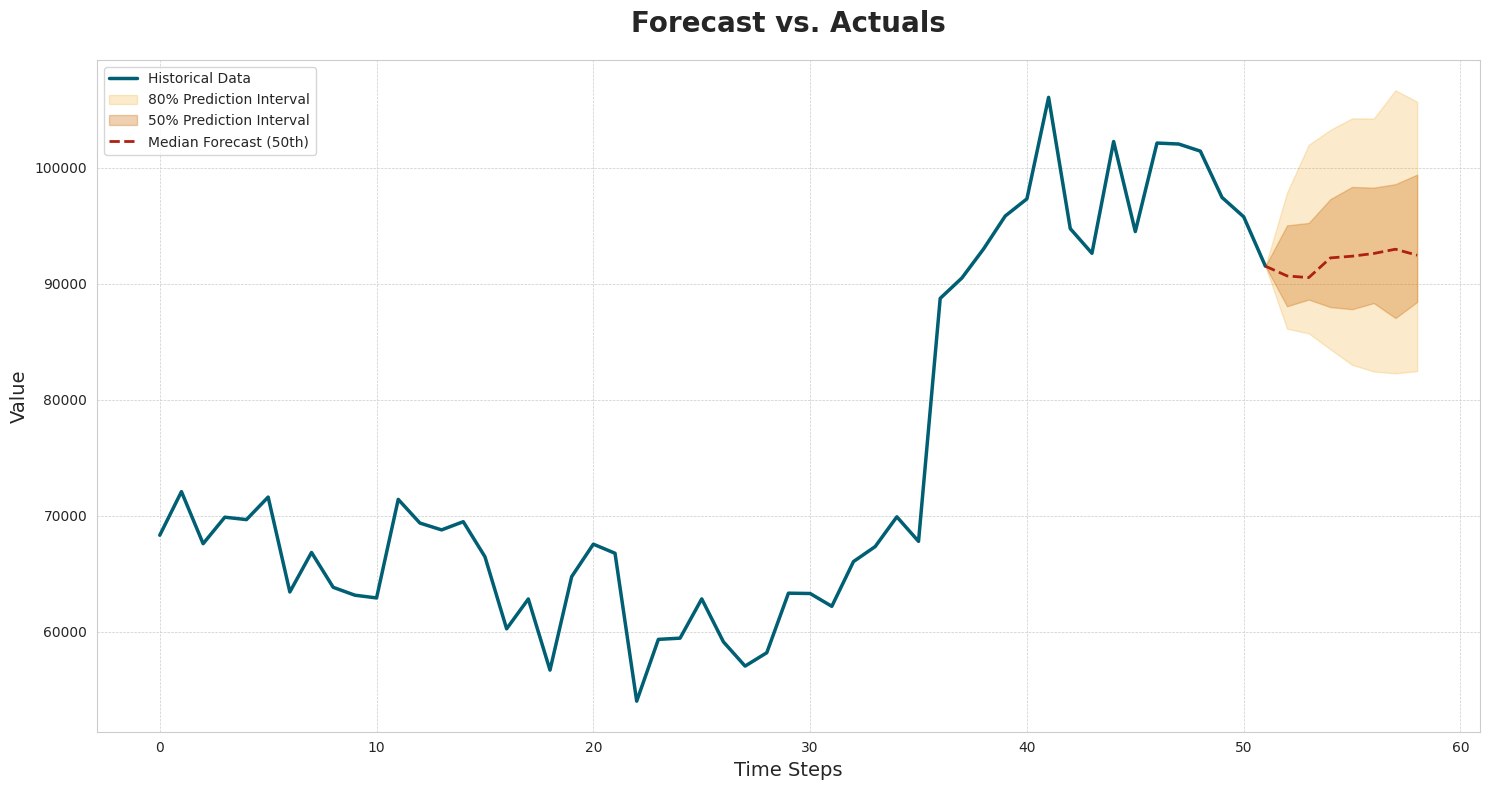

In [ ]:
trajectories = normalized_trajectories[:, :7]

# --- 4. INVERSE TRANSFORM THE RESULTS ---
if trajectories is not None and trajectories.size > 0:
    # Step 4a: Apply the inverse sigmoid (logit) function to get back to standardized scale
    inverse_sigmoid_trajectories = inverse_sigmoid(trajectories)

    # Step 4b: Use the scaler to inverse transform back to the original data scale
    rescaled_trajectories = scaler.inverse_transform(inverse_sigmoid_trajectories)

    # --- 5. PLOT THE FINAL, RECONSTRUCTED RESULTS ---
    plot_forecast_cloud(historical_data, rescaled_trajectories)
else:
    print("Simulation did not produce valid trajectories.")

In [ ]:
# --- EDITED PLOTTING FUNCTION ---
def plot_forecast_cloud(historical_data, forecast_trajectories, actual_future_data=None):
    """
    Visualizes historical data, a forecast cloud, and the actual future data for comparison.
    """
    if forecast_trajectories is None or forecast_trajectories.size == 0:
        print("No forecast data to plot.")
        return

    # Calculate quantiles for the forecast cloud
    q10 = np.quantile(forecast_trajectories, 0.10, axis=0)
    q25 = np.quantile(forecast_trajectories, 0.25, axis=0)
    q50 = np.quantile(forecast_trajectories, 0.50, axis=0)
    q75 = np.quantile(forecast_trajectories, 0.75, axis=0)
    q90 = np.quantile(forecast_trajectories, 0.90, axis=0)

    # Get the last point of the historical data to anchor the forecast
    last_hist_value = historical_data[-1]
    last_hist_time = len(historical_data) - 1

    # Prepend the last historical value to each forecast quantile series for a connected plot
    q10 = np.insert(q10, 0, last_hist_value)
    q25 = np.insert(q25, 0, last_hist_value)
    q50 = np.insert(q50, 0, last_hist_value)
    q75 = np.insert(q75, 0, last_hist_value)
    q90 = np.insert(q90, 0, last_hist_value)

    # --- Create the time axes ---
    historical_time = np.arange(len(historical_data))
    forecast_time = np.arange(last_hist_time, last_hist_time + len(q50))

    # --- Create the Plot ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 8))

    # Plot historical data
    plt.plot(historical_time, historical_data, color='#005f73', label='Historical Data', linewidth=2.5, zorder=3)

    # Plot the forecast cloud
    plt.fill_between(forecast_time, q10, q90, color='#ee9b00', alpha=0.2, label='80% Prediction Interval', zorder=1)
    plt.fill_between(forecast_time, q25, q75, color='#ca6702', alpha=0.3, label='50% Prediction Interval', zorder=2)

    # Plot the median forecast
    plt.plot(forecast_time, q50, color='#ae2012', linestyle='--', label='Median Forecast (50th)', linewidth=2, zorder=3)

    # --- NEW: Plot the actual future data for comparison ---
    if actual_future_data is not None and len(actual_future_data) > 0:
        # Create a time axis for the actuals that starts where the history ends
        actual_time = np.arange(last_hist_time, last_hist_time + len(actual_future_data) + 1)
        # Prepend the last historical point to connect the lines seamlessly
        actual_plot_data = np.insert(actual_future_data, 0, last_hist_value)

        plt.plot(actual_time, actual_plot_data, color='green', marker='o', markersize=5, linestyle='-', label='Actual Future Data', zorder=4)
    # --- END OF NEW CODE ---

    # --- Final Touches ---
    plt.title('Forecast vs. Actuals', fontsize=20, weight='bold', pad=20)
    plt.xlabel('Time Steps', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
actual_future_data = data['btc'].tolist()
actual_future_data = actual_future_data[-horizon:-3]
actual_future_data

[86158.953, 78561.617, 84025.117, 87520.477, 82539.523, 79143.063, 84575.75]

In [ ]:
historical_data

array([ 68338.641,  72095.859,  67609.438,  69892.258,  69686.367,
        71629.359,  63447.27 ,  66854.242,  63847.539,  63168.441,
        62932.289,  71430.227,  69386.828,  68799.602,  69505.57 ,
        66481.727,  60270.949,  62841.27 ,  56709.762,  64765.551,
        67567.711,  66782.781,  54031.82 ,  59360.891,  59464.41 ,
        62850.27 ,  59147.801,  57056.309,  58210.012,  63341.969,
        63314.809,  62209.84 ,  66068.25 ,  67358.141,  69925.828,
        67811.953,  88758.313,  90514.828,  93019.383,  95859.75 ,
        97338.344, 106089.203,  94771.641,  92646.211, 102282.203,
        94517.656, 102148.742, 102065.719, 101451.281,  97458.594,
        95790.313,  91536.969])

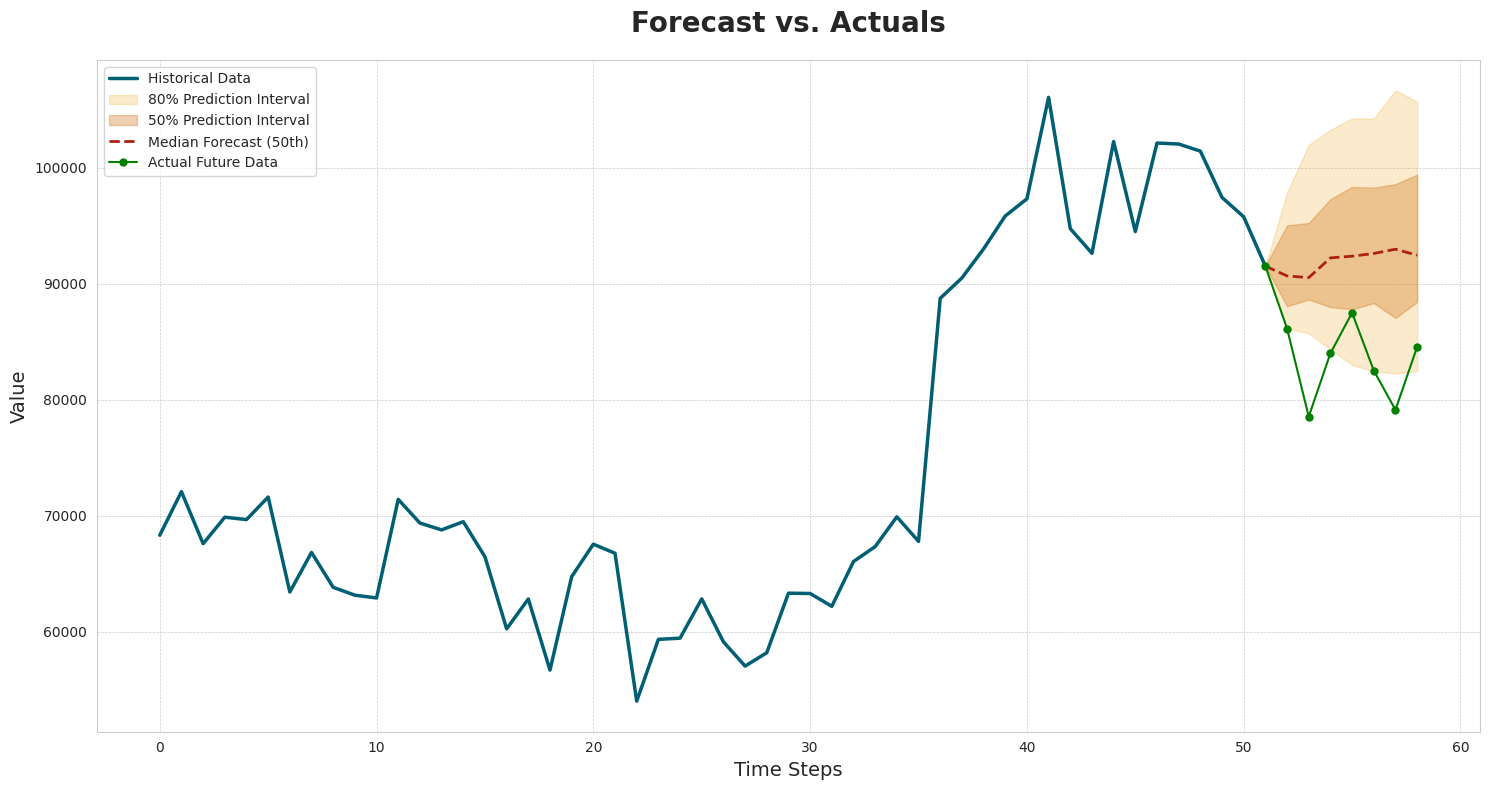

In [ ]:
trajectories = normalized_trajectories[:, :7]

# --- 4. INVERSE TRANSFORM THE RESULTS ---
if trajectories is not None and trajectories.size > 0:
    # Step 4a: Apply the inverse sigmoid (logit) function to get back to standardized scale
    inverse_sigmoid_trajectories = inverse_sigmoid(trajectories)

    # Step 4b: Use the scaler to inverse transform back to the original data scale
    rescaled_trajectories = scaler.inverse_transform(inverse_sigmoid_trajectories)

    # --- 5. PLOT THE FINAL, RECONSTRUCTED RESULTS ---
    plot_forecast_cloud(historical_data, rescaled_trajectories, actual_future_data)
else:
    print("Simulation did not produce valid trajectories.")

### experiment 2: single sequence, rolling prediction toward a horizon

In [ ]:
# --- Sigmoid and Inverse Sigmoid (Logit) Functions ---
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inverse_sigmoid(y):
    epsilon = 1e-9
    y = np.clip(y, epsilon, 1 - epsilon)
    return np.log(y / (1 - y))

In [ ]:
# --- NEW GRAMMAR DEFINITION ---
# This grammar forces the model to output only a sequence of digits,
# representing the numbers after the decimal point.
gbnf_grammar_str = r'''
root   ::= number
number ::= [0-9]+
'''
try:
    integer_grammar = LlamaGrammar.from_string(gbnf_grammar_str)
    print("Strict integer grammar parsed successfully.")
except Exception as e:
    print(f"Error parsing grammar: {e}")
    integer_grammar = None

Strict integer grammar parsed successfully.


In [ ]:
generator_model = generator_q8_0
grammar_obj = integer_grammar
num_simulations = 10
temperature = 0.9
horizon = 10
lookback = 52

In [ ]:
# historical_data = np.array(data['btc'].tolist()[-(lookback+horizon):])
# sequence_data = np.array(historical_data[:lookback])
# horizon_data = np.array(historical_data[-horizon:])
# print(sequence_data)
# print(horizon_data)
# len(sequence_data),len(horizon_data)

[ 68338.641  72095.859  67609.438  69892.258  69686.367  71629.359
  63447.27   66854.242  63847.539  63168.441  62932.289  71430.227
  69386.828  68799.602  69505.57   66481.727  60270.949  62841.27
  56709.762  64765.551  67567.711  66782.781  54031.82   59360.891
  59464.41   62850.27   59147.801  57056.309  58210.012  63341.969
  63314.809  62209.84   66068.25   67358.141  69925.828  67811.953
  88758.313  90514.828  93019.383  95859.75   97338.344 106089.203
  94771.641  92646.211 102282.203  94517.656 102148.742 102065.719
 101451.281  97458.594  95790.313  91536.969]
[86158.953 78561.617 84025.117 87520.477 82539.523 79143.063 84575.75
 87515.57  95035.063 94767.953]


(52, 10)

In [ ]:
# first_number = historical_data[0]
# start_index = lookback-1
# historical_data = np.array(data['btc'].tolist()[-(lookback+horizon):])
# logreturns_data = np.diff(np.log(historical_data))
# sequence_data = np.array(logreturns_data[:start_index])
# horizon_data = np.array(logreturns_data[-horizon:])
# print(sequence_data)
# print(horizon_data)
# len(sequence_data),len(horizon_data)

In [ ]:
historical_data = np.array(data['btc'].tolist())
first_number = historical_data[0]
logreturns_data = np.diff(np.log(historical_data))
sequence_data = np.array(logreturns_data[-(lookback+horizon):])
horizon_data = np.array(logreturns_data[-horizon:])
print(sequence_data)
print(horizon_data)
len(sequence_data),len(horizon_data)

[ 0.22593384  0.05352125 -0.06424902  0.0332073  -0.00295018  0.02750033
 -0.12129586  0.05230559 -0.04601672 -0.01069321 -0.00374545  0.12666176
 -0.02902408 -0.00849909  0.01020893 -0.04447977 -0.09807691  0.04176181
 -0.10266566  0.13282748  0.04235638 -0.01168494 -0.21187215  0.09406248
  0.00174237  0.05537725 -0.06071582 -0.03600076  0.02001871  0.08449076
 -0.00042888 -0.01760606  0.06017511  0.01933547  0.03741131 -0.0306966
  0.26917861  0.01959659  0.02729421  0.03007829  0.01530681  0.08608729
 -0.11281006 -0.02268216  0.09894763 -0.07894904  0.07764335 -0.0008131
 -0.00603822 -0.04015108 -0.01726605 -0.04541864 -0.06054904 -0.09231063
  0.06723252  0.04075702 -0.05859554 -0.04202011  0.06639044  0.03416914
  0.08242919 -0.0028146 ]
[-0.06054904 -0.09231063  0.06723252  0.04075702 -0.05859554 -0.04202011
  0.06639044  0.03416914  0.08242919 -0.0028146 ]


(62, 10)

In [ ]:
from sklearn.preprocessing import StandardScaler

# --- 1. STANDARDIZE AND APPLY SIGMOID ---
sequence_data_reshaped = sequence_data.reshape(-1, 1)

# Fit a StandardScaler to the raw data
scaler = StandardScaler()
scaler.fit(sequence_data_reshaped)

# Standardize the data (mean=0, std=1)
logreturns_data_reshaped = logreturns_data.reshape(-1, 1)
standardized_data = scaler.transform(logreturns_data_reshaped)

# Apply the sigmoid function to map to the [0, 1] range
normalized_data = sigmoid(standardized_data).flatten()

print(f"Original first value: {sequence_data[0]:.4f}, Sigmoid-Normalized: {normalized_data[0]:.4f}")
print(f"Original last value:  {sequence_data[-1]:.4f}, Sigmoid-Normalized: {normalized_data[-1]:.4f}")
print(normalized_data[:lookback])
print(normalized_data[-horizon:])

Original first value: 0.2259, Sigmoid-Normalized: 0.3908
Original last value:  -0.0028, Sigmoid-Normalized: 0.4620
[0.39076403 0.52583398 0.51291384 0.96763655 0.80634609 0.41629873
 0.25721275 0.42847946 0.69314127 0.36281535 0.49593163 0.50660124
 0.28671124 0.4976686  0.37980613 0.04886339 0.7271635  0.31065223
 0.46095512 0.48482912 0.09225177 0.26432364 0.14504662 0.86998834
 0.41342351 0.23285103 0.24776592 0.81703157 0.62001782 0.42212033
 0.46906894 0.35611373 0.30345575 0.33779337 0.31253426 0.13607179
 0.40652899 0.04808641 0.93973931 0.15900589 0.2382246  0.68255271
 0.51193473 0.83954454 0.65320772 0.47546138 0.2174183  0.25701583
 0.57621933 0.1395454  0.48050688 0.53855144]
[0.28884512 0.2119927  0.68056283 0.60179878 0.29407747 0.34058808
 0.67818377 0.58115562 0.72181132 0.4620309 ]


In [ ]:
# from sklearn.preprocessing import StandardScaler

# # --- 1. STANDARDIZE AND APPLY SIGMOID ---
# sequence_data_reshaped = historical_data.reshape(-1, 1)

# # Fit a StandardScaler to the raw data
# scaler = StandardScaler()
# scaler.fit(sequence_data_reshaped)

# # Standardize the data (mean=0, std=1)
# standardized_data = scaler.transform(sequence_data_reshaped)

# # Apply the sigmoid function to map to the [0, 1] range
# normalized_data = sigmoid(standardized_data).flatten()

# print(f"Original first value: {historical_data[0]:.2f}, Sigmoid-Normalized: {normalized_data[0]:.4f}")
# print(f"Original last value:  {historical_data[-1]:.2f}, Sigmoid-Normalized: {normalized_data[-1]:.4f}")
# print(normalized_data[:lookback])
# print(normalized_data[-horizon:])

In [ ]:
# # --- NEW: WINDOWED NORMALIZATION ---
# # Define the size of the recent window to use for scaling
# normalization_window_size = 30

# # Get the last N points of the history to fit the scaler
# normalization_window = historical_data[-normalization_window_size:]

# scaler = StandardScaler()
# # Fit the scaler ONLY on the recent window
# scaler.fit(normalization_window.reshape(-1, 1))

# # Now, transform the ENTIRE dataset using this window-fitted scaler
# standardized_data = scaler.transform(historical_data.reshape(-1, 1))
# normalized_data = sigmoid(standardized_data).flatten()
# # --- END OF NEW LOGIC ---

# print(f"Original first value: {historical_data[0]:.2f}, Sigmoid-Normalized: {normalized_data[0]:.4f}")
# print(f"Original last value:  {historical_data[-1]:.2f}, Sigmoid-Normalized: {normalized_data[-1]:.4f}")
# print(normalized_data[:lookback])
# print(normalized_data[-horizon:])

In [ ]:
# from sklearn.preprocessing import StandardScaler

# # --- 1. STANDARDIZE AND APPLY SIGMOID ---
# sequence_data_reshaped = historical_data.reshape(-1, 1)

# # Fit a StandardScaler to the raw data
# scaler = StandardScaler()
# scaler.fit(sequence_data_reshaped)

# # Standardize the data (mean=0, std=1)
# standardized_data = scaler.transform(sequence_data_reshaped)

# # Apply the sigmoid function to map to the [0, 1] range
# normalized_data = sigmoid(standardized_data).flatten()

# print(f"Original first value: {historical_data[0]:.2f}, Sigmoid-Normalized: {normalized_data[0]:.4f}")
# print(f"Original last value:  {historical_data[-1]:.2f}, Sigmoid-Normalized: {normalized_data[-1]:.4f}")
# print(normalized_data[:lookback])
# print(normalized_data[-horizon:])

In [ ]:
# --- 2. CREATE PROMPT WITH NORMALIZED DATA ---
# Format normalized data as strings with a few decimal places
prompt_data = ['%.4f' % x for x in normalized_data]
prompt = ",".join(prompt_data) + ","
prompt

'0.3908,0.5258,0.5129,0.9676,0.8063,0.4163,0.2572,0.4285,0.6931,0.3628,0.4959,0.5066,0.2867,0.4977,0.3798,0.0489,0.7272,0.3107,0.4610,0.4848,0.0923,0.2643,0.1450,0.8700,0.4134,0.2329,0.2478,0.8170,0.6200,0.4221,0.4691,0.3561,0.3035,0.3378,0.3125,0.1361,0.4065,0.0481,0.9397,0.1590,0.2382,0.6826,0.5119,0.8395,0.6532,0.4755,0.2174,0.2570,0.5762,0.1395,0.4805,0.5386,0.6081,0.5094,0.3504,0.5368,0.2850,0.5489,0.5876,0.6093,0.5923,0.6181,0.7050,0.3331,0.6414,0.3471,0.2717,0.3957,0.0658,0.7204,0.6091,0.3430,0.4209,0.6419,0.4884,0.5405,0.6955,0.7095,0.9469,0.6500,0.1251,0.3924,0.8763,0.6064,0.7968,0.4389,0.3558,0.5585,0.5765,0.1097,0.5408,0.3071,0.4750,0.6981,0.7351,0.4594,0.3173,0.4668,0.4462,0.5572,0.4491,0.4873,0.5189,0.7063,0.3502,0.5868,0.4320,0.3921,0.9042,0.7462,0.9042,0.6219,0.1420,0.6187,0.3376,0.5868,0.3926,0.2529,0.3773,0.3507,0.5855,0.3986,0.6405,0.4830,0.4811,0.4536,0.4980,0.5011,0.5743,0.5371,0.6923,0.5022,0.4673,0.6116,0.4584,0.5625,0.5727,0.5179,0.8257,0.8166,0.1539,0.2307,0.782

In [ ]:
# --- Core Rolling Forecast Simulation Function ---
def run_rolling_single_series_forecast(
    sequence_data,
    start_index,
    horizon,
    generator_model,
    grammar_obj,
    num_simulations=10,
    temperature=0.7,
    max_tokens=10
):
    """
    Performs an efficient, stateful rolling forecast for a single time series.
    At each step `t`, it simulates `t+1`, then uses the actual value at `t+1`
    to inform the prediction for `t+2`.
    """
    if not grammar_obj or not generator_model:
        return None

    # # 1. Normalize the entire dataset at once

    # # 2. Prepare initial context
    # generator_model.reset()
    # historical_normalized = sequence_data[:start_index]
    # prompt_data = ['%.4f' % x for x in historical_normalized]
    # initial_prompt = ",".join(prompt_data) + ","

    # --- NEW: Convert normalized floats (0.xxxx) to integer strings ("xxxx") ---
    # We multiply by 10000 and format as a four-digit integer string.
    int_data_str = ["%04d" % (x * 10000) for x in sequence_data]

    # 2. Prepare initial context using the new integer string format
    generator_model.reset()
    historical_int_strings = int_data_str[:start_index]
    initial_prompt = ",".join(historical_int_strings) + ","

    # "Warm up" the model's state (KV Cache) with the historical data
    # print(f"Warming up model with {len(historical_normalized)} historical data points...")
    print(f"Warming up model with {len(historical_int_strings)} historical data points...")
    print(f"Historical data points: {historical_int_strings}")
    initial_tokens = generator_model.tokenize(initial_prompt.encode("utf-8"), add_bos=True)
    print(f"Initial tokens: {initial_tokens}")

    n_ctx = generator_model.n_ctx()
    if len(initial_tokens) >= n_ctx:
        print(f"Error: Initial prompt ({len(initial_tokens)} tokens) exceeds context window ({n_ctx}).")
        return None

    generator_model.eval(initial_tokens)
    print("Model warmup complete.")

    # This will store the distributions for each future step
    all_distributions = []

    # 3. Main loop for the rolling forecast
    print(f"\n--- Running rolling forecast for a horizon of {horizon} steps ---")
    for t in tqdm(range(start_index, start_index + horizon), desc="Forecasting Steps"):
        if t >= len(sequence_data):
            break

        # Save the current state (which includes all history up to `t-1`)
        state = generator_model.save_state()

        # Run N simulations from this state to get the distribution for step `t`
        step_simulations = []
        for _ in range(num_simulations):
            generator_model.load_state(state) # Fast state restoration
            response = generator_model(
                "", # Empty prompt, context is in the state
                max_tokens=max_tokens,
                temperature=temperature,
                grammar=grammar_obj,
                stop=[","],
                top_p=0.95,
                top_k=50,
                repeat_penalty=1.1,
                seed=-1 # Use a random seed for each simulation
            )
            # try:
            #     step_simulations.append(float(response['choices'][0]['text']))
            # except (ValueError, IndexError):
            #     continue
            try:
                if response['choices'][0]['text']:
                    # --- NEW: Convert generated integer string back to a float ---
                    generated_int_str = response['choices'][0]['text']
                    # Reconstruct the "0.xxxx" format and convert to float
                    normalized_prediction = float(f"0.{generated_int_str}")
                    step_simulations.append(normalized_prediction)
                else:
                    step_simulations.append(np.nan)
            except (ValueError, IndexError):
                step_simulations.append(np.nan)
                continue

        valid_simulations = [s for s in step_simulations if not np.isnan(s)]
        all_distributions.append(valid_simulations)
        print(valid_simulations)

        # Update the model's state with the *actual* integer string value at step `t`
        update_text = int_data_str[t] + ","
        update_tokens = generator_model.tokenize(update_text.encode("utf-8"), add_bos=False)
        generator_model.eval(update_tokens)

        # all_distributions.append(step_simulations)
        # print(step_simulations)

        # # **Crucially, update the model's state with the *actual* value at step `t`**
        # # This prepares the model for the next prediction at `t+1`
        # update_text = '%.4f' % sequence_data[t] + ","
        # update_tokens = generator_model.tokenize(update_text.encode("utf-8"), add_bos=False)
        # generator_model.eval(update_tokens) # Incrementally update the state

    return all_distributions

In [ ]:
distributions = run_rolling_single_series_forecast(
    sequence_data=normalized_data,
    start_index=lookback,
    horizon=horizon,
    generator_model=generator_model,
    grammar_obj=grammar_obj,
    num_simulations=100,
    max_tokens=6,
    temperature=0.8
)

Warming up model with 52 historical data points...
Historical data points: ['3907', '5258', '5129', '9676', '8063', '4162', '2572', '4284', '6931', '3628', '4959', '5066', '2867', '4976', '3798', '0488', '7271', '3106', '4609', '4848', '0922', '2643', '1450', '8699', '4134', '2328', '2477', '8170', '6200', '4221', '4690', '3561', '3034', '3377', '3125', '1360', '4065', '0480', '9397', '1590', '2382', '6825', '5119', '8395', '6532', '4754', '2174', '2570', '5762', '1395', '4805', '5385']
Initial tokens: [1, 29871, 29941, 29929, 29900, 29955, 29892, 29945, 29906, 29945, 29947, 29892, 29945, 29896, 29906, 29929, 29892, 29929, 29953, 29955, 29953, 29892, 29947, 29900, 29953, 29941, 29892, 29946, 29896, 29953, 29906, 29892, 29906, 29945, 29955, 29906, 29892, 29946, 29906, 29947, 29946, 29892, 29953, 29929, 29941, 29896, 29892, 29941, 29953, 29906, 29947, 29892, 29946, 29929, 29945, 29929, 29892, 29945, 29900, 29953, 29953, 29892, 29906, 29947, 29953, 29955, 29892, 29946, 29929, 29955, 29953

Forecasting Steps:   0%|          | 0/10 [00:00<?, ?it/s]

[0.20218, 0.20146, 0.20173, 0.20181, 0.10493, 0.17536, 0.8157, 0.43809, 0.20171, 0.5288, 0.12345, 0.31664, 0.20151, 0.30002, 0.35302, 0.19962, 0.24693, 0.54709, 0.56982, 0.43641, 0.1403, 0.32609, 0.20143, 0.37418, 0.21041, 0.20142, 0.2018, 0.56789, 0.53207, 0.20158, 0.20176, 0.23741, 0.2017, 0.12041, 0.5282, 0.14955, 0.23456, 0.34567, 0.34954, 0.20141, 0.10855, 0.20151, 0.19843, 0.1, 0.10014, 0.365, 0.53089, 0.39513, 0.36512, 0.56789, 0.30125, 0.32716, 0.35497, 0.76543, 0.30008, 0.8336, 0.53609, 0.80193, 0.31719, 0.20163, 0.36532, 0.2016, 0.2015, 0.35461, 0.74145, 0.5648, 0.2008, 0.20184, 0.20173, 0.20182, 0.2019, 0.66666, 0.20139, 0.14233, 0.59451, 0.82755, 0.65066, 0.34567, 0.82373, 0.33333, 0.20193, 0.20168, 0.19826, 0.59763, 0.31824, 0.4925, 0.3815, 0.19974, 0.20091, 0.2015, 0.11429, 0.43243, 0.84103, 0.31625, 0.20078, 0.33486, 0.33333, 0.1987, 0.32059, 0.45678]


Forecasting Steps:  20%|██        | 2/10 [01:29<05:54, 44.27s/it]

[0.2019, 0.39284, 0.2381, 0.5, 0.5967, 0.16824, 0.10592, 0.89207, 0.44253, 0.7954, 0.4, 0.3249, 0.30005, 0.59498, 0.10574, 0.89023, 0.84322, 0.86574, 0.20201, 0.20192, 0.2018, 0.35869, 0.3037, 0.56589, 0.34851, 0.10467, 0.49638, 0.25327, 0.26087, 0.2019, 0.20168, 0.54983, 0.12345, 0.65417, 0.35864, 0.12345, 0.32143, 0.20173, 0.32497, 0.32031, 0.87887, 0.30142, 0.1, 0.20183, 0.10438, 0.44732, 0.50107, 0.19357, 0.79533, 0.4219, 0.44547, 0.12345, 0.5472, 0.56789, 0.20175, 0.10154, 0.57133, 0.16495, 0.23847, 0.20198, 0.42804, 0.19738, 0.34567, 0.21684, 0.53754, 0.58797, 0.50004, 0.23867, 0.24716, 0.12109, 0.42613, 0.3299, 0.2019, 0.59619, 0.20071, 0.5142, 0.20165, 0.20163, 0.39053, 0.20133, 0.20163, 0.10365, 0.43508, 0.32778, 0.10693, 0.58309, 0.23456, 0.57416, 0.2017, 0.10854, 0.20151, 0.17698, 0.67614, 0.12057, 0.20183, 0.18243, 0.54201, 0.20198, 0.20158, 0.20184]


Forecasting Steps:  30%|███       | 3/10 [02:11<05:03, 43.33s/it]

[0.20181, 0.20185, 0.20152, 0.20153, 0.59041, 0.10246, 0.34061, 0.21043, 0.38023, 0.20182, 0.20187, 0.53673, 0.59394, 0.40788, 0.2013, 0.51418, 0.33333, 0.2013, 0.36503, 0.50438, 0.13154, 0.83119, 0.2019, 0.80816, 0.42507, 0.67582, 0.20194, 0.20196, 0.20174, 0.14542, 0.42091, 0.45678, 0.20171, 0.16398, 0.542, 0.54634, 0.89526, 0.2019, 0.67198, 0.83509, 0.58368, 0.13208, 0.46705, 0.6197, 0.53629, 0.84072, 0.33333, 0.20141, 0.2017, 0.20183, 0.30186, 0.20164, 0.12345, 0.62312, 0.34456, 0.20122, 0.20171, 0.13808, 0.62714, 0.53201, 0.53, 0.71522, 0.3958, 0.54136, 0.3961, 0.39246, 0.37214, 0.15201, 0.19852, 0.45678, 0.31942, 0.3, 0.5, 0.21021, 0.5814, 0.48697, 0.53412, 0.39862, 0.10975, 0.51468, 0.2019, 0.20173, 0.33333, 0.2565, 0.51701, 0.8427, 0.17844, 0.30003, 0.12345, 0.19897, 0.30976, 0.20183, 0.81234, 0.20132, 0.43017, 0.5642, 0.10769, 0.3273, 0.2013, 0.32345]


Forecasting Steps:  40%|████      | 4/10 [02:53<04:17, 42.85s/it]

[0.14437, 0.20171, 0.2018, 0.58491, 0.10437, 0.38726, 0.13085, 0.28387, 0.52021, 0.51973, 0.58275, 0.33334, 0.20131, 0.40533, 0.20145, 0.54032, 0.32483, 0.32447, 0.30627, 0.20046, 0.19962, 0.4, 0.2018, 0.3158, 0.13209, 0.64358, 0.108, 0.1997, 0.34098, 0.15686, 0.6397, 0.32342, 0.8438, 0.38795, 0.12345, 0.20171, 0.12111, 0.10353, 0.2857, 0.5872, 0.20184, 0.52083, 0.11289, 0.30317, 0.73285, 0.25736, 0.58356, 0.20196, 0.39614, 0.20153, 0.10561, 0.86153, 0.3, 0.61474, 0.35313, 0.10274, 0.40391, 0.20197, 0.43379, 0.5, 0.21205, 0.50647, 0.28796, 0.45689, 0.33824, 0.33345, 0.19203, 0.53764, 0.33333, 0.16551, 0.1443, 0.20152, 0.51038, 0.33106, 0.20152, 0.52134, 0.12345, 0.41753, 0.32486, 0.67398, 0.89123, 0.20169, 0.17966, 0.43927, 0.20153, 0.31487, 0.28, 0.2017, 0.51923, 0.83784, 0.39067, 0.19876, 0.65287, 0.202, 0.84657, 0.56789, 0.2004, 0.57969, 0.20131, 0.33333]
[0.21361, 0.56948, 0.58303, 0.5131, 0.20183, 0.5018, 0.60889, 0.19843, 0.25, 0.48709, 0.20168, 0.75432, 0.56424, 0.46304, 0.30155

Forecasting Steps:  60%|██████    | 6/10 [04:17<02:49, 42.41s/it]

[0.10645, 0.30374, 0.89502, 0.32157, 0.3202, 0.72374, 0.20153, 0.17855, 0.59383, 0.35349, 0.11637, 0.24658, 0.34567, 0.61532, 0.29996, 0.20186, 0.80953, 0.24747, 0.16972, 0.20195, 0.58517, 0.74632, 0.12345, 0.50289, 0.30526, 0.66666, 0.56097, 0.50005, 0.11038, 0.20151, 0.59305, 0.3651, 0.23165, 0.53172, 0.14666, 0.39285, 0.70018, 0.89012, 0.20171, 0.3492, 0.54362, 0.52931, 0.80517, 0.2012, 0.10928, 0.32061, 0.2014, 0.20171, 0.5, 0.7624, 0.20183, 0.38184, 0.54831, 0.80211, 0.36045, 0.46852, 0.8879, 0.10636, 0.20159, 0.20156, 0.24726, 0.20181, 0.19939, 0.20185, 0.12345, 0.33574, 0.37947, 0.20129, 0.20152, 0.28695, 0.11111, 0.2018, 0.53386, 0.89635, 0.38974, 0.79459, 0.31489, 0.12345, 0.21069, 0.2016, 0.2013, 0.11008, 0.20174, 0.5152, 0.2018, 0.59612, 0.43901, 0.20179, 0.20143, 0.45678, 0.52017, 0.4, 0.20197, 0.19073, 0.2014, 0.20051, 0.20125, 0.19842, 0.20162, 0.46237]


Forecasting Steps:  70%|███████   | 7/10 [04:59<02:06, 42.26s/it]

[0.26191, 0.20186, 0.30261, 0.30729, 0.25, 0.16852, 0.5, 0.11011, 0.35471, 0.15, 0.21558, 0.33021, 0.24016, 0.21052, 0.36529, 0.1519, 0.23845, 0.36541, 0.30681, 0.7482, 0.51873, 0.20048, 0.57946, 0.31246, 0.54003, 0.20139, 0.30452, 0.12345, 0.33484, 0.15, 0.50691, 0.79156, 0.37546, 0.59419, 0.31243, 0.512, 0.52866, 0.10803, 0.5621, 0.15348, 0.59348, 0.31423, 0.50001, 0.34345, 0.42836, 0.20136, 0.5, 0.20183, 0.65275, 0.69852, 0.20018, 0.20173, 0.2017, 0.53243, 0.48657, 0.2436, 0.19968, 0.38067, 0.52647, 0.12345, 0.54621, 0.8243, 0.6497, 0.10973, 0.12345, 0.20187, 0.20152, 0.20163, 0.20184, 0.84201, 0.2016, 0.20185, 0.5, 0.11542, 0.84236, 0.20194, 0.34028, 0.20095, 0.2015, 0.20161, 0.58379, 0.30015, 0.51778, 0.24049, 0.12345, 0.8139, 0.10498, 0.20134, 0.31054, 0.30411, 0.11425, 0.2401, 0.20185, 0.54718, 0.20141, 0.30174, 0.46235, 0.2001, 0.3, 0.33074]


Forecasting Steps:  80%|████████  | 8/10 [05:41<01:24, 42.17s/it]

[0.36506, 0.5, 0.32807, 0.30085, 0.11234, 0.2018, 0.75833, 0.86478, 0.87021, 0.57843, 0.20178, 0.80001, 0.20191, 0.59824, 0.89034, 0.20161, 0.11369, 0.50423, 0.82857, 0.12345, 0.10238, 0.20196, 0.21534, 0.23395, 0.1549, 0.85467, 0.67006, 0.13908, 0.26002, 0.31406, 0.37158, 0.50036, 0.12345, 0.84897, 0.20152, 0.15504, 0.15097, 0.20133, 0.23963, 0.5, 0.21589, 0.1987, 0.5, 0.20141, 0.20183, 0.30005, 0.50037, 0.2163, 0.32345, 0.1534, 0.20192, 0.57581, 0.81215, 0.45678, 0.20213, 0.20152, 0.32, 0.5, 0.23397, 0.81095, 0.38507, 0.2018, 0.3, 0.12345, 0.89123, 0.5949, 0.3, 0.3985, 0.31042, 0.20151, 0.69527, 0.75206, 0.78901, 0.5449, 0.30417, 0.50012, 0.14667, 0.365, 0.20141, 0.35201, 0.54574, 0.30467, 0.20164, 0.2015, 0.20139, 0.32014, 0.20183, 0.66666, 0.39211, 0.31998, 0.19943, 0.10704, 0.17479, 0.2016, 0.20154, 0.19584, 0.30572, 0.20152, 0.25654, 0.82791]


Forecasting Steps:  90%|█████████ | 9/10 [06:23<00:42, 42.15s/it]

[0.15005, 0.43567, 0.20171, 0.20164, 0.34866, 0.3206, 0.72468, 0.77777, 0.50968, 0.2017, 0.52973, 0.1982, 0.45467, 0.19903, 0.2306, 0.10722, 0.33309, 0.37394, 0.20181, 0.20151, 0.12345, 0.20133, 0.33812, 0.12864, 0.3021, 0.10449, 0.13698, 0.20181, 0.69483, 0.20193, 0.20148, 0.2014, 0.39368, 0.30255, 0.2017, 0.20192, 0.10547, 0.88888, 0.31456, 0.66666, 0.20031, 0.5798, 0.60068, 0.14328, 0.40082, 0.36075, 0.3, 0.47517, 0.35008, 0.39108, 0.13859, 0.53671, 0.31011, 0.81034, 0.20195, 0.51366, 0.17446, 0.14032, 0.37211, 0.18324, 0.20049, 0.2015, 0.23017, 0.12345, 0.20162, 0.38137, 0.23954, 0.19962, 0.40152, 0.10427, 0.14068, 0.3, 0.2018, 0.2018, 0.20165, 0.50011, 0.24776, 0.1056, 0.3, 0.2015, 0.12008, 0.32201, 0.19806, 0.20176, 0.20143, 0.3, 0.20192, 0.14112, 0.2016, 0.20134, 0.31048, 0.23306, 0.82317, 0.14524, 0.20202, 0.20172, 0.78901, 0.36547, 0.11312, 0.10439]


Forecasting Steps: 100%|██████████| 10/10 [07:05<00:00, 42.59s/it]

[0.2015, 0.34567, 0.14705, 0.12345, 0.46263, 0.20181, 0.365, 0.56589, 0.165, 0.3, 0.16559, 0.17364, 0.32511, 0.51406, 0.11424, 0.23506, 0.33345, 0.34963, 0.37975, 0.1206, 0.47835, 0.13637, 0.12345, 0.48997, 0.61597, 0.36042, 0.20192, 0.58021, 0.80136, 0.54702, 0.19746, 0.20195, 0.64622, 0.30931, 0.20179, 0.20192, 0.12345, 0.73456, 0.31471, 0.10004, 0.12345, 0.12345, 0.24765, 0.30623, 0.51502, 0.13507, 0.30007, 0.30566, 0.19802, 0.24785, 0.20193, 0.84387, 0.35661, 0.51234, 0.39647, 0.41933, 0.1083, 0.1, 0.28701, 0.69043, 0.56378, 0.85453, 0.30917, 0.81376, 0.3187, 0.39984, 0.17756, 0.20132, 0.2014, 0.20136, 0.5822, 0.15074, 0.80216, 0.52416, 0.11384, 0.21054, 0.12345, 0.81234, 0.58004, 0.20163, 0.58123, 0.20143, 0.1997, 0.50003, 0.31, 0.54492, 0.20186, 0.87558, 0.12345, 0.30234, 0.39014, 0.56985, 0.33691, 0.12345, 0.34567, 0.11081, 0.10684, 0.42913, 0.2016, 0.34434]


In [ ]:
print(historical_data[-(lookback+horizon):])
print(historical_data[-(lookback+horizon):(-horizon)])
print(historical_data[-horizon:])
print(historical_data[-(horizon+1):-1])

[ 68338.641  72095.859  67609.438  69892.258  69686.367  71629.359
  63447.27   66854.242  63847.539  63168.441  62932.289  71430.227
  69386.828  68799.602  69505.57   66481.727  60270.949  62841.27
  56709.762  64765.551  67567.711  66782.781  54031.82   59360.891
  59464.41   62850.27   59147.801  57056.309  58210.012  63341.969
  63314.809  62209.84   66068.25   67358.141  69925.828  67811.953
  88758.313  90514.828  93019.383  95859.75   97338.344 106089.203
  94771.641  92646.211 102282.203  94517.656 102148.742 102065.719
 101451.281  97458.594  95790.313  91536.969  86158.953  78561.617
  84025.117  87520.477  82539.523  79143.063  84575.75   87515.57
  95035.063  94767.953]
[ 68338.641  72095.859  67609.438  69892.258  69686.367  71629.359
  63447.27   66854.242  63847.539  63168.441  62932.289  71430.227
  69386.828  68799.602  69505.57   66481.727  60270.949  62841.27
  56709.762  64765.551  67567.711  66782.781  54031.82   59360.891
  59464.41   62850.27   59147.801  57056.

In [ ]:
# Convert list of lists to a 2D numpy array for easier processing
horizon_trajectories = np.array(distributions)

# Inverse transform the results
inverse_horizon_trajectories = inverse_sigmoid(horizon_trajectories)
predictions_logreturn = scaler.inverse_transform(inverse_horizon_trajectories).T
# print(predictions_logreturn)

b = historical_data[-(horizon+1):-1].reshape(1, -1)
a = np.exp(predictions_logreturn)*b
print(b)
print(a)

predictions_data = a
#predictions_data = np.exp(np.cumsum(predictions_logreturn))

# print(horizon_trajectories)
# print(predictions_data)

[[91536.969 86158.953 78561.617 84025.117 87520.477 82539.523 79143.063
  84575.75  87515.57  95035.063]]
[[ 83081.67174421  78189.95410269  71292.23897486  73909.24918013
   79862.50893661  70680.06486972  73721.51156023  81768.57442087
   77248.51227115  86228.57943126]
 [ 83053.04646187  84061.03244647  71293.60379944  76246.54616614
   90229.5879783   78119.27692538  71821.60187614  85333.33365502
   86555.38389616  91282.96558953]
 [ 83063.78873072  79474.41435015  71282.33872834  76249.83137577
   90616.47107286  98241.1257281   74873.82388632  80744.54732676
   79413.87273833  83732.57566084]
 [ 83066.96982805  86930.71812802  71282.68027046  87049.38397698
   88661.9926666   78620.69452317  75001.39691945  79961.93723345
   79411.21074539  82437.16131747]
 [ 78287.61077534  89596.29202394  81531.79517781  71829.94207678
   79422.88775003  78582.59570504  73366.85444864  72762.15439129
   84145.89668571  94785.5640825 ]
 [ 81965.81828874  76853.01557809  67052.81769628  81831.04

In [ ]:
# --- Plotting Function (Unchanged) ---
def plot_forecast_cloud(historical_data, forecast_trajectories, actual_future_data=None):
    if forecast_trajectories is None or forecast_trajectories.size == 0:
        print("No forecast data to plot.")
        return

    q10 = np.quantile(forecast_trajectories, 0.10, axis=0)
    q25 = np.quantile(forecast_trajectories, 0.25, axis=0)
    q50 = np.quantile(forecast_trajectories, 0.50, axis=0)
    q75 = np.quantile(forecast_trajectories, 0.75, axis=0)
    q90 = np.quantile(forecast_trajectories, 0.90, axis=0)

    last_hist_value = historical_data[-1]
    last_hist_time = len(historical_data) - 1

    q10 = np.insert(q10, 0, last_hist_value)
    q25 = np.insert(q25, 0, last_hist_value)
    q50 = np.insert(q50, 0, last_hist_value)
    q75 = np.insert(q75, 0, last_hist_value)
    q90 = np.insert(q90, 0, last_hist_value)

    forecast_time = np.arange(last_hist_time, last_hist_time + len(q50))

    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 8))

    historical_time = np.arange(len(historical_data))
    plt.plot(historical_time, historical_data, color='#005f73', label='Historical Data', linewidth=2.5, zorder=3)
    plt.plot(forecast_time, q50, color='#ae2012', linestyle='--', label='Median Forecast (50th)', linewidth=2, zorder=3)
    plt.fill_between(forecast_time, q10, q90, color='#ee9b00', alpha=0.2, label='80% Prediction Interval', zorder=1)
    plt.fill_between(forecast_time, q25, q75, color='#ca6702', alpha=0.3, label='50% Prediction Interval', zorder=2)

    if actual_future_data is not None and len(actual_future_data) > 0:
        actual_time = np.arange(last_hist_time, last_hist_time + len(actual_future_data) + 1)
        actual_plot_data = np.insert(actual_future_data, 0, last_hist_value)
        plt.plot(actual_time, actual_plot_data, color='green', marker='o', markersize=5, linestyle='-', label='Actual Future Data', zorder=4)

    plt.title('Rolling Probabilistic Forecast vs. Actuals', fontsize=20, weight='bold', pad=20)
    plt.xlabel('Time Steps', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

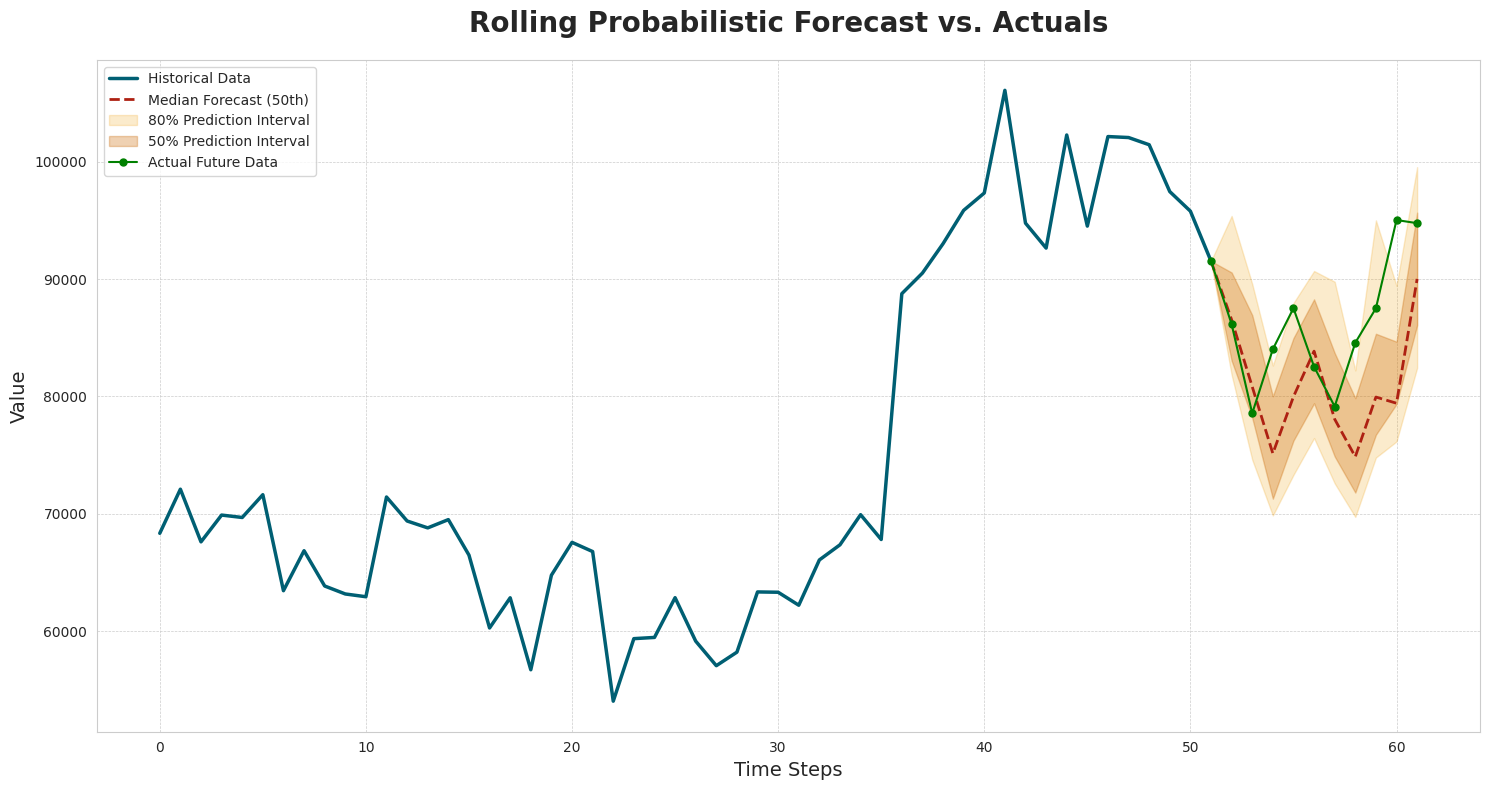

In [ ]:
plot_forecast_cloud(historical_data=np.array(historical_data[-(lookback+horizon):(-horizon)]),
                    forecast_trajectories=predictions_data,
                    actual_future_data=np.array(historical_data[-horizon:]))

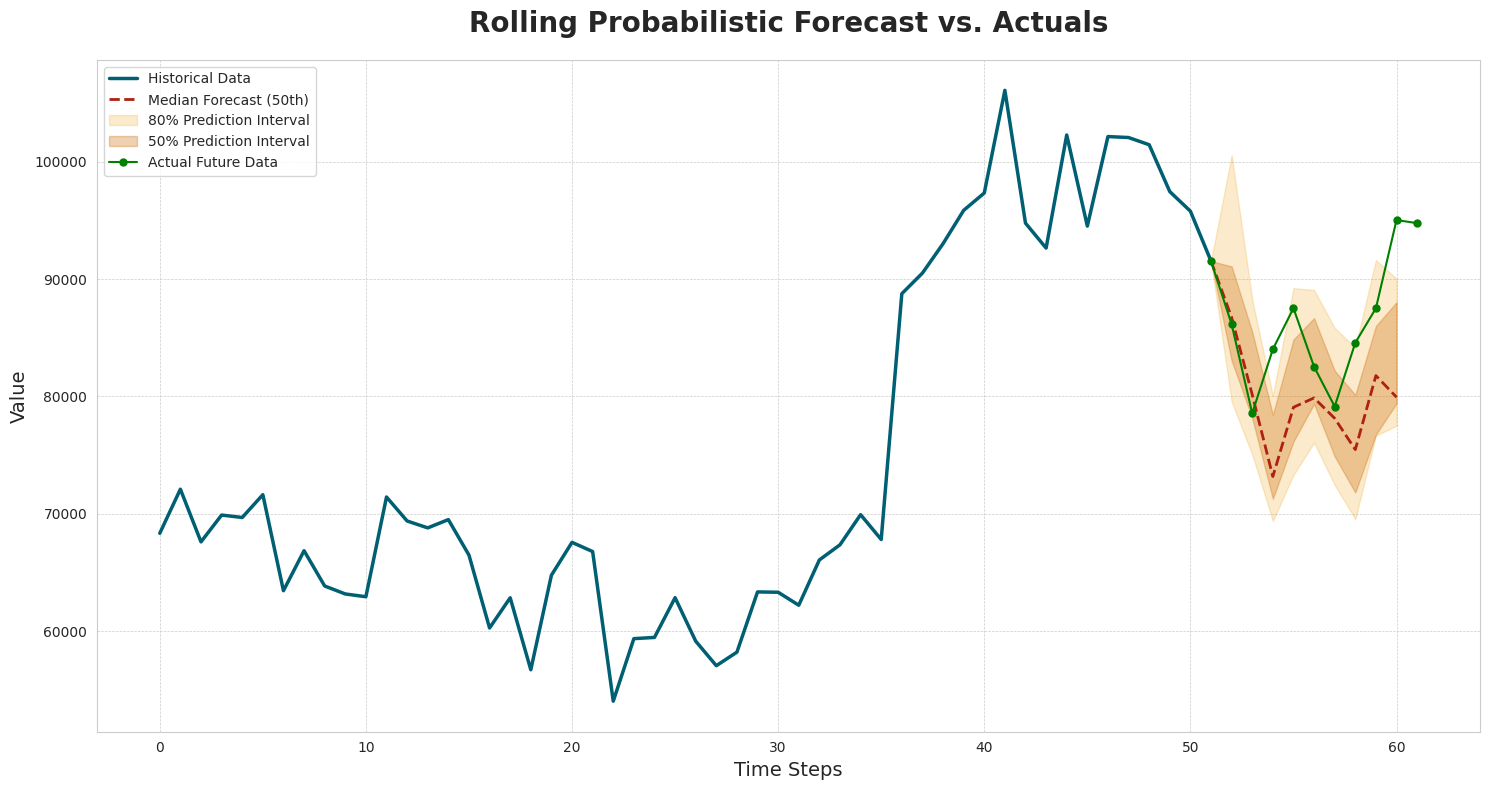

In [ ]:
plot_forecast_cloud(historical_data=np.array(historical_data[:lookback]),
                    forecast_trajectories=predictions_data,
                    actual_future_data=np.array(historical_data[-horizon:]))

### experiment 3: interleaved sequence with lag=0, rolling prediction toward a horizon

#### def

In [ ]:
def create_lagged_sequence_comprehension(series_a, series_b, lag=1):
    """Creates a lagged interleaved sequence using a list comprehension"""
    if lag<0:
        lag = 0
    sequence = [
        item
        for t in range(len(series_a))
        if t + lag < len(series_b)
        for item in (series_a[t], series_b[t + lag])
    ]
    return sequence

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inverse_sigmoid(y):
    epsilon = 1e-9
    y = np.clip(y, epsilon, 1 - epsilon)
    return np.log(y / (1 - y))

In [ ]:
def rolling_interleaved_sequence_forecast(
    a_sequence,
    b_sequence,
    start_index,
    horizon,
    generator_model,
    grammar_obj,
    num_simulations=10,
    temperature=0.7,
    max_tokens=10
):
    """
    Performs an efficient, stateful rolling forecast for a single time series.
    At each step `t`, it simulates `t+1`, then uses the actual value at `t+1`
    to inform the prediction for `t+2`.
    """
    if not grammar_obj or not generator_model:
        return None

    # We multiply by 10000 and format as a four-digit integer string
    a_sequence_str = ["%04d" % (x * 10000) for x in a_sequence]
    b_sequence_str = ["%04d" % (x * 10000) for x in b_sequence]

    sequence_str = create_lagged_sequence_comprehension(series_a=a_sequence_str[:start_index],
                                                        series_b=b_sequence_str[:start_index])

    # Prepare initial context using the new integer string format
    generator_model.reset()
    initial_prompt = ",".join(sequence_str) + ","

    # "Warm up" the model's state (KV Cache) with the historical data
    print(f"Warming up model with {len(sequence_str)} historical data points ...")
    print(f"Historical data points: {sequence_str}")
    initial_tokens = generator_model.tokenize(initial_prompt.encode("utf-8"), add_bos=True)
    print(f"Initial tokens: {initial_tokens}")

    n_ctx = generator_model.n_ctx()
    if len(initial_tokens) >= n_ctx:
        print(f"Error: Initial prompt ({len(initial_tokens)} tokens) exceeds context window ({n_ctx})")
        return None

    generator_model.eval(initial_tokens)
    print("Model warmup complete")

    # This will store the distributions for each future step
    distributions = []

    # Main loop for the rolling forecast
    print(f"\n--- Running rolling forecast for a horizon of {horizon} steps ---")
    for t in tqdm(range(start_index, start_index + horizon), desc="Forecasting Steps"):
        if t >= len(a_sequence):
            break

        # Update the model's state with the A sequence value at step `t`
        update_text = a_sequence_str[t] + ","
        update_tokens = generator_model.tokenize(update_text.encode("utf-8"), add_bos=False)
        print(f"Index={t}")
        print(f"\nA_({t-1})={a_sequence_str[t-1]}, B_({t-1})={b_sequence_str[t-1]}, A_({t})={a_sequence_str[t]}")
        generator_model.eval(update_tokens)

        # Save the current state (which includes all history up to `t-1` for B sequence and `t` for A sequence)
        state = generator_model.save_state()

        # Run N simulations from this state to get the distribution for step `t`
        step_simulations = []
        for _ in range(num_simulations):
            generator_model.load_state(state) # Fast state restoration
            response = generator_model(
                "", # Empty prompt, context is in the state
                max_tokens=max_tokens,
                temperature=temperature,
                grammar=grammar_obj,
                stop=[","],
                top_p=0.95,
                top_k=50,
                repeat_penalty=1.1,
                seed=-1 # Use a random seed for each simulation
            )
            try:
                if response['choices'][0]['text']:
                    # Convert generated integer string back to a float
                    generated_int_str = response['choices'][0]['text']
                    # Reconstruct the "0.xxxx" format and convert to float
                    normalized_prediction = float(f"0.{generated_int_str}")
                    step_simulations.append(normalized_prediction)
                else:
                    step_simulations.append(np.nan)
            except (ValueError, IndexError):
                step_simulations.append(np.nan)
                continue

        valid_simulations = [s for s in step_simulations if not np.isnan(s)]
        distributions.append(valid_simulations)
        print(f"Valid Simulations: {valid_simulations}")

        # Update the model's state with the B sequence at step `t`
        update_text = b_sequence_str[t] + ","
        update_tokens = generator_model.tokenize(update_text.encode("utf-8"), add_bos=False)
        generator_model.eval(update_tokens)
        print(f"A_({t-1})={a_sequence_str[t-1]}, B_({t-1})={b_sequence_str[t-1]}, A_({t})={a_sequence_str[t]}, B_({t})={b_sequence_str[t]}")

    return distributions

In [ ]:
def plot_forecast(historical_data, forecast_trajectories, actual_future_data=None):
    if forecast_trajectories is None or forecast_trajectories.size == 0:
        print("No forecast data to plot.")
        return

    q10 = np.quantile(forecast_trajectories, 0.10, axis=0)
    q25 = np.quantile(forecast_trajectories, 0.25, axis=0)
    q50 = np.quantile(forecast_trajectories, 0.50, axis=0)
    q75 = np.quantile(forecast_trajectories, 0.75, axis=0)
    q90 = np.quantile(forecast_trajectories, 0.90, axis=0)

    last_hist_value = historical_data[-1]
    last_hist_time = len(historical_data) - 1

    q10 = np.insert(q10, 0, last_hist_value)
    q25 = np.insert(q25, 0, last_hist_value)
    q50 = np.insert(q50, 0, last_hist_value)
    q75 = np.insert(q75, 0, last_hist_value)
    q90 = np.insert(q90, 0, last_hist_value)

    forecast_time = np.arange(last_hist_time, last_hist_time + len(q50))

    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 8))

    historical_time = np.arange(len(historical_data))
    plt.plot(historical_time, historical_data, color='#005f73', label='Historical Data', linewidth=2.5, zorder=3)
    plt.plot(forecast_time, q50, color='#ae2012', linestyle='--', label='Median Forecast (50th)', linewidth=2, zorder=3)
    plt.fill_between(forecast_time, q10, q90, color='#ee9b00', alpha=0.2, label='80% Prediction Interval', zorder=1)
    plt.fill_between(forecast_time, q25, q75, color='#ca6702', alpha=0.3, label='50% Prediction Interval', zorder=2)

    if actual_future_data is not None and len(actual_future_data) > 0:
        actual_time = np.arange(last_hist_time, last_hist_time + len(actual_future_data) + 1)
        actual_plot_data = np.insert(actual_future_data, 0, last_hist_value)
        plt.plot(actual_time, actual_plot_data, color='green', marker='o', markersize=5, linestyle='-', label='Actual Future Data', zorder=4)

    plt.title('Rolling Probabilistic Forecast vs. Actuals', fontsize=20, weight='bold', pad=20)
    plt.xlabel('Time Steps', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

#### setup

In [ ]:
# This grammar forces the model to output only a sequence of digits, representing the numbers after the decimal point.
gbnf_grammar_str = r'''
root   ::= number
number ::= [0-9]+
'''
try:
    integer_grammar = LlamaGrammar.from_string(gbnf_grammar_str)
    print("Strict integer grammar parsed successfully.")
except Exception as e:
    print(f"Error parsing grammar: {e}")
    integer_grammar = None

Strict integer grammar parsed successfully.


In [ ]:
generator_model = generator_q8_0
grammar_obj = integer_grammar
num_simulations = 10
temperature = 0.9
horizon = 12
lookback = 52
lag = 0 # Define lag in number of periods to create a interleaved sequence from

In [ ]:
# Sequence A: WM2
a_series = np.array(data['wm2'].tolist())
a_logreturns = np.diff(np.log(a_series))
a_history = np.array(a_logreturns[-(lookback+horizon):])
a_horizon = np.array(a_logreturns[-horizon:])
print(a_history)
print(a_horizon)
len(a_history),len(a_horizon)

[ 5.63148448e-04 -5.43890273e-04  7.96029830e-03  2.36149022e-03
  3.77157029e-03 -2.08140356e-03  8.18651531e-03 -6.98541587e-04
  1.55798171e-04 -1.25937813e-02 -3.95180752e-03  4.10955546e-03
 -2.22511020e-03  1.40263556e-03 -2.45710372e-03  7.14379201e-03
  1.61757675e-03  8.36307183e-04 -4.48431245e-03  1.86376463e-03
  3.33750435e-03 -6.12467289e-04 -3.11561555e-03 -1.20127006e-03
  7.91036244e-03 -1.00847268e-03  6.96096913e-04 -2.58794900e-03
  4.76308616e-03  4.19032880e-03 -1.12951819e-03 -4.80054167e-03
  2.24500934e-03  4.15530681e-03 -1.30786005e-03 -1.27113557e-04
 -1.43703571e-03  8.09576532e-03  1.79901126e-03  2.01012592e-03
 -3.40699931e-03  5.91514978e-03  1.90366583e-03  1.71946771e-03
  1.51309410e-03  5.82416583e-04  4.29661429e-04  6.60302239e-04
 -3.64401892e-03 -4.57377683e-03  1.48819240e-03  2.78824661e-05
  1.43953737e-03  9.74421438e-05  5.99065956e-03  5.02384156e-03
  5.56020973e-03 -1.51626589e-03  4.25523824e-03  4.92581642e-03
  1.47528695e-03 -8.07732

(64, 12)

In [ ]:
# Sequence A normalization
a_history_reshaped = a_history.reshape(-1, 1)

# Fit a StandardScaler to the raw data
a_scaler = StandardScaler()
a_scaler.fit(a_history_reshaped)

# Standardize the data (mean=0, std=1)
a_logreturns_reshaped = a_logreturns.reshape(-1, 1)
a_standardized = a_scaler.transform(a_logreturns_reshaped)

# Apply the sigmoid function to map to the [0, 1] range
a_normalized = sigmoid(a_standardized).flatten()
a_sequence = a_normalized[-(lookback+horizon):]

print(f"Original first value: {a_history[0]:.4f}, Sigmoid-Normalized: {a_sequence[0]:.4f}")
print(f"Original last value:  {a_history[-1]:.4f}, Sigmoid-Normalized: {a_sequence[-1]:.4f}")
print(a_sequence,len(a_sequence))

Original first value: 0.0006, Sigmoid-Normalized: 0.4865
Original last value:  0.0023, Sigmoid-Normalized: 0.5975
[0.48651152 0.41766187 0.85892154 0.59827977 0.67981621 0.32760172
 0.86567569 0.40823352 0.46097638 0.03347729 0.23335821 0.69802866
 0.31969074 0.53920877 0.30713707 0.83216035 0.55260804 0.50368253
 0.21025882 0.56786074 0.65560358 0.4134732  0.27306069 0.37808011
 0.85739288 0.38954669 0.49486731 0.3001792  0.73150783 0.70229322
 0.38233238 0.19735707 0.59121938 0.70044844 0.37179783 0.44335354
 0.36424223 0.86299959 0.56386015 0.5768699  0.25875879 0.78448918
 0.57032154 0.55893445 0.54610299 0.48772216 0.47812946 0.49261714
 0.24749105 0.20654711 0.54455021 0.45299361 0.54151378 0.45733185
 0.78768242 0.74419054 0.76901485 0.35964061 0.70569494 0.73946922
 0.54374513 0.09735362 0.11922887 0.59747193] 64


In [ ]:
# Sequence B: BTC
b_series = np.array(data['btc'].tolist())
b_logreturns = np.diff(np.log(b_series))
b_history = np.array(b_logreturns[-(lookback+horizon):])
b_horizon = np.array(b_logreturns[-horizon:])
print(b_history)
print(b_horizon)
len(b_history),len(b_horizon)

[ 0.03614578  0.05151401  0.22593384  0.05352125 -0.06424902  0.0332073
 -0.00295018  0.02750033 -0.12129586  0.05230559 -0.04601672 -0.01069321
 -0.00374545  0.12666176 -0.02902408 -0.00849909  0.01020893 -0.04447977
 -0.09807691  0.04176181 -0.10266566  0.13282748  0.04235638 -0.01168494
 -0.21187215  0.09406248  0.00174237  0.05537725 -0.06071582 -0.03600076
  0.02001871  0.08449076 -0.00042888 -0.01760606  0.06017511  0.01933547
  0.03741131 -0.0306966   0.26917861  0.01959659  0.02729421  0.03007829
  0.01530681  0.08608729 -0.11281006 -0.02268216  0.09894763 -0.07894904
  0.07764335 -0.0008131  -0.00603822 -0.04015108 -0.01726605 -0.04541864
 -0.06054904 -0.09231063  0.06723252  0.04075702 -0.05859554 -0.04202011
  0.06639044  0.03416914  0.08242919 -0.0028146 ]
[-0.01726605 -0.04541864 -0.06054904 -0.09231063  0.06723252  0.04075702
 -0.05859554 -0.04202011  0.06639044  0.03416914  0.08242919 -0.0028146 ]


(64, 12)

In [ ]:
# Sequence A normalization
b_history_reshaped = b_history.reshape(-1, 1)

# Fit a StandardScaler to the raw data
b_scaler = StandardScaler()
b_scaler.fit(b_history_reshaped)

# Standardize the data (mean=0, std=1)
b_logreturns_reshaped = b_logreturns.reshape(-1, 1)
b_standardized = b_scaler.transform(b_logreturns_reshaped)

# Apply the sigmoid function to map to the [0, 1] range
b_normalized = sigmoid(b_standardized).flatten()
b_sequence = b_normalized[-(lookback+horizon):]

print(f"Original first value: {b_history[0]:.4f}, Sigmoid-Normalized: {b_sequence[0]:.4f}")
print(f"Original last value:  {b_history[-1]:.4f}, Sigmoid-Normalized: {b_sequence[-1]:.4f}")
print(b_sequence,len(b_sequence))

Original first value: 0.0361, Sigmoid-Normalized: 0.5850
Original last value:  -0.0028, Sigmoid-Normalized: 0.4580
[0.58498647 0.63300242 0.9445849  0.63910494 0.27383018 0.57558727
 0.45755333 0.55718148 0.15129105 0.63541425 0.32391919 0.43244295
 0.4549621  0.82231125 0.37457425 0.43952896 0.50065782 0.32835542
 0.19473048 0.60277395 0.18545345 0.83383637 0.60464218 0.42924899
 0.0514604  0.75099706 0.47288517 0.64470801 0.28315366 0.35336692
 0.53282018 0.7267559  0.46578299 0.41031047 0.65900677 0.53058585
 0.58901589 0.36944255 0.96782485 0.53143991 0.55651344 0.56551838
 0.51738926 0.73089996 0.16616407 0.39428158 0.76280089 0.23715497
 0.70853788 0.46452756 0.44750576 0.34101347 0.4113914  0.32564177
 0.28359846 0.20688124 0.67951872 0.59960995 0.28883995 0.33551887
 0.67710548 0.57867024 0.72134621 0.45799531] 64


In [ ]:
# Testing the creation of the interleaved sequence
normalized = create_lagged_sequence_comprehension(series_a=a_sequence, series_b=b_sequence, lag=lag)
print(normalized[:100])

[np.float64(0.48651151691630196), np.float64(0.584986468279348), np.float64(0.4176618736286545), np.float64(0.6330024190158414), np.float64(0.8589215351016353), np.float64(0.9445849006781719), np.float64(0.5982797741607091), np.float64(0.6391049374899349), np.float64(0.6798162067752933), np.float64(0.27383018085616345), np.float64(0.3276017156933265), np.float64(0.5755872704254136), np.float64(0.8656756904497432), np.float64(0.45755332728706966), np.float64(0.40823352305432214), np.float64(0.5571814762444623), np.float64(0.4609763759840045), np.float64(0.1512910490478236), np.float64(0.03347729433286127), np.float64(0.6354142487606675), np.float64(0.23335821205216464), np.float64(0.3239191930365227), np.float64(0.6980286617601102), np.float64(0.43244295300662333), np.float64(0.31969073609403514), np.float64(0.45496210315377617), np.float64(0.5392087734133763), np.float64(0.8223112546378175), np.float64(0.3071370677370658), np.float64(0.3745742512552347), np.float64(0.8321603468828657),

In [ ]:
print(['%.4f' % x for x in a_sequence])
print(['%.4f' % x for x in b_sequence])

['0.4865', '0.4177', '0.8589', '0.5983', '0.6798', '0.3276', '0.8657', '0.4082', '0.4610', '0.0335', '0.2334', '0.6980', '0.3197', '0.5392', '0.3071', '0.8322', '0.5526', '0.5037', '0.2103', '0.5679', '0.6556', '0.4135', '0.2731', '0.3781', '0.8574', '0.3895', '0.4949', '0.3002', '0.7315', '0.7023', '0.3823', '0.1974', '0.5912', '0.7004', '0.3718', '0.4434', '0.3642', '0.8630', '0.5639', '0.5769', '0.2588', '0.7845', '0.5703', '0.5589', '0.5461', '0.4877', '0.4781', '0.4926', '0.2475', '0.2065', '0.5446', '0.4530', '0.5415', '0.4573', '0.7877', '0.7442', '0.7690', '0.3596', '0.7057', '0.7395', '0.5437', '0.0974', '0.1192', '0.5975']
['0.5850', '0.6330', '0.9446', '0.6391', '0.2738', '0.5756', '0.4576', '0.5572', '0.1513', '0.6354', '0.3239', '0.4324', '0.4550', '0.8223', '0.3746', '0.4395', '0.5007', '0.3284', '0.1947', '0.6028', '0.1855', '0.8338', '0.6046', '0.4292', '0.0515', '0.7510', '0.4729', '0.6447', '0.2832', '0.3534', '0.5328', '0.7268', '0.4658', '0.4103', '0.6590', '0.5306'

In [ ]:
prompt_data = ['%.4f' % x for x in normalized]
prompt = ",".join(prompt_data) + ","
prompt

'0.4865,0.5850,0.4177,0.6330,0.8589,0.9446,0.5983,0.6391,0.6798,0.2738,0.3276,0.5756,0.8657,0.4576,0.4082,0.5572,0.4610,0.1513,0.0335,0.6354,0.2334,0.3239,0.6980,0.4324,0.3197,0.4550,0.5392,0.8223,0.3071,0.3746,0.8322,0.4395,0.5526,0.5007,0.5037,0.3284,0.2103,0.1947,0.5679,0.6028,0.6556,0.1855,0.4135,0.8338,0.2731,0.6046,0.3781,0.4292,0.8574,0.0515,0.3895,0.7510,0.4949,0.4729,0.3002,0.6447,0.7315,0.2832,0.7023,0.3534,0.3823,0.5328,0.1974,0.7268,0.5912,0.4658,0.7004,0.4103,0.3718,0.6590,0.4434,0.5306,0.3642,0.5890,0.8630,0.3694,0.5639,0.9678,0.5769,0.5314,0.2588,0.5565,0.7845,0.5655,0.5703,0.5174,0.5589,0.7309,0.5461,0.1662,0.4877,0.3943,0.4781,0.7628,0.4926,0.2372,0.2475,0.7085,0.2065,0.4645,0.5446,0.4475,0.4530,0.3410,0.5415,0.4114,0.4573,0.3256,0.7877,0.2836,0.7442,0.2069,0.7690,0.6795,0.3596,0.5996,0.7057,0.2888,0.7395,0.3355,0.5437,0.6771,0.0974,0.5787,0.1192,0.7213,0.5975,0.4580,'

#### run

In [ ]:
distributions = rolling_interleaved_sequence_forecast(
    a_sequence=a_sequence,
    b_sequence=b_sequence,
    start_index=lookback,
    horizon=horizon,
    generator_model=generator_model,
    grammar_obj=grammar_obj,
    num_simulations=100,
    max_tokens=6,
    temperature=0.8
)

Warming up model with 102 historical data points ...
Historical data points: ['4865', '6330', '4176', '9445', '8589', '6391', '5982', '2738', '6798', '5755', '3276', '4575', '8656', '5571', '4082', '1512', '4609', '6354', '0334', '3239', '2333', '4324', '6980', '4549', '3196', '8223', '5392', '3745', '3071', '4395', '8321', '5006', '5526', '3283', '5036', '1947', '2102', '6027', '5678', '1854', '6556', '8338', '4134', '6046', '2730', '4292', '3780', '0514', '8573', '7509', '3895', '4728', '4948', '6447', '3001', '2831', '7315', '3533', '7022', '5328', '3823', '7267', '1973', '4657', '5912', '4103', '7004', '6590', '3717', '5305', '4433', '5890', '3642', '3694', '8629', '9678', '5638', '5314', '5768', '5565', '2587', '5655', '7844', '5173', '5703', '7308', '5589', '1661', '5461', '3942', '4877', '7628', '4781', '2371', '4926', '7085', '2474', '4645', '2065', '4475', '5445', '3410']
Initial tokens: [1, 29871, 29946, 29947, 29953, 29945, 29892, 29953, 29941, 29941, 29900, 29892, 29946, 29

Forecasting Steps:   0%|          | 0/12 [00:00<?, ?it/s]

Index=52

A_(51)=4529, B_(51)=3410, A_(52)=5415


Forecasting Steps:   8%|▊         | 1/12 [00:44<08:11, 44.67s/it]

Valid Simulations: [0.30585, 0.20194, 0.54378, 0.80818, 0.31054, 0.8317, 0.34567, 0.34567, 0.53064, 0.20172, 0.10536, 0.34145, 0.25, 0.84075, 0.20134, 0.53271, 0.51079, 0.3559, 0.3, 0.30142, 0.89012, 0.30628, 0.31459, 0.20181, 0.25731, 0.10735, 0.84953, 0.18024, 0.16899, 0.30001, 0.41823, 0.56789, 0.20183, 0.14241, 0.34567, 0.70122, 0.84069, 0.50017, 0.68639, 0.5396, 0.20182, 0.2017, 0.45678, 0.33333, 0.10745, 0.20131, 0.10289, 0.2006, 0.23369, 0.30305, 0.8688, 0.5383, 0.53453, 0.20168, 0.19943, 0.5, 0.57291, 0.2019, 0.37788, 0.12345, 0.50381, 0.29498, 0.3, 0.20193, 0.20192, 0.36009, 0.30003, 0.88888, 0.1994, 0.47968, 0.66666, 0.50379, 0.2014, 0.4679, 0.20173, 0.20161, 0.20152, 0.85094, 0.16353, 0.11863, 0.2016, 0.41627, 0.36503, 0.45356, 0.20154, 0.20201, 0.2017, 0.24156, 0.5148, 0.29415, 0.46342, 0.83604, 0.20143, 0.34193, 0.2018, 0.2017, 0.82532, 0.39872, 0.10429, 0.2013]
A_(51)=4529, B_(51)=3410, A_(52)=5415, B_(52)=4113
Index=53

A_(52)=5415, B_(52)=4113, A_(53)=4573


Forecasting Steps:  17%|█▋        | 2/12 [01:25<07:07, 42.70s/it]

Valid Simulations: [0.23456, 0.20196, 0.30874, 0.34056, 0.42128, 0.58731, 0.17639, 0.40124, 0.20191, 0.20184, 0.21895, 0.20181, 0.33079, 0.86703, 0.14539, 0.31928, 0.51893, 0.34256, 0.20193, 0.10546, 0.18, 0.80392, 0.20148, 0.12345, 0.80136, 0.32138, 0.88888, 0.20211, 0.89306, 0.11054, 0.5, 0.10964, 0.32789, 0.14696, 0.57005, 0.54355, 0.11089, 0.30002, 0.20161, 0.23541, 0.46832, 0.5283, 0.12345, 0.48693, 0.21062, 0.35095, 0.1836, 0.58071, 0.53601, 0.51404, 0.56923, 0.3351, 0.2019, 0.63301, 0.40097, 0.64358, 0.84865, 0.10213, 0.32018, 0.20173, 0.20151, 0.5, 0.32017, 0.33344, 0.202, 0.20134, 0.20182, 0.13597, 0.20142, 0.2813, 0.37549, 0.70901, 0.30591, 0.21945, 0.56402, 0.80815, 0.5, 0.80136, 0.12345, 0.38167, 0.28753, 0.80216, 0.20176, 0.18352, 0.50002, 0.19001, 0.10759, 0.5281, 0.38266, 0.20179, 0.18771, 0.39645, 0.36529, 0.30001, 0.43081, 0.36574, 0.58612, 0.20193, 0.23456, 0.56148]
A_(52)=5415, B_(52)=4113, A_(53)=4573, B_(53)=3256
Index=54

A_(53)=4573, B_(53)=3256, A_(54)=7876
Vali

Forecasting Steps:  25%|██▌       | 3/12 [02:07<06:19, 42.22s/it]

A_(53)=4573, B_(53)=3256, A_(54)=7876, B_(54)=2835
Index=55

A_(54)=7876, B_(54)=2835, A_(55)=7441


Forecasting Steps:  33%|███▎      | 4/12 [02:49<05:36, 42.10s/it]

Valid Simulations: [0.39394, 0.85134, 0.2013, 0.20186, 0.3709, 0.20183, 0.37478, 0.33398, 0.59383, 0.35, 0.30435, 0.2016, 0.3101, 0.52019, 0.59326, 0.12345, 0.52304, 0.20039, 0.51482, 0.30981, 0.14241, 0.2018, 0.12345, 0.58716, 0.20186, 0.17016, 0.34567, 0.36512, 0.28507, 0.1984, 0.78901, 0.24713, 0.14348, 0.20196, 0.63189, 0.20045, 0.15332, 0.43075, 0.20174, 0.31083, 0.32845, 0.44385, 0.38347, 0.84385, 0.23456, 0.50001, 0.40651, 0.34467, 0.20196, 0.33333, 0.2017, 0.5, 0.50491, 0.21173, 0.20163, 0.54941, 0.89123, 0.21076, 0.54818, 0.38549, 0.2019, 0.19962, 0.2019, 0.11101, 0.50198, 0.4273, 0.40532, 0.15379, 0.58182, 0.30354, 0.10251, 0.10009, 0.20184, 0.53764, 0.1367, 0.69574, 0.2019, 0.20176, 0.52306, 0.20138, 0.21937, 0.19982, 0.52504, 0.28707, 0.3854, 0.80075, 0.56789, 0.20193, 0.53896, 0.2018, 0.2017, 0.82246, 0.2014, 0.20167, 0.12345, 0.80065, 0.45958, 0.2015, 0.36523, 0.20191]
A_(54)=7876, B_(54)=2835, A_(55)=7441, B_(55)=2068
Index=56

A_(55)=7441, B_(55)=2068, A_(56)=7690


Forecasting Steps:  42%|████▏     | 5/12 [03:31<04:53, 41.90s/it]

Valid Simulations: [0.12345, 0.12345, 0.29345, 0.20185, 0.12345, 0.32007, 0.24801, 0.41178, 0.16935, 0.34567, 0.44925, 0.51801, 0.34783, 0.11306, 0.20161, 0.50981, 0.10454, 0.12345, 0.20161, 0.20172, 0.20191, 0.20151, 0.50002, 0.89645, 0.34102, 0.2881, 0.2019, 0.65897, 0.2019, 0.58627, 0.20141, 0.30621, 0.53918, 0.32384, 0.89901, 0.54927, 0.10768, 0.50005, 0.72969, 0.20173, 0.5437, 0.20172, 0.76996, 0.39103, 0.59803, 0.2017, 0.51707, 0.326, 0.19056, 0.36598, 0.54803, 0.43821, 0.19875, 0.34134, 0.2018, 0.12345, 0.39754, 0.18005, 0.1982, 0.20153, 0.6512, 0.56789, 0.2019, 0.20139, 0.88888, 0.21486, 0.14507, 0.20031, 0.43764, 0.19893, 0.20195, 0.59382, 0.24795, 0.10586, 0.23731, 0.20183, 0.51798, 0.43894, 0.29186, 0.1687, 0.53628, 0.23456, 0.35467, 0.2014, 0.18504, 0.13864, 0.36098, 0.12345, 0.8942, 0.10004, 0.40151, 0.57562, 0.39492, 0.20135, 0.3237, 0.19623, 0.82506, 0.30453, 0.23456, 0.35273]
A_(55)=7441, B_(55)=2068, A_(56)=7690, B_(56)=6795
Index=57

A_(56)=7690, B_(56)=6795, A_(57)=3

Forecasting Steps:  50%|█████     | 6/12 [04:12<04:10, 41.75s/it]

Valid Simulations: [0.59717, 0.79479, 0.43562, 0.86723, 0.30428, 0.56983, 0.21467, 0.13528, 0.54364, 0.20162, 0.10537, 0.2017, 0.81006, 0.31973, 0.21485, 0.20132, 0.54536, 0.39067, 0.10216, 0.4, 0.23723, 0.23889, 0.37658, 0.47002, 0.12345, 0.40815, 0.69839, 0.20161, 0.20152, 0.34328, 0.54798, 0.50001, 0.20091, 0.19727, 0.39625, 0.59862, 0.2019, 0.45892, 0.10986, 0.38928, 0.49588, 0.71015, 0.53628, 0.38962, 0.62013, 0.2018, 0.13327, 0.56098, 0.33333, 0.20175, 0.24753, 0.40259, 0.70144, 0.11847, 0.20145, 0.1996, 0.10764, 0.61899, 0.20182, 0.20171, 0.85505, 0.41409, 0.35699, 0.39706, 0.45678, 0.63438, 0.1999, 0.70082, 0.7151, 0.20163, 0.19961, 0.3, 0.50327, 0.3, 0.20184, 0.62031, 0.52715, 0.59144, 0.31649, 0.32489, 0.29732, 0.82779, 0.43192, 0.31213, 0.38971, 0.51932, 0.3172, 0.20211, 0.19931, 0.71234, 0.10202, 0.29786, 0.10484, 0.52618, 0.30404, 0.84325, 0.34026, 0.50012, 0.1, 0.12104]
A_(56)=7690, B_(56)=6795, A_(57)=3596, B_(57)=5996
Index=58

A_(57)=3596, B_(57)=5996, A_(58)=7056


Forecasting Steps:  58%|█████▊    | 7/12 [04:54<03:28, 41.70s/it]

Valid Simulations: [0.20192, 0.19371, 0.49318, 0.56789, 0.20162, 0.80001, 0.38401, 0.20211, 0.12345, 0.20152, 0.46394, 0.10749, 0.20152, 0.4294, 0.365, 0.13346, 0.13099, 0.5, 0.5, 0.54, 0.34567, 0.35476, 0.45678, 0.80211, 0.48797, 0.43256, 0.67782, 0.32701, 0.2021, 0.32268, 0.15659, 0.365, 0.6502, 0.38012, 0.20193, 0.39045, 0.20092, 0.40567, 0.56384, 0.10047, 0.2013, 0.19939, 0.42736, 0.20131, 0.36547, 0.84836, 0.61305, 0.57329, 0.12345, 0.51284, 0.60607, 0.56983, 0.38072, 0.2014, 0.12345, 0.20172, 0.20213, 0.68436, 0.19678, 0.33124, 0.56789, 0.2009, 0.23456, 0.53006, 0.32504, 0.5, 0.50006, 0.20172, 0.41394, 0.24374, 0.17209, 0.44488, 0.20197, 0.14794, 0.73844, 0.32583, 0.5, 0.51368, 0.12345, 0.15899, 0.54049, 0.199, 0.3, 0.13083, 0.58672, 0.88888, 0.33333, 0.67291, 0.36005, 0.48097, 0.20145, 0.24871, 0.47968, 0.10462, 0.14956, 0.88888, 0.33052, 0.1431, 0.36587, 0.20195]
A_(57)=3596, B_(57)=5996, A_(58)=7056, B_(58)=2888
Index=59

A_(58)=7056, B_(58)=2888, A_(59)=7394


Forecasting Steps:  67%|██████▋   | 8/12 [05:36<02:47, 41.77s/it]

Valid Simulations: [0.37116, 0.80865, 0.5, 0.37061, 0.20183, 0.79246, 0.8789, 0.20192, 0.4612, 0.24739, 0.2007, 0.20159, 0.1482, 0.57238, 0.40893, 0.38422, 0.20161, 0.23375, 0.10201, 0.1587, 0.58139, 0.20153, 0.5378, 0.26083, 0.20181, 0.19852, 0.51983, 0.20131, 0.83496, 0.40406, 0.23545, 0.80741, 0.32014, 0.4178, 0.20135, 0.4027, 0.24195, 0.77777, 0.31958, 0.74924, 0.20181, 0.2018, 0.20131, 0.52629, 0.35684, 0.20161, 0.4284, 0.17438, 0.89932, 0.64219, 0.12345, 0.5341, 0.20124, 0.5847, 0.30808, 0.86369, 0.41216, 0.19823, 0.30687, 0.1408, 0.30123, 0.81001, 0.20153, 0.1079, 0.20183, 0.10397, 0.20193, 0.10004, 0.24701, 0.64593, 0.31802, 0.2016, 0.43019, 0.20195, 0.33417, 0.32306, 0.20132, 0.87443, 0.51713, 0.12345, 0.17945, 0.34167, 0.50007, 0.5, 0.20193, 0.14786, 0.88878, 0.20172, 0.29346, 0.43742, 0.50008, 0.10644, 0.20122, 0.32305, 0.2019, 0.31247, 0.70732, 0.20175, 0.29445, 0.12345]
A_(58)=7056, B_(58)=2888, A_(59)=7394, B_(59)=3355
Index=60

A_(59)=7394, B_(59)=3355, A_(60)=5437


Forecasting Steps:  75%|███████▌  | 9/12 [06:17<02:05, 41.75s/it]

Valid Simulations: [0.20167, 0.20189, 0.20192, 0.89625, 0.2016, 0.20164, 0.18459, 0.56789, 0.33248, 0.17999, 0.86253, 0.52175, 0.13648, 0.26765, 0.14059, 0.20213, 0.10429, 0.58769, 0.5, 0.36545, 0.2016, 0.39751, 0.20181, 0.33769, 0.1987, 0.12781, 0.23337, 0.3, 0.2013, 0.20194, 0.11908, 0.39226, 0.39513, 0.52436, 0.12885, 0.20182, 0.73498, 0.50977, 0.20171, 0.23456, 0.47367, 0.34567, 0.30745, 0.60205, 0.23317, 0.63425, 0.2016, 0.52785, 0.20175, 0.5, 0.20156, 0.17603, 0.12345, 0.20173, 0.30291, 0.20195, 0.34039, 0.14345, 0.15, 0.20191, 0.20121, 0.78912, 0.20191, 0.32019, 0.10351, 0.20158, 0.52001, 0.3134, 0.87164, 0.88888, 0.34929, 0.31416, 0.2017, 0.51469, 0.20184, 0.18192, 0.14627, 0.21291, 0.32798, 0.21104, 0.54379, 0.2104, 0.37364, 0.11986, 0.10203, 0.2016, 0.19978, 0.2015, 0.23785, 0.51715, 0.30137, 0.13406, 0.53817, 0.25632, 0.39875, 0.18009, 0.50004, 0.11111, 0.14157, 0.20143]
A_(59)=7394, B_(59)=3355, A_(60)=5437, B_(60)=6771
Index=61

A_(60)=5437, B_(60)=6771, A_(61)=0973
Valid 

Forecasting Steps:  83%|████████▎ | 10/12 [06:59<01:23, 41.86s/it]

A_(60)=5437, B_(60)=6771, A_(61)=0973, B_(61)=5786
Index=62

A_(61)=0973, B_(61)=5786, A_(62)=1192


Forecasting Steps:  92%|█████████▏| 11/12 [07:41<00:41, 41.81s/it]

Valid Simulations: [0.10387, 0.2017, 0.1, 0.20157, 0.33776, 0.24928, 0.30857, 0.2965, 0.10437, 0.43109, 0.18623, 0.12345, 0.64106, 0.5, 0.20183, 0.61705, 0.3415, 0.30001, 0.59439, 0.42587, 0.53151, 0.2018, 0.10805, 0.20149, 0.20192, 0.20216, 0.31028, 0.43204, 0.20151, 0.10827, 0.57039, 0.15292, 0.1, 0.20167, 0.29703, 0.20154, 0.30001, 0.59723, 0.2018, 0.58965, 0.53416, 0.38761, 0.20139, 0.1994, 0.52739, 0.20133, 0.43456, 0.42038, 0.43216, 0.34765, 0.56, 0.21806, 0.20048, 0.45947, 0.43156, 0.39759, 0.2016, 0.32296, 0.69949, 0.35474, 0.35472, 0.49018, 0.84924, 0.10543, 0.20172, 0.58763, 0.4167, 0.24138, 0.26948, 0.512, 0.20163, 0.20151, 0.45891, 0.53257, 0.10348, 0.54682, 0.23708, 0.26044, 0.19865, 0.34567, 0.31816, 0.12045, 0.64002, 0.35126, 0.3, 0.3, 0.19969, 0.36007, 0.15071, 0.1, 0.12345, 0.25311, 0.1, 0.2018, 0.31202, 0.31725, 0.2015, 0.13264, 0.20145, 0.12345]
A_(61)=0973, B_(61)=5786, A_(62)=1192, B_(62)=7213
Index=63

A_(62)=1192, B_(62)=7213, A_(63)=5974


Forecasting Steps: 100%|██████████| 12/12 [08:23<00:00, 41.92s/it]

Valid Simulations: [0.12345, 0.54345, 0.20163, 0.7153, 0.29407, 0.43971, 0.10929, 0.5212, 0.11746, 0.10864, 0.31209, 0.31574, 0.85678, 0.15826, 0.63742, 0.21501, 0.54056, 0.2017, 0.33678, 0.51824, 0.52163, 0.35381, 0.32458, 0.31431, 0.31414, 0.2015, 0.14807, 0.2019, 0.71569, 0.1434, 0.20191, 0.65638, 0.29633, 0.1802, 0.35267, 0.19952, 0.2018, 0.256, 0.12345, 0.43087, 0.50024, 0.12345, 0.34567, 0.89467, 0.12834, 0.35207, 0.28954, 0.11085, 0.23456, 0.20193, 0.50826, 0.36514, 0.10939, 0.37647, 0.34292, 0.46197, 0.32468, 0.10948, 0.1327, 0.358, 0.38279, 0.19203, 0.88888, 0.37869, 0.54713, 0.14593, 0.21495, 0.20154, 0.64614, 0.20156, 0.17592, 0.20181, 0.1994, 0.73806, 0.3204, 0.14928, 0.2016, 0.84397, 0.50618, 0.34756, 0.30723, 0.54924, 0.19887, 0.57987, 0.43919, 0.56789, 0.54019, 0.20174, 0.45237, 0.12345, 0.45123, 0.56807, 0.15617, 0.77777, 0.13525, 0.32196, 0.54169, 0.31952, 0.20158, 0.2014]
A_(62)=1192, B_(62)=7213, A_(63)=5974, B_(63)=4579


#### analysis

In [ ]:
# Convert list of lists to a 2D numpy array for easier processing
x = np.array(distributions)

# Inverse transform the results
inverse_x = inverse_sigmoid(x)
x_logreturn = b_scaler.inverse_transform(inverse_x).T

# Compute forecast B
b_series_reshaped = b_series[-(horizon+1):-1].reshape(1, -1)
forecast = np.exp(x_logreturn)*b_series_reshaped

print(b_series_reshaped)
print(forecast)

[[97458.594 95790.313 91536.969 86158.953 78561.617 84025.117 87520.477
  82539.523 79143.063 84575.75  87515.57  95035.063]]
[[92483.68698796 88421.59589202 93119.48327993 ... 86605.89377198
  75019.45821618 82682.49231436]
 [88659.52329114 87142.68678657 78462.80049408 ... 75259.66701939
  79605.17662241 97272.96598253]
 [99763.66984273 90994.58151028 83271.35319387 ... 76925.26023663
  74778.34812298 86442.13286369]
 ...
 [95407.55235142 87141.45170195 79639.07737739 ... 76938.71915167
  76619.24064396 90621.74556285]
 [83571.40031884 88421.59589202 94725.55523416 ... 88084.5198273
  79595.7620976  86440.0883748 ]
 [88632.68776061 98591.96403369 92461.38550378 ... 81902.92481451
  76140.37614635 86432.72547491]]


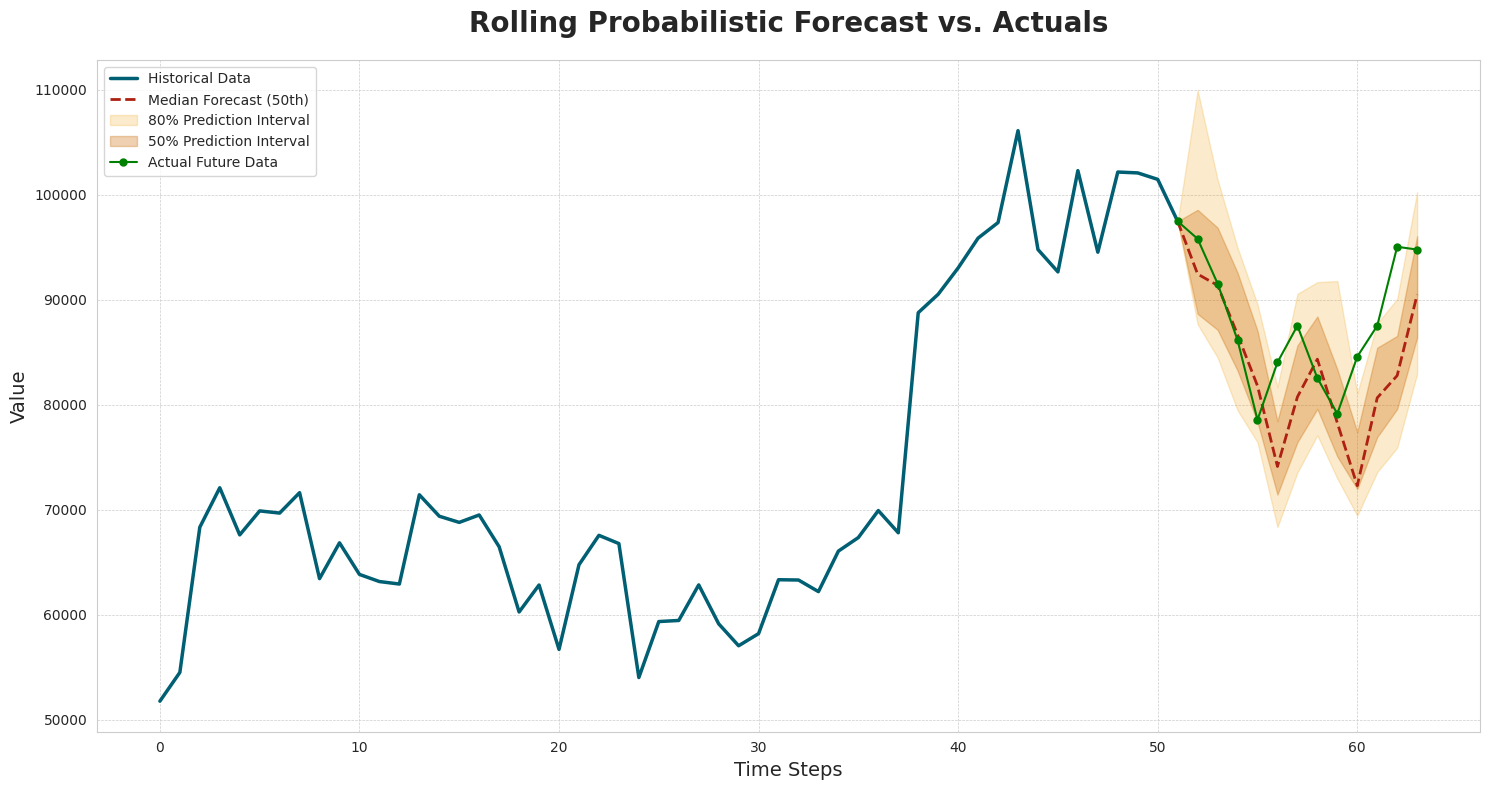

In [ ]:
plot_forecast(historical_data=np.array(b_series[-(lookback+horizon):(-horizon)]),
              forecast_trajectories=forecast,
              actual_future_data=np.array(b_series[-horizon:]))

In [ ]:
file_path = path+'sapheneia/github/sapheneia/notebooks/marcelo/250718_interleaved_simulation.npy'
np.save(file_path,distributions)

In [ ]:
x = np.load(file_path)
print(x)

[[0.30585 0.20194 0.54378 ... 0.39872 0.10429 0.2013 ]
 [0.23456 0.20196 0.30874 ... 0.20193 0.23456 0.56148]
 [0.5234  0.10381 0.20191 ... 0.12345 0.5789  0.50013]
 ...
 [0.5449  0.1592  0.20154 ... 0.20191 0.59927 0.36512]
 [0.10387 0.2017  0.1     ... 0.13264 0.20145 0.12345]
 [0.12345 0.54345 0.20163 ... 0.31952 0.20158 0.2014 ]]


### experiment 4: interleaved sequence with lag=12, rolling prediction toward a horizon

#### def

In [ ]:
def create_lagged_sequence_comprehension(series_a, series_b, lag=0):
    """Creates a lagged interleaved sequence using a list comprehension"""
    if lag<0:
        lag = 0
    sequence = [
        item
        for t in range(len(series_a))
        if t + lag < len(series_b)
        for item in (series_a[t], series_b[t + lag])
    ]
    return sequence

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inverse_sigmoid(y):
    epsilon = 1e-9
    y = np.clip(y, epsilon, 1 - epsilon)
    return np.log(y / (1 - y))

In [ ]:
def rolling_interleaved_sequence_forecast(
    a_sequence,
    b_sequence,
    start_index,
    horizon,
    generator_model,
    grammar_obj,
    num_simulations=10,
    temperature=0.7,
    max_tokens=10
):
    """
    Performs an efficient, stateful rolling forecast for a single time series.
    At each step `t`, it simulates `t+1`, then uses the actual value at `t+1`
    to inform the prediction for `t+2`.
    """
    if not grammar_obj or not generator_model:
        return None

    # We multiply by 10000 and format as a four-digit integer string
    a_sequence_str = ["%04d" % (x * 10000) for x in a_sequence]
    b_sequence_str = ["%04d" % (x * 10000) for x in b_sequence]

    sequence_str = create_lagged_sequence_comprehension(series_a=a_sequence_str[:start_index],
                                                        series_b=b_sequence_str[:start_index])

    # Prepare initial context using the new integer string format
    generator_model.reset()
    initial_prompt = ",".join(sequence_str) + ","

    # "Warm up" the model's state (KV Cache) with the historical data
    print(f"Warming up model with {len(sequence_str)} historical data points ...")
    print(f"Historical data points: {sequence_str}")
    initial_tokens = generator_model.tokenize(initial_prompt.encode("utf-8"), add_bos=True)
    print(f"Initial tokens: {initial_tokens}")

    n_ctx = generator_model.n_ctx()
    if len(initial_tokens) >= n_ctx:
        print(f"Error: Initial prompt ({len(initial_tokens)} tokens) exceeds context window ({n_ctx})")
        return None

    generator_model.eval(initial_tokens)
    print("Model warmup complete")

    # This will store the distributions for each future step
    distributions = []

    # Main loop for the rolling forecast
    print(f"\n--- Running rolling forecast for a horizon of {horizon} steps ---")
    for t in tqdm(range(start_index, start_index + horizon), desc="Forecasting Steps"):
        if t >= len(a_sequence):
            break

        # Update the model's state with the A sequence value at step `t`
        update_text = a_sequence_str[t] + ","
        update_tokens = generator_model.tokenize(update_text.encode("utf-8"), add_bos=False)
        print(f"Index={t}")
        print(f"\nA_({t-1})={a_sequence_str[t-1]}, B_({t-1})={b_sequence_str[t-1]}, A_({t})={a_sequence_str[t]}")
        generator_model.eval(update_tokens)

        # Save the current state (which includes all history up to `t-1` for B sequence and `t` for A sequence)
        state = generator_model.save_state()

        # Run N simulations from this state to get the distribution for step `t`
        step_simulations = []
        for _ in range(num_simulations):
            generator_model.load_state(state) # Fast state restoration
            response = generator_model(
                "", # Empty prompt, context is in the state
                max_tokens=max_tokens,
                temperature=temperature,
                grammar=grammar_obj,
                stop=[","],
                top_p=0.95,
                top_k=50,
                repeat_penalty=1.1,
                seed=-1 # Use a random seed for each simulation
            )
            try:
                if response['choices'][0]['text']:
                    # Convert generated integer string back to a float
                    generated_int_str = response['choices'][0]['text']
                    # Reconstruct the "0.xxxx" format and convert to float
                    normalized_prediction = float(f"0.{generated_int_str}")
                    step_simulations.append(normalized_prediction)
                else:
                    step_simulations.append(np.nan)
            except (ValueError, IndexError):
                step_simulations.append(np.nan)
                continue

        valid_simulations = [s for s in step_simulations if not np.isnan(s)]
        distributions.append(valid_simulations)
        print(f"Valid Simulations: {valid_simulations}")

        # Update the model's state with the B sequence at step `t`
        update_text = b_sequence_str[t] + ","
        update_tokens = generator_model.tokenize(update_text.encode("utf-8"), add_bos=False)
        generator_model.eval(update_tokens)
        print(f"A_({t-1})={a_sequence_str[t-1]}, B_({t-1})={b_sequence_str[t-1]}, A_({t})={a_sequence_str[t]}, B_({t})={b_sequence_str[t]}")

    return distributions

In [ ]:
def plot_forecast(historical_data, forecast_trajectories, actual_future_data=None, secondary_series=None,
                  x_title='Time Steps', y1_title='Primary Value', y2_title='Secondary Value'):
    """
    Visualizes historical data, a forecast cloud from raw trajectories, actuals,
    and an optional secondary series on a second y-axis.
    """
    if forecast_trajectories is None or len(forecast_trajectories) == 0:
        print("No forecast data to plot.")
        return

    # Calculate quantiles from the raw simulation trajectories
    q10 = np.quantile(forecast_trajectories, 0.10, axis=0)
    q25 = np.quantile(forecast_trajectories, 0.25, axis=0)
    q50 = np.quantile(forecast_trajectories, 0.50, axis=0)
    q75 = np.quantile(forecast_trajectories, 0.75, axis=0)
    q90 = np.quantile(forecast_trajectories, 0.90, axis=0)

    last_hist_value = historical_data[-1]
    last_hist_time = len(historical_data) - 1

    # Prepend the last historical value to each forecast quantile series for a connected plot
    q10 = np.insert(q10, 0, last_hist_value)
    q25 = np.insert(q25, 0, last_hist_value)
    q50 = np.insert(q50, 0, last_hist_value)
    q75 = np.insert(q75, 0, last_hist_value)
    q90 = np.insert(q90, 0, last_hist_value)

    forecast_time = np.arange(last_hist_time, last_hist_time + len(q50))

    # --- Create the Plot with two y-axes ---
    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots(figsize=(15, 8))

    # Plot primary data on the left axis (ax1)
    ax1.set_xlabel(x_title, fontsize=14)
    ax1.set_ylabel(y1_title, fontsize=14, color='#005f73')

    historical_time = np.arange(len(historical_data))
    ax1.plot(historical_time, historical_data, color='#005f73', label='Historical Data', linewidth=2.5, zorder=3)
    ax1.plot(forecast_time, q50, color='#ae2012', linestyle='--', label='Median Forecast (50th)', linewidth=2, zorder=3)
    ax1.fill_between(forecast_time, q10, q90, color='#ee9b00', alpha=0.2, label='80% Prediction Interval', zorder=1)
    ax1.fill_between(forecast_time, q25, q75, color='#ca6702', alpha=0.3, label='50% Prediction Interval', zorder=2)
    ax1.tick_params(axis='y', labelcolor='#005f73')

    if actual_future_data is not None and len(actual_future_data) > 0:
        actual_time = np.arange(last_hist_time, last_hist_time + len(actual_future_data) + 1)
        actual_plot_data = np.insert(actual_future_data, 0, last_hist_value)
        ax1.plot(actual_time, actual_plot_data, color='green', marker='o', markersize=5, linestyle='-', label='Actual Future Data', zorder=4)

    # Plot the secondary series on the right axis (ax2)
    if secondary_series is not None:
        ax2 = ax1.twinx()  # Create a second y-axis that shares the same x-axis
        ax2.set_ylabel(y2_title, fontsize=14, color='purple')

        secondary_time = np.arange(len(secondary_series))
        ax2.plot(secondary_time, secondary_series, color='purple', linestyle=':', linewidth=2, label='Secondary Series', zorder=0)
        ax2.tick_params(axis='y', labelcolor='purple')

    # --- Final Touches ---
    plt.title('Rolling Probabilistic Forecast vs. Actuals', fontsize=20, weight='bold', pad=20)

    # Create a combined legend for both axes
    h1, l1 = ax1.get_legend_handles_labels()
    if secondary_series is not None:
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1 + h2, l1 + l2, loc='upper left')
    else:
        ax1.legend(h1, l1, loc='upper left')

    fig.tight_layout()
    plt.show()

#### setup (lag=12)

In [ ]:
lag = 12 # Define lag in number of periods to create a interleaved sequence from

In [ ]:
# This grammar forces the model to output only a sequence of digits, representing the numbers after the decimal point.
gbnf_grammar_str = r'''
root   ::= number
number ::= [0-9]+
'''
try:
    integer_grammar = LlamaGrammar.from_string(gbnf_grammar_str)
    print("Strict integer grammar parsed successfully.")
except Exception as e:
    print(f"Error parsing grammar: {e}")
    integer_grammar = None

Strict integer grammar parsed successfully.


In [ ]:
generator_model = generator_q8_0
grammar_obj = integer_grammar
num_simulations = 10
temperature = 0.9
horizon = 12
lookback = 52

In [ ]:
# Sequence A: WM2 lagged
if lag>0:
    a_series = np.array(data['wm2'].tolist()[:-lag])
else:
    a_series = np.array(data['wm2'].tolist())
a_logreturns = np.diff(np.log(a_series))
a_history = np.array(a_logreturns[-(lookback+horizon):])
a_horizon = np.array(a_logreturns[-horizon:])
print(a_history)
print(a_horizon)
len(a_history),len(a_horizon)

[-4.44124768e-04  4.71597873e-03 -1.44174971e-05  3.50214324e-03
  1.26351475e-03 -8.66101283e-04  1.34906949e-03 -6.93443164e-04
 -6.20495554e-03 -2.56905373e-03  6.18249658e-03 -3.77712552e-03
  5.63148448e-04 -5.43890273e-04  7.96029830e-03  2.36149022e-03
  3.77157029e-03 -2.08140356e-03  8.18651531e-03 -6.98541587e-04
  1.55798171e-04 -1.25937813e-02 -3.95180752e-03  4.10955546e-03
 -2.22511020e-03  1.40263556e-03 -2.45710372e-03  7.14379201e-03
  1.61757675e-03  8.36307183e-04 -4.48431245e-03  1.86376463e-03
  3.33750435e-03 -6.12467289e-04 -3.11561555e-03 -1.20127006e-03
  7.91036244e-03 -1.00847268e-03  6.96096913e-04 -2.58794900e-03
  4.76308616e-03  4.19032880e-03 -1.12951819e-03 -4.80054167e-03
  2.24500934e-03  4.15530681e-03 -1.30786005e-03 -1.27113557e-04
 -1.43703571e-03  8.09576532e-03  1.79901126e-03  2.01012592e-03
 -3.40699931e-03  5.91514978e-03  1.90366583e-03  1.71946771e-03
  1.51309410e-03  5.82416583e-04  4.29661429e-04  6.60302239e-04
 -3.64401892e-03 -4.57377

(64, 12)

In [ ]:
# Sequence A normalization
a_history_reshaped = a_history.reshape(-1, 1)

# Fit a StandardScaler to the raw data
a_scaler = StandardScaler()
a_scaler.fit(a_history_reshaped)

# Standardize the data (mean=0, std=1)
a_logreturns_reshaped = a_logreturns.reshape(-1, 1)
a_standardized = a_scaler.transform(a_logreturns_reshaped)

# Apply the sigmoid function to map to the [0, 1] range
a_normalized = sigmoid(a_standardized).flatten()
a_sequence = a_normalized[-(lookback+horizon):]

print(f"Original first value: {a_history[0]:.4f}, Sigmoid-Normalized: {a_sequence[0]:.4f}")
print(f"Original last value:  {a_history[-1]:.4f}, Sigmoid-Normalized: {a_sequence[-1]:.4f}")
print(a_sequence,len(a_sequence))

Original first value: -0.0004, Sigmoid-Normalized: 0.4315
Original last value:  0.0000, Sigmoid-Normalized: 0.4625
[0.43145197 0.75000165 0.45972147 0.68466175 0.54461904 0.40411796
 0.55026521 0.41524041 0.14057743 0.30112022 0.81596909 0.23798187
 0.49809708 0.42494518 0.87684045 0.61572249 0.69994777 0.3291419
 0.88320161 0.41491068 0.47100211 0.02896257 0.22964661 0.71850981
 0.32074519 0.5537938  0.30743299 0.85136447 0.56789486 0.51628235
 0.20551802 0.58391042 0.67511734 0.42048743 0.27139379 0.38281469
 0.87539674 0.39501956 0.50695034 0.30006204 0.75234709 0.72284106
 0.38734054 0.1921044  0.60835509 0.72096815 0.37612892 0.45227473
 0.3680895  0.88068471 0.57971364 0.59335078 0.25632052 0.80503361
 0.58649048 0.57454253 0.56105264 0.49938024 0.48920917 0.50456691
 0.24447149 0.20165409 0.55941838 0.4625214 ] 64


In [ ]:
# Sequence B: BTC
b_series = np.array(data['btc'].tolist())
b_logreturns = np.diff(np.log(b_series))
b_history = np.array(b_logreturns[-(lookback+horizon):])
b_horizon = np.array(b_logreturns[-horizon:])
print(b_history)
print(b_horizon)
len(b_history),len(b_horizon)

[ 0.03614578  0.05151401  0.22593384  0.05352125 -0.06424902  0.0332073
 -0.00295018  0.02750033 -0.12129586  0.05230559 -0.04601672 -0.01069321
 -0.00374545  0.12666176 -0.02902408 -0.00849909  0.01020893 -0.04447977
 -0.09807691  0.04176181 -0.10266566  0.13282748  0.04235638 -0.01168494
 -0.21187215  0.09406248  0.00174237  0.05537725 -0.06071582 -0.03600076
  0.02001871  0.08449076 -0.00042888 -0.01760606  0.06017511  0.01933547
  0.03741131 -0.0306966   0.26917861  0.01959659  0.02729421  0.03007829
  0.01530681  0.08608729 -0.11281006 -0.02268216  0.09894763 -0.07894904
  0.07764335 -0.0008131  -0.00603822 -0.04015108 -0.01726605 -0.04541864
 -0.06054904 -0.09231063  0.06723252  0.04075702 -0.05859554 -0.04202011
  0.06639044  0.03416914  0.08242919 -0.0028146 ]
[-0.01726605 -0.04541864 -0.06054904 -0.09231063  0.06723252  0.04075702
 -0.05859554 -0.04202011  0.06639044  0.03416914  0.08242919 -0.0028146 ]


(64, 12)

In [ ]:
# Sequence A normalization
b_history_reshaped = b_history.reshape(-1, 1)

# Fit a StandardScaler to the raw data
b_scaler = StandardScaler()
b_scaler.fit(b_history_reshaped)

# Standardize the data (mean=0, std=1)
b_logreturns_reshaped = b_logreturns.reshape(-1, 1)
b_standardized = b_scaler.transform(b_logreturns_reshaped)

# Apply the sigmoid function to map to the [0, 1] range
b_normalized = sigmoid(b_standardized).flatten()
b_sequence = b_normalized[-(lookback+horizon):]

print(f"Original first value: {b_history[0]:.4f}, Sigmoid-Normalized: {b_sequence[0]:.4f}")
print(f"Original last value:  {b_history[-1]:.4f}, Sigmoid-Normalized: {b_sequence[-1]:.4f}")
print(b_sequence,len(b_sequence))

Original first value: 0.0361, Sigmoid-Normalized: 0.5850
Original last value:  -0.0028, Sigmoid-Normalized: 0.4580
[0.58498647 0.63300242 0.9445849  0.63910494 0.27383018 0.57558727
 0.45755333 0.55718148 0.15129105 0.63541425 0.32391919 0.43244295
 0.4549621  0.82231125 0.37457425 0.43952896 0.50065782 0.32835542
 0.19473048 0.60277395 0.18545345 0.83383637 0.60464218 0.42924899
 0.0514604  0.75099706 0.47288517 0.64470801 0.28315366 0.35336692
 0.53282018 0.7267559  0.46578299 0.41031047 0.65900677 0.53058585
 0.58901589 0.36944255 0.96782485 0.53143991 0.55651344 0.56551838
 0.51738926 0.73089996 0.16616407 0.39428158 0.76280089 0.23715497
 0.70853788 0.46452756 0.44750576 0.34101347 0.4113914  0.32564177
 0.28359846 0.20688124 0.67951872 0.59960995 0.28883995 0.33551887
 0.67710548 0.57867024 0.72134621 0.45799531] 64


In [ ]:
# Testing the creation of the interleaved sequence
normalized = create_lagged_sequence_comprehension(series_a=a_sequence, series_b=b_sequence, lag=lag)
print(normalized[:100])

[np.float64(0.4314519693036073), np.float64(0.45496210315377617), np.float64(0.7500016499542855), np.float64(0.8223112546378175), np.float64(0.45972147245487827), np.float64(0.3745742512552347), np.float64(0.6846617493173444), np.float64(0.4395289632085694), np.float64(0.5446190355469133), np.float64(0.5006578203769282), np.float64(0.40411796374169395), np.float64(0.3283554231971113), np.float64(0.5502652054886595), np.float64(0.19473048290269312), np.float64(0.4152404105206017), np.float64(0.6027739459782175), np.float64(0.14057742954048383), np.float64(0.18545345251242892), np.float64(0.3011202232389487), np.float64(0.8338363733751846), np.float64(0.8159690947670073), np.float64(0.6046421769614897), np.float64(0.23798187207874766), np.float64(0.42924898778373605), np.float64(0.4980970815317288), np.float64(0.051460403546329594), np.float64(0.424945184863201), np.float64(0.7509970573747949), np.float64(0.8768404516238995), np.float64(0.4728851731591355), np.float64(0.6157224887371493)

In [ ]:
print(['%.4f' % x for x in a_sequence])
print(['%.4f' % x for x in b_sequence])

['0.4315', '0.7500', '0.4597', '0.6847', '0.5446', '0.4041', '0.5503', '0.4152', '0.1406', '0.3011', '0.8160', '0.2380', '0.4981', '0.4249', '0.8768', '0.6157', '0.6999', '0.3291', '0.8832', '0.4149', '0.4710', '0.0290', '0.2296', '0.7185', '0.3207', '0.5538', '0.3074', '0.8514', '0.5679', '0.5163', '0.2055', '0.5839', '0.6751', '0.4205', '0.2714', '0.3828', '0.8754', '0.3950', '0.5070', '0.3001', '0.7523', '0.7228', '0.3873', '0.1921', '0.6084', '0.7210', '0.3761', '0.4523', '0.3681', '0.8807', '0.5797', '0.5934', '0.2563', '0.8050', '0.5865', '0.5745', '0.5611', '0.4994', '0.4892', '0.5046', '0.2445', '0.2017', '0.5594', '0.4625']
['0.5850', '0.6330', '0.9446', '0.6391', '0.2738', '0.5756', '0.4576', '0.5572', '0.1513', '0.6354', '0.3239', '0.4324', '0.4550', '0.8223', '0.3746', '0.4395', '0.5007', '0.3284', '0.1947', '0.6028', '0.1855', '0.8338', '0.6046', '0.4292', '0.0515', '0.7510', '0.4729', '0.6447', '0.2832', '0.3534', '0.5328', '0.7268', '0.4658', '0.4103', '0.6590', '0.5306'

In [ ]:
prompt_data = ['%.4f' % x for x in normalized]
prompt = ",".join(prompt_data) + ","
prompt

'0.4315,0.4550,0.7500,0.8223,0.4597,0.3746,0.6847,0.4395,0.5446,0.5007,0.4041,0.3284,0.5503,0.1947,0.4152,0.6028,0.1406,0.1855,0.3011,0.8338,0.8160,0.6046,0.2380,0.4292,0.4981,0.0515,0.4249,0.7510,0.8768,0.4729,0.6157,0.6447,0.6999,0.2832,0.3291,0.3534,0.8832,0.5328,0.4149,0.7268,0.4710,0.4658,0.0290,0.4103,0.2296,0.6590,0.7185,0.5306,0.3207,0.5890,0.5538,0.3694,0.3074,0.9678,0.8514,0.5314,0.5679,0.5565,0.5163,0.5655,0.2055,0.5174,0.5839,0.7309,0.6751,0.1662,0.4205,0.3943,0.2714,0.7628,0.3828,0.2372,0.8754,0.7085,0.3950,0.4645,0.5070,0.4475,0.3001,0.3410,0.7523,0.4114,0.7228,0.3256,0.3873,0.2836,0.1921,0.2069,0.6084,0.6795,0.7210,0.5996,0.3761,0.2888,0.4523,0.3355,0.3681,0.6771,0.8807,0.5787,0.5797,0.7213,0.5934,0.4580,'

#### run (lag=12)

In [ ]:
distributions = rolling_interleaved_sequence_forecast(
    a_sequence=a_sequence,
    b_sequence=b_sequence,
    start_index=lookback,
    horizon=horizon,
    generator_model=generator_model,
    grammar_obj=grammar_obj,
    num_simulations=100,
    max_tokens=6,
    temperature=0.8
)

Warming up model with 104 historical data points ...
Historical data points: ['4314', '5849', '7500', '6330', '4597', '9445', '6846', '6391', '5446', '2738', '4041', '5755', '5502', '4575', '4152', '5571', '1405', '1512', '3011', '6354', '8159', '3239', '2379', '4324', '4980', '4549', '4249', '8223', '8768', '3745', '6157', '4395', '6999', '5006', '3291', '3283', '8832', '1947', '4149', '6027', '4710', '1854', '0289', '8338', '2296', '6046', '7185', '4292', '3207', '0514', '5537', '7509', '3074', '4728', '8513', '6447', '5678', '2831', '5162', '3533', '2055', '5328', '5839', '7267', '6751', '4657', '4204', '4103', '2713', '6590', '3828', '5305', '8753', '5890', '3950', '3694', '5069', '9678', '3000', '5314', '7523', '5565', '7228', '5655', '3873', '5173', '1921', '7308', '6083', '1661', '7209', '3942', '3761', '7628', '4522', '2371', '3680', '7085', '8806', '4645', '5797', '4475', '5933', '3410']
Initial tokens: [1, 29871, 29946, 29941, 29896, 29946, 29892, 29945, 29947, 29946, 29929, 

Forecasting Steps:   0%|          | 0/12 [00:00<?, ?it/s]

Index=52

A_(51)=5933, B_(51)=3410, A_(52)=2563


Forecasting Steps:   8%|▊         | 1/12 [00:47<08:38, 47.10s/it]

Valid Simulations: [0.18409, 0.35927, 0.5, 0.15349, 0.20169, 0.34698, 0.81736, 0.48163, 0.20146, 0.5, 0.30005, 0.54299, 0.10451, 0.23808, 0.58648, 0.39548, 0.54804, 0.14673, 0.65371, 0.10111, 0.20091, 0.88888, 0.19983, 0.198, 0.20192, 0.33333, 0.19803, 0.14268, 0.26591, 0.20185, 0.25637, 0.3, 0.20184, 0.30529, 0.1, 0.54851, 0.39867, 0.31392, 0.30415, 0.1097, 0.2008, 0.37974, 0.17083, 0.20094, 0.21061, 0.2019, 0.34567, 0.51061, 0.2017, 0.19971, 0.85012, 0.20143, 0.12345, 0.39554, 0.17378, 0.12563, 0.23456, 0.72493, 0.13456, 0.12456, 0.10608, 0.48917, 0.20192, 0.12345, 0.2, 0.20151, 0.35841, 0.50687, 0.42869, 0.36507, 0.19378, 0.39678, 0.21032, 0.28147, 0.45972, 0.40356, 0.50003, 0.20174, 0.20141, 0.10009, 0.19728, 0.46323, 0.1992, 0.20181, 0.12638, 0.20168, 0.10009, 0.10113, 0.56576, 0.20141, 0.2015, 0.34823, 0.26901, 0.14769, 0.5342, 0.59367, 0.43176, 0.53142, 0.8538, 0.2015]
A_(51)=5933, B_(51)=3410, A_(52)=2563, B_(52)=4113
Index=53

A_(52)=2563, B_(52)=4113, A_(53)=8050


Forecasting Steps:  17%|█▋        | 2/12 [01:30<07:27, 44.80s/it]

Valid Simulations: [0.54321, 0.38514, 0.26357, 0.89091, 0.39746, 0.72697, 0.31336, 0.36572, 0.88877, 0.20165, 0.34645, 0.57614, 0.48102, 0.75608, 0.40873, 0.18319, 0.40789, 0.42127, 0.44317, 0.39574, 0.50453, 0.24715, 0.20191, 0.51336, 0.80211, 0.30516, 0.53054, 0.12775, 0.20131, 0.17945, 0.19931, 0.51004, 0.26893, 0.47964, 0.1008, 0.32467, 0.30014, 0.53783, 0.2378, 0.47301, 0.20152, 0.30371, 0.20131, 0.88888, 0.10469, 0.59087, 0.56482, 0.33333, 0.53006, 0.20182, 0.42016, 0.20135, 0.35124, 0.20196, 0.10074, 0.20152, 0.20163, 0.2012, 0.1994, 0.33333, 0.20153, 0.2018, 0.57419, 0.20168, 0.20162, 0.43817, 0.10142, 0.1996, 0.3037, 0.3655, 0.32612, 0.2007, 0.10001, 0.30461, 0.13706, 0.12345, 0.83924, 0.32084, 0.39442, 0.1093, 0.37844, 0.3902, 0.40238, 0.37182, 0.3, 0.86391, 0.3275, 0.46309, 0.3001, 0.14986, 0.39056, 0.14659, 0.1988, 0.30841, 0.3, 0.50371, 0.36551, 0.38039, 0.30576, 0.29815]
A_(52)=2563, B_(52)=4113, A_(53)=8050, B_(53)=3256
Index=54

A_(53)=8050, B_(53)=3256, A_(54)=5864
Val

Forecasting Steps:  25%|██▌       | 3/12 [02:13<06:37, 44.13s/it]

A_(53)=8050, B_(53)=3256, A_(54)=5864, B_(54)=2835
Index=55

A_(54)=5864, B_(54)=2835, A_(55)=5745


Forecasting Steps:  33%|███▎      | 4/12 [02:56<05:50, 43.80s/it]

Valid Simulations: [0.31369, 0.21799, 0.30089, 0.13071, 0.20141, 0.8426, 0.35278, 0.30466, 0.33333, 0.73485, 0.116, 0.50583, 0.10567, 0.51072, 0.30004, 0.10524, 0.30516, 0.2018, 0.45678, 0.59769, 0.30005, 0.20143, 0.58502, 0.50002, 0.3728, 0.5378, 0.54596, 0.50248, 0.34499, 0.37109, 0.20173, 0.70102, 0.20142, 0.30984, 0.85232, 0.2018, 0.4519, 0.20122, 0.51628, 0.12345, 0.31367, 0.34567, 0.2019, 0.10867, 0.50372, 0.21869, 0.19841, 0.29738, 0.20174, 0.30005, 0.32838, 0.20132, 0.57748, 0.46621, 0.2811, 0.12503, 0.20195, 0.52017, 0.20192, 0.78912, 0.24765, 0.33345, 0.89246, 0.34812, 0.45678, 0.53305, 0.1182, 0.20134, 0.34398, 0.30271, 0.51285, 0.48567, 0.1275, 0.11121, 0.66666, 0.10146, 0.85906, 0.13094, 0.6108, 0.74996, 0.3, 0.74268, 0.20161, 0.10088, 0.2012, 0.20186, 0.13924, 0.50368, 0.35704, 0.19979, 0.80211, 0.20193, 0.19939, 0.20165, 0.29863, 0.2017, 0.1985, 0.37956, 0.30126, 0.5]
A_(54)=5864, B_(54)=2835, A_(55)=5745, B_(55)=2068
Index=56

A_(55)=5745, B_(55)=2068, A_(56)=5610


Forecasting Steps:  42%|████▏     | 5/12 [03:40<05:05, 43.62s/it]

Valid Simulations: [0.28362, 0.45678, 0.60304, 0.23645, 0.20132, 0.35008, 0.33333, 0.11039, 0.20181, 0.30007, 0.2019, 0.19829, 0.10514, 0.13345, 0.20143, 0.83456, 0.20175, 0.20181, 0.20061, 0.20132, 0.46218, 0.20191, 0.45724, 0.34567, 0.41529, 0.19902, 0.31072, 0.23456, 0.1994, 0.44794, 0.20163, 0.71508, 0.2019, 0.20186, 0.31701, 0.20131, 0.21385, 0.20191, 0.4041, 0.88888, 0.54678, 0.89293, 0.20161, 0.32666, 0.20137, 0.40122, 0.68703, 0.20151, 0.5, 0.20152, 0.38455, 0.13404, 0.20063, 0.64205, 0.50812, 0.20195, 0.19563, 0.20173, 0.28729, 0.42397, 0.31471, 0.79053, 0.57479, 0.53109, 0.1592, 0.50893, 0.20141, 0.23786, 0.19972, 0.12805, 0.10054, 0.11356, 0.48729, 0.12345, 0.57689, 0.20175, 0.40922, 0.71292, 0.57361, 0.53396, 0.32146, 0.36549, 0.18092, 0.58455, 0.19752, 0.4954, 0.19873, 0.56858, 0.10182, 0.15308, 0.50011, 0.36037, 0.14382, 0.29947, 0.31982, 0.10854, 0.561, 0.20132, 0.74953, 0.20057]
A_(55)=5745, B_(55)=2068, A_(56)=5610, B_(56)=6795
Index=57

A_(56)=5610, B_(56)=6795, A_(57

Forecasting Steps:  50%|█████     | 6/12 [04:23<04:20, 43.48s/it]

Valid Simulations: [0.23306, 0.3114, 0.12345, 0.20156, 0.53231, 0.10068, 0.20193, 0.33333, 0.2018, 0.30151, 0.24158, 0.58278, 0.46075, 0.20151, 0.43089, 0.52467, 0.57625, 0.2017, 0.12345, 0.24589, 0.14715, 0.38687, 0.23523, 0.50283, 0.35216, 0.40512, 0.20135, 0.5, 0.34567, 0.53728, 0.20198, 0.35265, 0.89851, 0.20181, 0.30125, 0.15849, 0.83492, 0.50639, 0.23359, 0.50021, 0.37933, 0.57729, 0.26004, 0.64059, 0.2016, 0.58481, 0.1, 0.14831, 0.3017, 0.20183, 0.19907, 0.20179, 0.64646, 0.30007, 0.18536, 0.15866, 0.5736, 0.1058, 0.51304, 0.31857, 0.50668, 0.2374, 0.26174, 0.20191, 0.31234, 0.58049, 0.34567, 0.1989, 0.13269, 0.10745, 0.33664, 0.12468, 0.16395, 0.23867, 0.2018, 0.20192, 0.14965, 0.23757, 0.2019, 0.43502, 0.68592, 0.50082, 0.15202, 0.10278, 0.13259, 0.20132, 0.3, 0.10617, 0.265, 0.57441, 0.12345, 0.84085, 0.20151, 0.2601, 0.39284, 0.31689, 0.14293, 0.15433, 0.20163, 0.23617]
A_(56)=5610, B_(56)=6795, A_(57)=4993, B_(57)=5996
Index=58

A_(57)=4993, B_(57)=5996, A_(58)=4892


Forecasting Steps:  58%|█████▊    | 7/12 [05:06<03:36, 43.21s/it]

Valid Simulations: [0.10693, 0.8352, 0.38296, 0.20131, 0.56789, 0.12031, 0.56789, 0.38914, 0.52169, 0.20171, 0.2934, 0.31209, 0.70931, 0.34567, 0.20165, 0.20137, 0.29054, 0.20171, 0.165, 0.2016, 0.5367, 0.36, 0.57481, 0.20162, 0.10002, 0.20193, 0.44675, 0.5921, 0.28649, 0.10409, 0.40017, 0.163, 0.20171, 0.20157, 0.51698, 0.24737, 0.20181, 0.20131, 0.20192, 0.13456, 0.23648, 0.41791, 0.1985, 0.45348, 0.59435, 0.20171, 0.29108, 0.24729, 0.20183, 0.46354, 0.38713, 0.10627, 0.30116, 0.30247, 0.6417, 0.20171, 0.59291, 0.20159, 0.14269, 0.88888, 0.36528, 0.84964, 0.19548, 0.33333, 0.59101, 0.16274, 0.42701, 0.51942, 0.19825, 0.76941, 0.20179, 0.54217, 0.49106, 0.2019, 0.54857, 0.31565, 0.30002, 0.38072, 0.2019, 0.80808, 0.5, 0.29416, 0.31718, 0.2017, 0.50918, 0.15053, 0.31592, 0.52743, 0.34621, 0.50072, 0.10842, 0.30786, 0.2019, 0.31905, 0.47469, 0.4193, 0.18931, 0.52149, 0.3652, 0.20161]
A_(57)=4993, B_(57)=5996, A_(58)=4892, B_(58)=2888
Index=59

A_(58)=4892, B_(58)=2888, A_(59)=5045
Valid

Forecasting Steps:  67%|██████▋   | 8/12 [05:49<02:53, 43.37s/it]

A_(58)=4892, B_(58)=2888, A_(59)=5045, B_(59)=3355
Index=60

A_(59)=5045, B_(59)=3355, A_(60)=2444


Forecasting Steps:  75%|███████▌  | 9/12 [06:33<02:10, 43.39s/it]

Valid Simulations: [0.3012, 0.34115, 0.6427, 0.10365, 0.34, 0.2018, 0.5, 0.20192, 0.29654, 0.10468, 0.20171, 0.71654, 0.78361, 0.721, 0.15692, 0.54556, 0.20136, 0.34714, 0.33333, 0.23456, 0.2021, 0.20152, 0.52311, 0.35867, 0.20181, 0.30815, 0.5, 0.12489, 0.34567, 0.18722, 0.30362, 0.56339, 0.30447, 0.68254, 0.7946, 0.24153, 0.3, 0.38294, 0.3416, 0.52513, 0.20212, 0.1966, 0.73, 0.29163, 0.13499, 0.26714, 0.30264, 0.37859, 0.89457, 0.7946, 0.59487, 0.2018, 0.21907, 0.40002, 0.20193, 0.77777, 0.78901, 0.31681, 0.5, 0.20172, 0.54673, 0.36002, 0.32868, 0.1973, 0.52041, 0.26615, 0.21049, 0.20193, 0.35613, 0.20171, 0.20184, 0.24724, 0.42036, 0.1458, 0.10324, 0.19879, 0.50005, 0.20162, 0.5347, 0.20151, 0.37586, 0.44444, 0.40597, 0.20051, 0.12345, 0.2015, 0.20133, 0.2021, 0.37495, 0.19291, 0.44592, 0.1006, 0.31266, 0.3467, 0.20173, 0.23456, 0.19689, 0.18023, 0.57613, 0.18724]
A_(59)=5045, B_(59)=3355, A_(60)=2444, B_(60)=6771
Index=61

A_(60)=2444, B_(60)=6771, A_(61)=2016


Forecasting Steps:  83%|████████▎ | 10/12 [07:16<01:26, 43.40s/it]

Valid Simulations: [0.51612, 0.16572, 0.13029, 0.51742, 0.85462, 0.20169, 0.14297, 0.2019, 0.15636, 0.2019, 0.79601, 0.23843, 0.15017, 0.20146, 0.20185, 0.14927, 0.11873, 0.20184, 0.20163, 0.19861, 0.36502, 0.20019, 0.1602, 0.3, 0.52618, 0.57004, 0.53162, 0.12345, 0.10246, 0.30169, 0.39487, 0.49726, 0.10355, 0.20171, 0.24806, 0.32085, 0.63726, 0.5389, 0.2018, 0.20212, 0.12345, 0.13325, 0.10518, 0.80211, 0.12345, 0.10751, 0.50144, 0.52383, 0.11162, 0.86887, 0.12345, 0.45938, 0.20091, 0.20193, 0.54017, 0.20151, 0.20196, 0.37298, 0.26301, 0.64232, 0.20187, 0.32109, 0.20202, 0.20168, 0.73081, 0.36514, 0.563, 0.57839, 0.61298, 0.1995, 0.5, 0.82174, 0.24537, 0.71994, 0.19942, 0.365, 0.87126, 0.17236, 0.50583, 0.69832, 0.18389, 0.34201, 0.47186, 0.20073, 0.2017, 0.20151, 0.20142, 0.2009, 0.33012, 0.88874, 0.19829, 0.38492, 0.20185, 0.10234, 0.54235, 0.18636, 0.56015, 0.35824, 0.41768, 0.10557]
A_(60)=2444, B_(60)=6771, A_(61)=2016, B_(61)=5786
Index=62

A_(61)=2016, B_(61)=5786, A_(62)=5594


Forecasting Steps:  92%|█████████▏| 11/12 [08:00<00:43, 43.48s/it]

Valid Simulations: [0.32518, 0.50876, 0.58306, 0.2016, 0.20195, 0.20132, 0.89725, 0.20141, 0.34017, 0.58063, 0.54378, 0.56074, 0.4912, 0.20211, 0.63018, 0.20143, 0.54186, 0.17751, 0.19892, 0.18063, 0.2018, 0.66666, 0.41865, 0.19978, 0.33397, 0.36, 0.44361, 0.75024, 0.52096, 0.14593, 0.56789, 0.16725, 0.20131, 0.81649, 0.12345, 0.33065, 0.2018, 0.3652, 0.30615, 0.14377, 0.53675, 0.52147, 0.20181, 0.15, 0.81425, 0.7531, 0.20194, 0.30869, 0.12345, 0.23518, 0.1, 0.30303, 0.89344, 0.56789, 0.65317, 0.28059, 0.65025, 0.20162, 0.365, 0.35304, 0.40485, 0.23456, 0.80211, 0.2015, 0.59246, 0.1165, 0.30007, 0.2016, 0.30103, 0.20175, 0.34567, 0.52414, 0.84529, 0.20175, 0.48193, 0.23062, 0.20182, 0.81105, 0.70045, 0.17981, 0.40097, 0.18455, 0.10913, 0.5943, 0.20163, 0.14528, 0.80105, 0.20182, 0.17064, 0.30002, 0.37168, 0.69764, 0.34567, 0.1988, 0.57482, 0.20181, 0.30281, 0.2013, 0.20151, 0.28015]
A_(61)=2016, B_(61)=5786, A_(62)=5594, B_(62)=7213
Index=63

A_(62)=5594, B_(62)=7213, A_(63)=4625


Forecasting Steps: 100%|██████████| 12/12 [08:43<00:00, 43.66s/it]

Valid Simulations: [0.19832, 0.52669, 0.19803, 0.25001, 0.20175, 0.2016, 0.20141, 0.56887, 0.74209, 0.20033, 0.2113, 0.39617, 0.20173, 0.20211, 0.20138, 0.23319, 0.20213, 0.31809, 0.20168, 0.41665, 0.16348, 0.84793, 0.73046, 0.14386, 0.65318, 0.20142, 0.48002, 0.20161, 0.52183, 0.20153, 0.77777, 0.20013, 0.12345, 0.30479, 0.88899, 0.30193, 0.24712, 0.54321, 0.42018, 0.20143, 0.3547, 0.2869, 0.12345, 0.45678, 0.20172, 0.32198, 0.20157, 0.2015, 0.23754, 0.29165, 0.20187, 0.53054, 0.34649, 0.2016, 0.45064, 0.48102, 0.51885, 0.23827, 0.20148, 0.50826, 0.34757, 0.81732, 0.10457, 0.59158, 0.53736, 0.2019, 0.19867, 0.53762, 0.1995, 0.70648, 0.20197, 0.10121, 0.31687, 0.20196, 0.2019, 0.34752, 0.10433, 0.14732, 0.10657, 0.32118, 0.35159, 0.42831, 0.20175, 0.38472, 0.26716, 0.3, 0.59609, 0.3408, 0.21046, 0.56789, 0.47179, 0.30162, 0.69845, 0.12345, 0.19954, 0.58918, 0.44663, 0.10802, 0.10533, 0.48635]
A_(62)=5594, B_(62)=7213, A_(63)=4625, B_(63)=4579


#### analysis (lag=12)

In [ ]:
# Convert list of lists to a 2D numpy array for easier processing
x = np.array(distributions)

# Inverse transform the results
inverse_x = inverse_sigmoid(x)
x_logreturn = b_scaler.inverse_transform(inverse_x).T

# Compute forecast B
b_series_reshaped = b_series[-(horizon+1):-1].reshape(1, -1)
forecast = np.exp(x_logreturn)*b_series_reshaped

print(b_series_reshaped)
print(forecast)

[[97458.594 95790.313 91536.969 86158.953 78561.617 84025.117 87520.477
  82539.523 79143.063 84575.75  87515.57  95035.063]]
[[ 87888.83353167  98038.78016039 103469.44758501 ...  85847.06387205
   83616.25297605  86306.06557038]
 [ 94196.83261753  93368.37980602  81507.24755604 ...  75534.78132208
   88632.0499691   96775.21781172]
 [ 98438.9144466   89472.96827318 108318.24124615 ...  73929.5047374
   90681.98581902  86294.07349737]
 ...
 [ 99386.68124567  93225.55748953  83243.77987867 ...  81717.29160604
   79590.10972395  81737.51055775]
 [112595.56041791  90897.63147082  83267.41796913 ...  83292.16312095
   79598.0222782   81562.01383521]
 [ 88641.07983354  90648.0883398   86859.35443187 ...  72599.57234941
   82267.03957296  95592.67648417]]


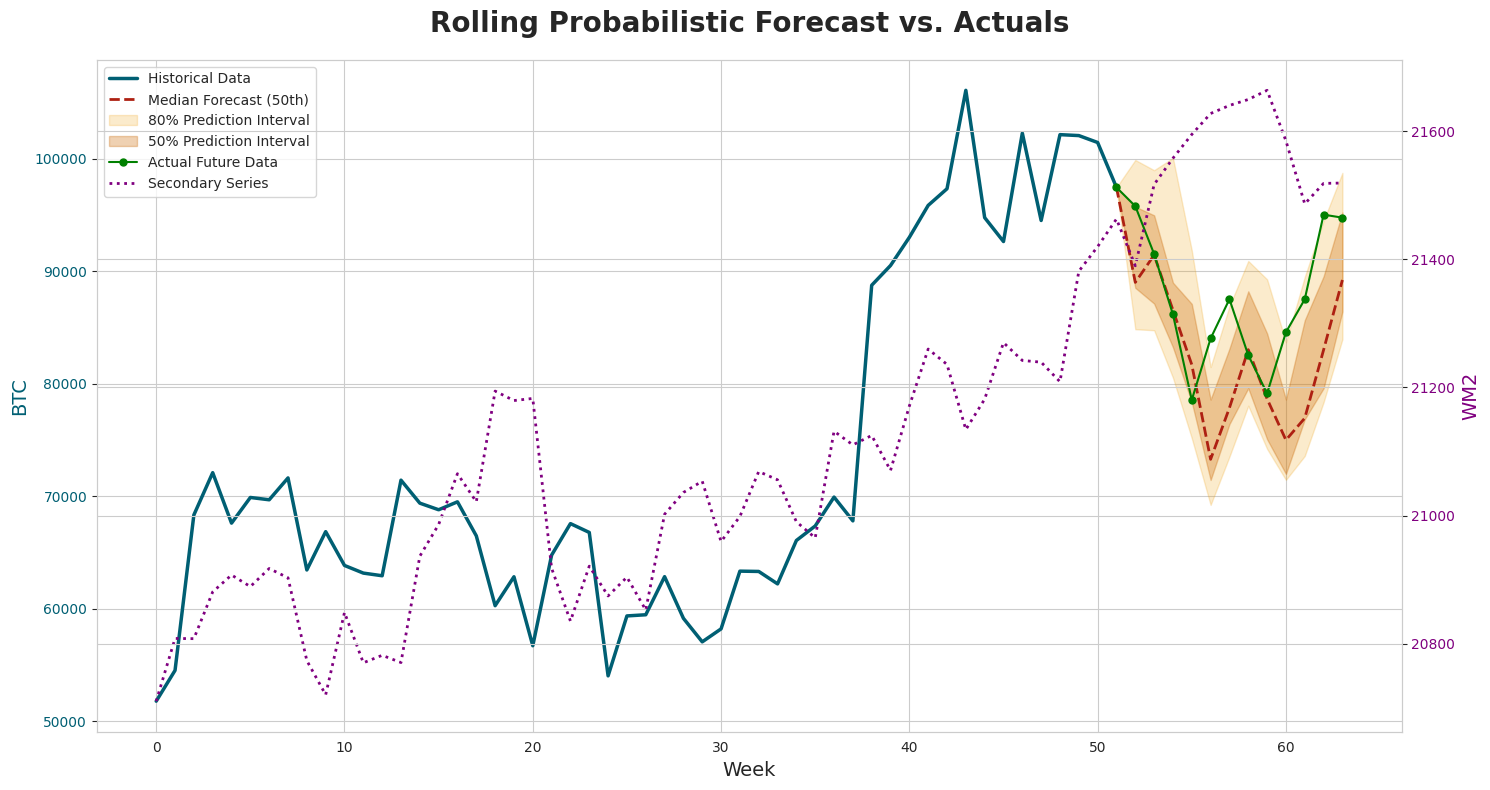

In [ ]:
plot_forecast(historical_data=np.array(b_series[-(lookback+horizon):(-horizon)]),
    forecast_trajectories=forecast,
    actual_future_data=np.array(b_series[-horizon:]),
    secondary_series=np.array(a_series[-(lookback+horizon):]),
    x_title='Week',
    y1_title='BTC',
    y2_title='WM2')

In [ ]:
file_path = path+'sapheneia/github/sapheneia/notebooks/marcelo/250721_interleaved_simulation_lag_12.npy'
np.save(file_path,distributions)

In [ ]:
x = np.load(file_path)
print(x)

[[0.18409 0.35927 0.5     ... 0.53142 0.8538  0.2015 ]
 [0.54321 0.38514 0.26357 ... 0.38039 0.30576 0.29815]
 [0.81425 0.16035 0.88888 ... 0.20121 0.20181 0.30569]
 ...
 [0.51612 0.16572 0.13029 ... 0.35824 0.41768 0.10557]
 [0.32518 0.50876 0.58306 ... 0.2013  0.20151 0.28015]
 [0.19832 0.52669 0.19803 ... 0.10802 0.10533 0.48635]]


#### setup (lag=0)

In [ ]:
lag = 0 # Define lag in number of periods to create a interleaved sequence from

In [ ]:
# This grammar forces the model to output only a sequence of digits, representing the numbers after the decimal point.
gbnf_grammar_str = r'''
root   ::= number
number ::= [0-9]+
'''
try:
    integer_grammar = LlamaGrammar.from_string(gbnf_grammar_str)
    print("Strict integer grammar parsed successfully.")
except Exception as e:
    print(f"Error parsing grammar: {e}")
    integer_grammar = None

Strict integer grammar parsed successfully.


In [ ]:
generator_model = generator_q8_0
grammar_obj = integer_grammar
num_simulations = 10
temperature = 0.9
horizon = 12
lookback = 52

In [ ]:
# Sequence A: WM2 lagged
if lag>0:
    a_series = np.array(data['wm2'].tolist()[:-lag])
else:
    a_series = np.array(data['wm2'].tolist())
a_logreturns = np.diff(np.log(a_series))
a_history = np.array(a_logreturns[-(lookback+horizon):])
a_horizon = np.array(a_logreturns[-horizon:])
print(a_history)
print(a_horizon)
len(a_history),len(a_horizon)

[ 5.63148448e-04 -5.43890273e-04  7.96029830e-03  2.36149022e-03
  3.77157029e-03 -2.08140356e-03  8.18651531e-03 -6.98541587e-04
  1.55798171e-04 -1.25937813e-02 -3.95180752e-03  4.10955546e-03
 -2.22511020e-03  1.40263556e-03 -2.45710372e-03  7.14379201e-03
  1.61757675e-03  8.36307183e-04 -4.48431245e-03  1.86376463e-03
  3.33750435e-03 -6.12467289e-04 -3.11561555e-03 -1.20127006e-03
  7.91036244e-03 -1.00847268e-03  6.96096913e-04 -2.58794900e-03
  4.76308616e-03  4.19032880e-03 -1.12951819e-03 -4.80054167e-03
  2.24500934e-03  4.15530681e-03 -1.30786005e-03 -1.27113557e-04
 -1.43703571e-03  8.09576532e-03  1.79901126e-03  2.01012592e-03
 -3.40699931e-03  5.91514978e-03  1.90366583e-03  1.71946771e-03
  1.51309410e-03  5.82416583e-04  4.29661429e-04  6.60302239e-04
 -3.64401892e-03 -4.57377683e-03  1.48819240e-03  2.78824661e-05
  1.43953737e-03  9.74421438e-05  5.99065956e-03  5.02384156e-03
  5.56020973e-03 -1.51626589e-03  4.25523824e-03  4.92581642e-03
  1.47528695e-03 -8.07732

(64, 12)

In [ ]:
# Sequence A normalization
a_history_reshaped = a_history.reshape(-1, 1)

# Fit a StandardScaler to the raw data
a_scaler = StandardScaler()
a_scaler.fit(a_history_reshaped)

# Standardize the data (mean=0, std=1)
a_logreturns_reshaped = a_logreturns.reshape(-1, 1)
a_standardized = a_scaler.transform(a_logreturns_reshaped)

# Apply the sigmoid function to map to the [0, 1] range
a_normalized = sigmoid(a_standardized).flatten()
a_sequence = a_normalized[-(lookback+horizon):]

print(f"Original first value: {a_history[0]:.4f}, Sigmoid-Normalized: {a_sequence[0]:.4f}")
print(f"Original last value:  {a_history[-1]:.4f}, Sigmoid-Normalized: {a_sequence[-1]:.4f}")
print(a_sequence,len(a_sequence))

Original first value: 0.0006, Sigmoid-Normalized: 0.4865
Original last value:  0.0023, Sigmoid-Normalized: 0.5975
[0.48651152 0.41766187 0.85892154 0.59827977 0.67981621 0.32760172
 0.86567569 0.40823352 0.46097638 0.03347729 0.23335821 0.69802866
 0.31969074 0.53920877 0.30713707 0.83216035 0.55260804 0.50368253
 0.21025882 0.56786074 0.65560358 0.4134732  0.27306069 0.37808011
 0.85739288 0.38954669 0.49486731 0.3001792  0.73150783 0.70229322
 0.38233238 0.19735707 0.59121938 0.70044844 0.37179783 0.44335354
 0.36424223 0.86299959 0.56386015 0.5768699  0.25875879 0.78448918
 0.57032154 0.55893445 0.54610299 0.48772216 0.47812946 0.49261714
 0.24749105 0.20654711 0.54455021 0.45299361 0.54151378 0.45733185
 0.78768242 0.74419054 0.76901485 0.35964061 0.70569494 0.73946922
 0.54374513 0.09735362 0.11922887 0.59747193] 64


In [ ]:
# Sequence B: BTC
b_series = np.array(data['btc'].tolist())
b_logreturns = np.diff(np.log(b_series))
b_history = np.array(b_logreturns[-(lookback+horizon):])
b_horizon = np.array(b_logreturns[-horizon:])
print(b_history)
print(b_horizon)
len(b_history),len(b_horizon)

[ 0.03614578  0.05151401  0.22593384  0.05352125 -0.06424902  0.0332073
 -0.00295018  0.02750033 -0.12129586  0.05230559 -0.04601672 -0.01069321
 -0.00374545  0.12666176 -0.02902408 -0.00849909  0.01020893 -0.04447977
 -0.09807691  0.04176181 -0.10266566  0.13282748  0.04235638 -0.01168494
 -0.21187215  0.09406248  0.00174237  0.05537725 -0.06071582 -0.03600076
  0.02001871  0.08449076 -0.00042888 -0.01760606  0.06017511  0.01933547
  0.03741131 -0.0306966   0.26917861  0.01959659  0.02729421  0.03007829
  0.01530681  0.08608729 -0.11281006 -0.02268216  0.09894763 -0.07894904
  0.07764335 -0.0008131  -0.00603822 -0.04015108 -0.01726605 -0.04541864
 -0.06054904 -0.09231063  0.06723252  0.04075702 -0.05859554 -0.04202011
  0.06639044  0.03416914  0.08242919 -0.0028146 ]
[-0.01726605 -0.04541864 -0.06054904 -0.09231063  0.06723252  0.04075702
 -0.05859554 -0.04202011  0.06639044  0.03416914  0.08242919 -0.0028146 ]


(64, 12)

In [ ]:
# Sequence A normalization
b_history_reshaped = b_history.reshape(-1, 1)

# Fit a StandardScaler to the raw data
b_scaler = StandardScaler()
b_scaler.fit(b_history_reshaped)

# Standardize the data (mean=0, std=1)
b_logreturns_reshaped = b_logreturns.reshape(-1, 1)
b_standardized = b_scaler.transform(b_logreturns_reshaped)

# Apply the sigmoid function to map to the [0, 1] range
b_normalized = sigmoid(b_standardized).flatten()
b_sequence = b_normalized[-(lookback+horizon):]

print(f"Original first value: {b_history[0]:.4f}, Sigmoid-Normalized: {b_sequence[0]:.4f}")
print(f"Original last value:  {b_history[-1]:.4f}, Sigmoid-Normalized: {b_sequence[-1]:.4f}")
print(b_sequence,len(b_sequence))

Original first value: 0.0361, Sigmoid-Normalized: 0.5850
Original last value:  -0.0028, Sigmoid-Normalized: 0.4580
[0.58498647 0.63300242 0.9445849  0.63910494 0.27383018 0.57558727
 0.45755333 0.55718148 0.15129105 0.63541425 0.32391919 0.43244295
 0.4549621  0.82231125 0.37457425 0.43952896 0.50065782 0.32835542
 0.19473048 0.60277395 0.18545345 0.83383637 0.60464218 0.42924899
 0.0514604  0.75099706 0.47288517 0.64470801 0.28315366 0.35336692
 0.53282018 0.7267559  0.46578299 0.41031047 0.65900677 0.53058585
 0.58901589 0.36944255 0.96782485 0.53143991 0.55651344 0.56551838
 0.51738926 0.73089996 0.16616407 0.39428158 0.76280089 0.23715497
 0.70853788 0.46452756 0.44750576 0.34101347 0.4113914  0.32564177
 0.28359846 0.20688124 0.67951872 0.59960995 0.28883995 0.33551887
 0.67710548 0.57867024 0.72134621 0.45799531] 64


In [ ]:
# Testing the creation of the interleaved sequence
normalized = create_lagged_sequence_comprehension(series_a=a_sequence, series_b=b_sequence, lag=lag)
print(normalized[:100])

[np.float64(0.48651151691630196), np.float64(0.584986468279348), np.float64(0.4176618736286545), np.float64(0.6330024190158414), np.float64(0.8589215351016353), np.float64(0.9445849006781719), np.float64(0.5982797741607091), np.float64(0.6391049374899349), np.float64(0.6798162067752933), np.float64(0.27383018085616345), np.float64(0.3276017156933265), np.float64(0.5755872704254136), np.float64(0.8656756904497432), np.float64(0.45755332728706966), np.float64(0.40823352305432214), np.float64(0.5571814762444623), np.float64(0.4609763759840045), np.float64(0.1512910490478236), np.float64(0.03347729433286127), np.float64(0.6354142487606675), np.float64(0.23335821205216464), np.float64(0.3239191930365227), np.float64(0.6980286617601102), np.float64(0.43244295300662333), np.float64(0.31969073609403514), np.float64(0.45496210315377617), np.float64(0.5392087734133763), np.float64(0.8223112546378175), np.float64(0.3071370677370658), np.float64(0.3745742512552347), np.float64(0.8321603468828657),

In [ ]:
print(['%.4f' % x for x in a_sequence])
print(['%.4f' % x for x in b_sequence])

['0.4865', '0.4177', '0.8589', '0.5983', '0.6798', '0.3276', '0.8657', '0.4082', '0.4610', '0.0335', '0.2334', '0.6980', '0.3197', '0.5392', '0.3071', '0.8322', '0.5526', '0.5037', '0.2103', '0.5679', '0.6556', '0.4135', '0.2731', '0.3781', '0.8574', '0.3895', '0.4949', '0.3002', '0.7315', '0.7023', '0.3823', '0.1974', '0.5912', '0.7004', '0.3718', '0.4434', '0.3642', '0.8630', '0.5639', '0.5769', '0.2588', '0.7845', '0.5703', '0.5589', '0.5461', '0.4877', '0.4781', '0.4926', '0.2475', '0.2065', '0.5446', '0.4530', '0.5415', '0.4573', '0.7877', '0.7442', '0.7690', '0.3596', '0.7057', '0.7395', '0.5437', '0.0974', '0.1192', '0.5975']
['0.5850', '0.6330', '0.9446', '0.6391', '0.2738', '0.5756', '0.4576', '0.5572', '0.1513', '0.6354', '0.3239', '0.4324', '0.4550', '0.8223', '0.3746', '0.4395', '0.5007', '0.3284', '0.1947', '0.6028', '0.1855', '0.8338', '0.6046', '0.4292', '0.0515', '0.7510', '0.4729', '0.6447', '0.2832', '0.3534', '0.5328', '0.7268', '0.4658', '0.4103', '0.6590', '0.5306'

In [ ]:
prompt_data = ['%.4f' % x for x in normalized]
prompt = ",".join(prompt_data) + ","
prompt

'0.4865,0.5850,0.4177,0.6330,0.8589,0.9446,0.5983,0.6391,0.6798,0.2738,0.3276,0.5756,0.8657,0.4576,0.4082,0.5572,0.4610,0.1513,0.0335,0.6354,0.2334,0.3239,0.6980,0.4324,0.3197,0.4550,0.5392,0.8223,0.3071,0.3746,0.8322,0.4395,0.5526,0.5007,0.5037,0.3284,0.2103,0.1947,0.5679,0.6028,0.6556,0.1855,0.4135,0.8338,0.2731,0.6046,0.3781,0.4292,0.8574,0.0515,0.3895,0.7510,0.4949,0.4729,0.3002,0.6447,0.7315,0.2832,0.7023,0.3534,0.3823,0.5328,0.1974,0.7268,0.5912,0.4658,0.7004,0.4103,0.3718,0.6590,0.4434,0.5306,0.3642,0.5890,0.8630,0.3694,0.5639,0.9678,0.5769,0.5314,0.2588,0.5565,0.7845,0.5655,0.5703,0.5174,0.5589,0.7309,0.5461,0.1662,0.4877,0.3943,0.4781,0.7628,0.4926,0.2372,0.2475,0.7085,0.2065,0.4645,0.5446,0.4475,0.4530,0.3410,0.5415,0.4114,0.4573,0.3256,0.7877,0.2836,0.7442,0.2069,0.7690,0.6795,0.3596,0.5996,0.7057,0.2888,0.7395,0.3355,0.5437,0.6771,0.0974,0.5787,0.1192,0.7213,0.5975,0.4580,'

#### run (lag=0)

In [ ]:
distributions = rolling_interleaved_sequence_forecast(
    a_sequence=a_sequence,
    b_sequence=b_sequence,
    start_index=lookback,
    horizon=horizon,
    generator_model=generator_model,
    grammar_obj=grammar_obj,
    num_simulations=100,
    max_tokens=6,
    temperature=0.8
)

Warming up model with 104 historical data points ...
Historical data points: ['4865', '5849', '4176', '6330', '8589', '9445', '5982', '6391', '6798', '2738', '3276', '5755', '8656', '4575', '4082', '5571', '4609', '1512', '0334', '6354', '2333', '3239', '6980', '4324', '3196', '4549', '5392', '8223', '3071', '3745', '8321', '4395', '5526', '5006', '5036', '3283', '2102', '1947', '5678', '6027', '6556', '1854', '4134', '8338', '2730', '6046', '3780', '4292', '8573', '0514', '3895', '7509', '4948', '4728', '3001', '6447', '7315', '2831', '7022', '3533', '3823', '5328', '1973', '7267', '5912', '4657', '7004', '4103', '3717', '6590', '4433', '5305', '3642', '5890', '8629', '3694', '5638', '9678', '5768', '5314', '2587', '5565', '7844', '5655', '5703', '5173', '5589', '7308', '5461', '1661', '4877', '3942', '4781', '7628', '4926', '2371', '2474', '7085', '2065', '4645', '5445', '4475', '4529', '3410']
Initial tokens: [1, 29871, 29946, 29947, 29953, 29945, 29892, 29945, 29947, 29946, 29929, 

Forecasting Steps:   0%|          | 0/12 [00:00<?, ?it/s]

Index=52

A_(51)=4529, B_(51)=3410, A_(52)=5415


Forecasting Steps:   8%|▊         | 1/12 [00:47<08:42, 47.47s/it]

Valid Simulations: [0.83513, 0.35002, 0.84699, 0.32319, 0.2616, 0.2019, 0.35941, 0.54309, 0.38974, 0.20162, 0.25009, 0.31875, 0.75632, 0.39568, 0.49768, 0.61094, 0.87419, 0.70918, 0.29035, 0.48221, 0.37236, 0.20186, 0.30012, 0.32572, 0.83517, 0.19509, 0.20193, 0.51745, 0.20181, 0.12579, 0.53834, 0.30106, 0.39265, 0.44412, 0.2021, 0.34495, 0.20181, 0.39649, 0.23684, 0.86032, 0.3133, 0.42104, 0.18273, 0.20151, 0.35102, 0.33333, 0.36, 0.56879, 0.32159, 0.76583, 0.40379, 0.20198, 0.5, 0.30392, 0.56789, 0.31257, 0.57409, 0.1023, 0.20193, 0.20178, 0.41832, 0.3827, 0.37156, 0.20178, 0.7115, 0.2015, 0.15452, 0.32146, 0.5312, 0.52984, 0.18591, 0.17724, 0.13435, 0.54693, 0.43502, 0.57639, 0.43217, 0.21861, 0.54676, 0.21028, 0.20163, 0.26771, 0.32526, 0.23456, 0.15082, 0.12345, 0.30117, 0.2016, 0.42175, 0.2013, 0.67407, 0.19854, 0.37062, 0.39366, 0.50007, 0.8051, 0.19934, 0.20189, 0.20093, 0.33333]
A_(51)=4529, B_(51)=3410, A_(52)=5415, B_(52)=4113
Index=53

A_(52)=5415, B_(52)=4113, A_(53)=4573


Forecasting Steps:  17%|█▋        | 2/12 [01:31<07:33, 45.40s/it]

Valid Simulations: [0.19907, 0.33333, 0.43705, 0.86501, 0.16596, 0.4, 0.16752, 0.25894, 0.43017, 0.40866, 0.31269, 0.20143, 0.78901, 0.20145, 0.12345, 0.2009, 0.84923, 0.7332, 0.20183, 0.2018, 0.24738, 0.58049, 0.2438, 0.40641, 0.50676, 0.5438, 0.10637, 0.12345, 0.54233, 0.34615, 0.10347, 0.1998, 0.21008, 0.20141, 0.23456, 0.23001, 0.20138, 0.19978, 0.2016, 0.31217, 0.18463, 0.39312, 0.31974, 0.12345, 0.32123, 0.19978, 0.20134, 0.47923, 0.3132, 0.17501, 0.45689, 0.10011, 0.10786, 0.84877, 0.32594, 0.51703, 0.73549, 0.20173, 0.20121, 0.20143, 0.57837, 0.20097, 0.34825, 0.51844, 0.78901, 0.2005, 0.10001, 0.12345, 0.35196, 0.20151, 0.33345, 0.758, 0.38794, 0.35642, 0.41503, 0.34567, 0.23127, 0.20193, 0.26345, 0.17562, 0.12345, 0.17547, 0.20133, 0.34567, 0.10215, 0.58924, 0.20132, 0.20191, 0.30385, 0.76543, 0.36524, 0.20163, 0.3589, 0.12824, 0.31227, 0.80974, 0.5, 0.50023, 0.32069, 0.1996]
A_(52)=5415, B_(52)=4113, A_(53)=4573, B_(53)=3256
Index=54

A_(53)=4573, B_(53)=3256, A_(54)=7876
Va

Forecasting Steps:  25%|██▌       | 3/12 [02:17<06:51, 45.70s/it]

A_(53)=4573, B_(53)=3256, A_(54)=7876, B_(54)=2835
Index=55

A_(54)=7876, B_(54)=2835, A_(55)=7441


Forecasting Steps:  33%|███▎      | 4/12 [03:01<06:01, 45.16s/it]

Valid Simulations: [0.32809, 0.39192, 0.5297, 0.3061, 0.20174, 0.19837, 0.20072, 0.43786, 0.3954, 0.284, 0.31319, 0.20151, 0.32694, 0.10309, 0.50002, 0.19388, 0.19873, 0.3, 0.20183, 0.30781, 0.20171, 0.12345, 0.28915, 0.20193, 0.1095, 0.10168, 0.51819, 0.37792, 0.10179, 0.108, 0.3652, 0.26395, 0.35124, 0.3891, 0.20159, 0.30241, 0.1997, 0.18204, 0.50001, 0.2018, 0.57996, 0.41022, 0.30001, 0.20171, 0.35049, 0.1908, 0.35394, 0.53617, 0.80215, 0.25374, 0.34363, 0.17642, 0.54102, 0.21803, 0.35801, 0.3, 0.12345, 0.54174, 0.12345, 0.1, 0.20153, 0.30004, 0.14873, 0.51211, 0.14309, 0.2012, 0.47858, 0.42913, 0.53098, 0.20141, 0.23914, 0.20193, 0.36031, 0.20191, 0.31092, 0.19826, 0.54382, 0.11246, 0.34681, 0.59836, 0.54389, 0.87645, 0.2019, 0.15006, 0.56018, 0.69468, 0.31447, 0.31815, 0.34456, 0.54641, 0.41112, 0.12639, 0.25625, 0.3209, 0.20135, 0.53145, 0.50516, 0.6247, 0.20171, 0.10536]
A_(54)=7876, B_(54)=2835, A_(55)=7441, B_(55)=2068
Index=56

A_(55)=7441, B_(55)=2068, A_(56)=7690


Forecasting Steps:  42%|████▏     | 5/12 [03:45<05:11, 44.51s/it]

Valid Simulations: [0.2013, 0.3231, 0.20213, 0.19028, 0.16549, 0.12345, 0.36551, 0.47429, 0.19895, 0.21456, 0.12345, 0.32345, 0.5, 0.2019, 0.60271, 0.20163, 0.10917, 0.1993, 0.30214, 0.39518, 0.39507, 0.88888, 0.2017, 0.24601, 0.67891, 0.25646, 0.36, 0.33192, 0.10407, 0.21139, 0.13141, 0.34398, 0.3109, 0.40002, 0.34381, 0.10932, 0.54321, 0.62471, 0.13282, 0.61508, 0.20139, 0.35463, 0.38915, 0.32684, 0.34342, 0.20173, 0.5478, 0.44278, 0.51023, 0.47103, 0.40663, 0.25937, 0.37528, 0.10804, 0.20161, 0.34567, 0.34178, 0.1, 0.31264, 0.37134, 0.33386, 0.35003, 0.20162, 0.81352, 0.45678, 0.35391, 0.80862, 0.20171, 0.35001, 0.50412, 0.42857, 0.16882, 0.30004, 0.20183, 0.53002, 0.64376, 0.20152, 0.1, 0.42897, 0.6483, 0.20162, 0.26098, 0.45796, 0.20145, 0.3348, 0.89175, 0.51224, 0.56789, 0.32947, 0.16227, 0.64076, 0.20173, 0.21697, 0.34567, 0.66666, 0.20196, 0.32546, 0.31056, 0.45678, 0.53062]
A_(55)=7441, B_(55)=2068, A_(56)=7690, B_(56)=6795
Index=57

A_(56)=7690, B_(56)=6795, A_(57)=3596


Forecasting Steps:  50%|█████     | 6/12 [04:28<04:24, 44.09s/it]

Valid Simulations: [0.18384, 0.20161, 0.75326, 0.20173, 0.30005, 0.19931, 0.59714, 0.33532, 0.12345, 0.5, 0.20173, 0.63607, 0.20183, 0.20153, 0.30805, 0.54108, 0.19981, 0.35657, 0.20151, 0.30812, 0.10966, 0.58794, 0.20191, 0.51946, 0.51408, 0.52739, 0.24706, 0.16254, 0.13473, 0.20176, 0.80214, 0.63729, 0.53467, 0.37514, 0.3431, 0.52614, 0.13369, 0.20191, 0.18956, 0.85264, 0.30876, 0.20169, 0.50007, 0.19264, 0.54723, 0.20171, 0.23642, 0.20132, 0.30156, 0.59249, 0.12865, 0.16887, 0.21305, 0.20191, 0.20173, 0.1989, 0.20137, 0.59264, 0.10186, 0.10501, 0.45678, 0.17304, 0.54938, 0.39802, 0.10835, 0.50482, 0.34657, 0.38717, 0.20171, 0.74306, 0.19806, 0.4128, 0.34041, 0.34567, 0.88888, 0.26035, 0.31053, 0.36024, 0.20141, 0.42736, 0.81188, 0.26847, 0.21098, 0.20182, 0.89573, 0.33333, 0.63575, 0.21179, 0.87654, 0.2598, 0.43716, 0.31826, 0.58194, 0.3, 0.20172, 0.2003, 0.32155, 0.75408, 0.30926, 0.20157]
A_(56)=7690, B_(56)=6795, A_(57)=3596, B_(57)=5996
Index=58

A_(57)=3596, B_(57)=5996, A_(58)

Forecasting Steps:  58%|█████▊    | 7/12 [05:12<03:39, 43.94s/it]

Valid Simulations: [0.52468, 0.88888, 0.39255, 0.16249, 0.20164, 0.33333, 0.32865, 0.83095, 0.56789, 0.53781, 0.2019, 0.32032, 0.10929, 0.57531, 0.1768, 0.33333, 0.30007, 0.26975, 0.40585, 0.43764, 0.50178, 0.47209, 0.32691, 0.3002, 0.70289, 0.43708, 0.14834, 0.53185, 0.20151, 0.365, 0.87965, 0.20195, 0.83952, 0.34107, 0.12023, 0.20172, 0.10276, 0.39158, 0.35762, 0.32509, 0.1092, 0.12345, 0.16313, 0.34567, 0.51368, 0.2021, 0.40533, 0.10638, 0.32064, 0.20123, 0.20182, 0.4, 0.8, 0.1, 0.80102, 0.16509, 0.50348, 0.12345, 0.17908, 0.56789, 0.12345, 0.20133, 0.47625, 0.20193, 0.35, 0.12345, 0.1999, 0.1, 0.19891, 0.10387, 0.43295, 0.20141, 0.12045, 0.10623, 0.20143, 0.20179, 0.78901, 0.2017, 0.52918, 0.20184, 0.20152, 0.81035, 0.54791, 0.10873, 0.53928, 0.32317, 0.50583, 0.53796, 0.82657, 0.56789, 0.33333, 0.15886, 0.30641, 0.1196, 0.2017, 0.20171, 0.20132, 0.54932, 0.32974, 0.42507]
A_(57)=3596, B_(57)=5996, A_(58)=7056, B_(58)=2888
Index=59

A_(58)=7056, B_(58)=2888, A_(59)=7394


Forecasting Steps:  67%|██████▋   | 8/12 [05:55<02:55, 43.78s/it]

Valid Simulations: [0.34567, 0.57201, 0.24709, 0.17329, 0.30142, 0.53716, 0.41389, 0.65678, 0.2003, 0.16834, 0.14056, 0.40677, 0.72778, 0.1178, 0.41302, 0.32074, 0.11648, 0.20192, 0.80136, 0.10082, 0.13366, 0.51068, 0.36509, 0.58762, 0.50003, 0.33488, 0.60347, 0.20149, 0.1342, 0.58778, 0.57192, 0.57481, 0.20142, 0.301, 0.47392, 0.30001, 0.19822, 0.56789, 0.20182, 0.10914, 0.89371, 0.52089, 0.15823, 0.56951, 0.20211, 0.10049, 0.20143, 0.85139, 0.15029, 0.1985, 0.88877, 0.20138, 0.10632, 0.20141, 0.37981, 0.23812, 0.35268, 0.5, 0.2017, 0.49017, 0.20133, 0.20193, 0.20159, 0.20165, 0.20151, 0.89817, 0.20143, 0.20186, 0.39254, 0.35367, 0.30545, 0.20138, 0.51679, 0.34024, 0.47361, 0.19823, 0.25308, 0.5, 0.40071, 0.45678, 0.2018, 0.34356, 0.50537, 0.31224, 0.19962, 0.32081, 0.83254, 0.25103, 0.20131, 0.38258, 0.19952, 0.20141, 0.20158, 0.20143, 0.5, 0.2004, 0.59305, 0.17036, 0.10246, 0.11509]
A_(58)=7056, B_(58)=2888, A_(59)=7394, B_(59)=3355
Index=60

A_(59)=7394, B_(59)=3355, A_(60)=5437


Forecasting Steps:  75%|███████▌  | 9/12 [06:38<02:10, 43.63s/it]

Valid Simulations: [0.13321, 0.57187, 0.56789, 0.86992, 0.49261, 0.35696, 0.34567, 0.77777, 0.1, 0.10486, 0.50063, 0.20138, 0.20201, 0.32119, 0.86043, 0.36001, 0.56142, 0.2017, 0.20186, 0.20192, 0.76384, 0.20192, 0.34688, 0.2013, 0.20168, 0.20162, 0.33333, 0.18371, 0.21205, 0.82013, 0.57832, 0.14382, 0.32019, 0.10452, 0.53606, 0.10943, 0.41234, 0.2016, 0.20175, 0.89133, 0.20149, 0.11955, 0.16909, 0.20175, 0.64087, 0.47845, 0.59598, 0.89716, 0.81305, 0.34567, 0.34567, 0.3568, 0.20182, 0.20185, 0.45678, 0.33489, 0.2015, 0.10689, 0.43296, 0.20143, 0.32019, 0.2965, 0.10453, 0.20183, 0.5, 0.3652, 0.60551, 0.26539, 0.40213, 0.10745, 0.3731, 0.16884, 0.25607, 0.20172, 0.1998, 0.12345, 0.13436, 0.15148, 0.39857, 0.12345, 0.48707, 0.32259, 0.51643, 0.10465, 0.53682, 0.74401, 0.88888, 0.52107, 0.73423, 0.59703, 0.20151, 0.5261, 0.69038, 0.39965, 0.3732, 0.12345, 0.20159, 0.20191, 0.20152, 0.5496]
A_(59)=7394, B_(59)=3355, A_(60)=5437, B_(60)=6771
Index=61

A_(60)=5437, B_(60)=6771, A_(61)=0973


Forecasting Steps:  83%|████████▎ | 10/12 [07:22<01:27, 43.54s/it]

Valid Simulations: [0.73224, 0.20151, 0.43075, 0.3015, 0.30303, 0.41562, 0.20182, 0.32358, 0.36501, 0.12915, 0.2018, 0.30168, 0.3961, 0.20051, 0.20141, 0.3727, 0.2019, 0.29056, 0.32054, 0.2017, 0.2019, 0.88888, 0.20171, 0.6827, 0.45338, 0.30189, 0.34362, 0.89371, 0.32064, 0.39657, 0.50004, 0.85763, 0.30395, 0.20131, 0.19976, 0.14905, 0.3569, 0.13298, 0.19032, 0.21585, 0.34714, 0.2018, 0.30008, 0.20161, 0.20145, 0.15504, 0.3715, 0.13481, 0.2019, 0.83475, 0.80967, 0.5395, 0.56789, 0.20134, 0.3, 0.13643, 0.51026, 0.52134, 0.25641, 0.32001, 0.20193, 0.14766, 0.51208, 0.20157, 0.36025, 0.31587, 0.30001, 0.10376, 0.30718, 0.1, 0.3, 0.20197, 0.56409, 0.3576, 0.2019, 0.25642, 0.51802, 0.2019, 0.11994, 0.47359, 0.20138, 0.28837, 0.20136, 0.5472, 0.20172, 0.29675, 0.20196, 0.10694, 0.39181, 0.43095, 0.7438, 0.13582, 0.40512, 0.42333, 0.20141, 0.20191, 0.14339, 0.75883, 0.49628, 0.26896]
A_(60)=5437, B_(60)=6771, A_(61)=0973, B_(61)=5786
Index=62

A_(61)=0973, B_(61)=5786, A_(62)=1192
Valid Simul

Forecasting Steps:  92%|█████████▏| 11/12 [08:06<00:43, 43.64s/it]

A_(61)=0973, B_(61)=5786, A_(62)=1192, B_(62)=7213
Index=63

A_(62)=1192, B_(62)=7213, A_(63)=5974


Forecasting Steps: 100%|██████████| 12/12 [08:49<00:00, 44.16s/it]

Valid Simulations: [0.2013, 0.20172, 0.20173, 0.20173, 0.1, 0.51394, 0.20158, 0.53984, 0.69375, 0.10056, 0.20198, 0.58131, 0.20151, 0.21321, 0.51743, 0.37109, 0.23456, 0.1996, 0.24785, 0.10873, 0.54401, 0.20172, 0.50001, 0.10596, 0.14568, 0.23456, 0.2016, 0.53934, 0.12674, 0.26759, 0.20174, 0.81413, 0.13914, 0.39143, 0.60387, 0.60594, 0.12046, 0.20183, 0.57125, 0.20164, 0.20151, 0.10921, 0.20142, 0.13985, 0.20185, 0.23125, 0.51847, 0.3, 0.71624, 0.29754, 0.31587, 0.86439, 0.231, 0.20133, 0.1021, 0.33333, 0.20156, 0.13943, 0.58427, 0.46892, 0.20169, 0.32576, 0.31075, 0.21041, 0.30187, 0.20158, 0.49341, 0.20193, 0.34567, 0.17048, 0.20198, 0.20141, 0.86593, 0.54297, 0.5, 0.16329, 0.35023, 0.20195, 0.12345, 0.70335, 0.29903, 0.17689, 0.74913, 0.5, 0.20184, 0.12015, 0.53102, 0.12345, 0.89416, 0.1243, 0.30469, 0.20142, 0.72371, 0.53132, 0.10496, 0.31205, 0.32595, 0.12456, 0.2019, 0.20151]
A_(62)=1192, B_(62)=7213, A_(63)=5974, B_(63)=4579


#### analysis (lag=0)

In [ ]:
# Convert list of lists to a 2D numpy array for easier processing
x = np.array(distributions)

# Inverse transform the results
inverse_x = inverse_sigmoid(x)
x_logreturn = b_scaler.inverse_transform(inverse_x).T

# Compute forecast B
b_series_reshaped = b_series[-(horizon+1):-1].reshape(1, -1)
forecast = np.exp(x_logreturn)*b_series_reshaped

print(b_series_reshaped)
print(forecast)

[[97458.594 95790.313 91536.969 86158.953 78561.617 84025.117 87520.477
  82539.523 79143.063 84575.75  87515.57  95035.063]]
[[111382.27578412  87023.15230777  92457.72476558 ...  92227.13918024
   88295.51166936  86428.63311971]
 [ 93907.39865946  91779.84343681  95137.57951472 ...  76924.16826737
   75350.06872261  86445.81211077]
 [112137.52993325  94906.84175498  83267.02437677 ...  83632.22631673
   79609.31660297  86446.22084993]
 ...
 [ 88657.4287637   96760.63021341  83640.36246826 ...  93217.33764103
   75025.59243556  82746.8470837 ]
 [ 88617.14806685  91379.31857565  90017.24151763 ...  85329.75179049
   86932.84257344  86453.16739594]
 [ 93378.27822831  87045.15850026  80310.22174261 ...  79164.12673837
   76140.37614635  86437.22553465]]


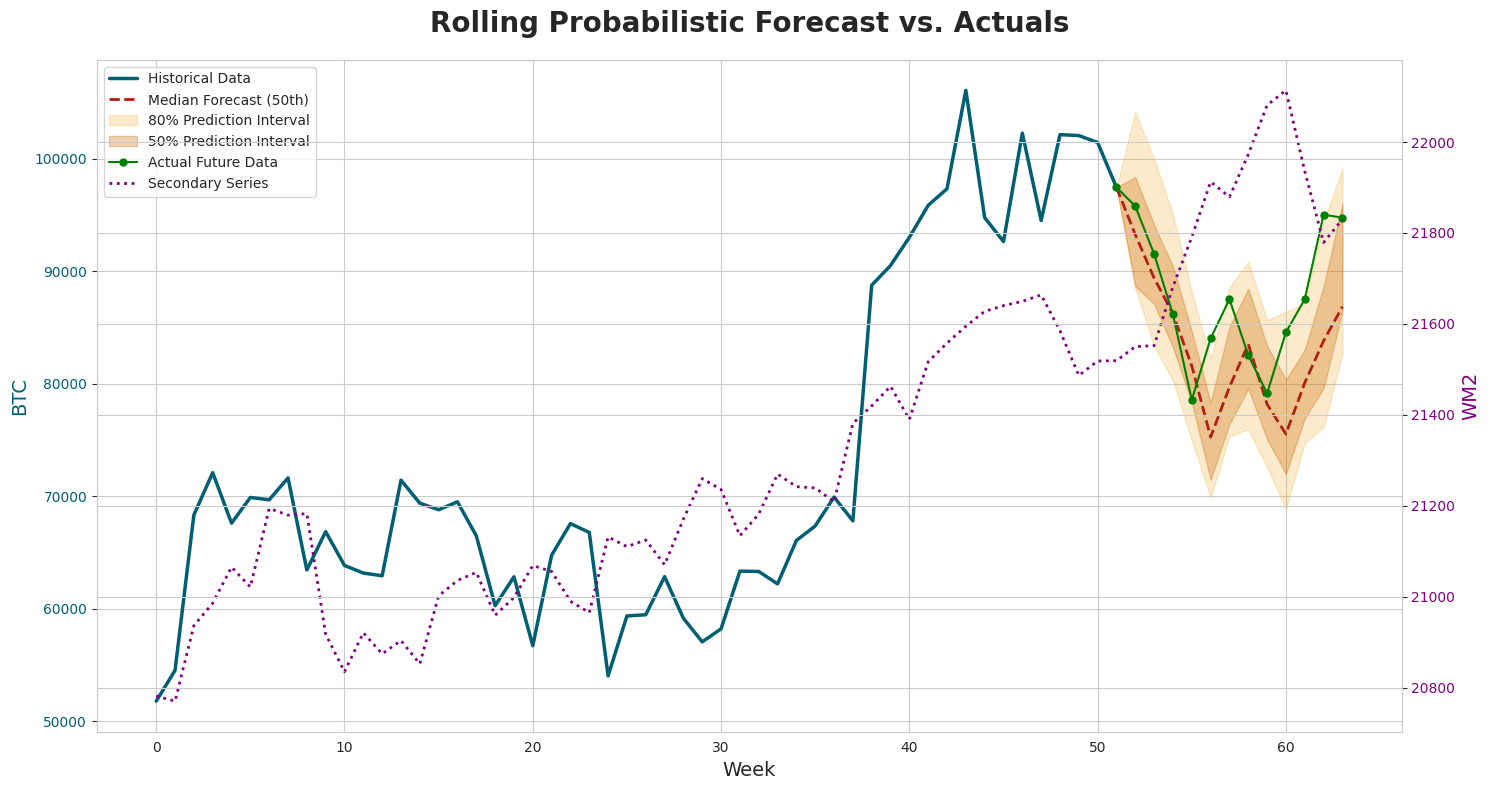

In [ ]:
plot_forecast(historical_data=np.array(b_series[-(lookback+horizon):(-horizon)]),
              forecast_trajectories=forecast,
              actual_future_data=np.array(b_series[-horizon:]),
              secondary_series=np.array(a_series[-(lookback+horizon):]),
              x_title='Week',
              y1_title='BTC',
              y2_title='WM2')

In [ ]:
file_path = path+'sapheneia/github/sapheneia/notebooks/marcelo/250721_interleaved_simulation_lag_0.npy'
np.save(file_path,distributions)

In [ ]:
x = np.load(file_path)
print(x)

[[0.83513 0.35002 0.84699 ... 0.20189 0.20093 0.33333]
 [0.19907 0.33333 0.43705 ... 0.50023 0.32069 0.1996 ]
 [0.5     0.59273 0.2018  ... 0.21143 0.41306 0.13588]
 ...
 [0.73224 0.20151 0.43075 ... 0.75883 0.49628 0.26896]
 [0.49627 0.10937 0.20181 ... 0.10397 0.44542 0.12345]
 [0.2013  0.20172 0.20173 ... 0.12456 0.2019  0.20151]]


# experiments (sapheneia_v1)

In [ ]:
# Define the grammar in GBNF format
# This grammar allows for a sequence of numbers (integers or decimals) separated by commas
# https://g.co/gemini/share/938d5c086f74
gbnf_grammar_str = r'''
root   ::= sequence
sequence ::= number ("," number)*
number ::= ("-")? ([0-9]+ | [0-9]+ "." [0-9]+)
'''
try:
    grammar = LlamaGrammar.from_string(gbnf_grammar_str)
    print("Strict grammar parsed successfully")
    print(grammar)
except Exception as e:
    print(f"Error parsing grammar: {e}")
    grammar = None

Strict grammar parsed successfully


## testing all quantized models

In [ ]:
# Define the prompt with number sequence
prompt = "1.0,2.1,3.3,4.2,5.7,"
#prompt = "1,2,3,4,5,"

In [ ]:
# Define parameters for running the model
# https://g.co/gemini/share/5e0aed5cf4b8
# https://g.co/gemini/share/8e15743e2cd6
# https://g.co/gemini/share/1dcee2a72019
parameters = {
    'max_tokens': 20, # Maximum number of output generated tokens
    'logprobs': 1000, # Number of output token-level log probabilities
    'grammar': grammar, # Valid grammar for output generation
    'temperature': 0.9 # Temperature calibrating the 'surprise of the output generation
}

In [ ]:
# Dictionary with all generators
generators = {
    'q2_k': generator_q2_k,
    'q4_k_m': generator_q4_k_m,
    'q6_k': generator_q6_k,
    'q8_0': generator_q8_0,
}

In [ ]:
# Generate output sequence and logprobs
def time_execution(generator, prompt, params):

    start_time = time.time()
    response = generator(prompt, **params)
    end_time = time.time()
    elapsed_time = end_time - start_time

    choice = response['choices'][0]
    text = choice['text']
    logprobs = choice['logprobs']

    return {'response': text,
            'logprobs': logprobs,
            'elapsed_time': elapsed_time}

In [ ]:
# Run results for all models in dict generators
results = {}
r = []
t = []

for key in generators:
    results[key] = {}
    print(f'### Running {key}')
    results[key] = time_execution(generators[key], prompt, parameters)
    s = results[key]['response']
    print(f'\tresponse = {s}')
    s = results[key]['logprobs']
    print(f'\tlogprobs = {s}')
    s = results[key]['elapsed_time']
    print(f'\telapsed_time = {s}')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
results['q8_0']['logprobs']['top_logprobs'][0]

{'6': np.float32(-0.25368243),
 '7': np.float32(-2.4792635),
 '5': np.float32(-3.5000985),
 '1': np.float32(-4.193024),
 '8': np.float32(-4.2830863),
 '4': np.float32(-4.7845225),
 ' ': np.float32(-4.873134),
 '2': np.float32(-5.091663),
 '\n': np.float32(-5.1550307),
 '3': np.float32(-5.209435),
 '9': np.float32(-5.6851115),
 '0': np.float32(-5.975576),
 ' and': np.float32(-6.0301027),
 ' etc': np.float32(-6.917441),
 '<': np.float32(-6.980359),
 'and': np.float32(-7.1213536),
 ' or': np.float32(-7.17541),
 'etc': np.float32(-7.205487),
 '...': np.float32(-7.3786025),
 ' ...': np.float32(-7.724187),
 '  ': np.float32(-7.7778745),
 ' .': np.float32(-7.806314),
 'max': np.float32(-7.841784),
 ' (': np.float32(-7.89041),
 'y': np.float32(-7.902519),
 ' A': np.float32(-8.017706),
 ' <': np.float32(-8.086822),
 'n': np.float32(-8.155408),
 'A': np.float32(-8.206924),
 'x': np.float32(-8.24764),
 'N': np.float32(-8.25274),
 'a': np.float32(-8.272391),
 ' -': np.float32(-8.278733),
 '*': np.

In [ ]:
results['q8_0']['response']

'7.2,8.7,10.2,12.2,14'

### save single token log-probabilities

In [ ]:
logprobs = results['q8_0']['logprobs']['top_logprobs'][0].copy()

In [ ]:
import json

file_path = '/content/drive/MyDrive/dev/sapheneia/github/sapheneia/notebooks/marcelo/generator_q8_0_logprobs.json'

In [ ]:
for key in logprobs:
    logprobs[key] = float(logprobs[key])

with open(file_path, 'w') as json_file:
    json.dump(logprobs, json_file, indent=4)

### save token sequence

In [ ]:
response = {}

for key in generators:
    response[key] = results[key]['response']

response

{'q2_k': '10.1,20.2,30.4,40.8,',
 'q4_k_m': '6.8,7.9,8.8,9.8,10.8',
 'q6_k': '7.2,8.8,10.5,12.1,14',
 'q8_0': '7.2,8.7,10.2,12.2,14'}

In [ ]:
import json

file_path = '/content/drive/MyDrive/dev/sapheneia/github/sapheneia/notebooks/marcelo/response_sequences.json'

In [ ]:
with open(file_path, 'w') as json_file:
    json.dump(response, json_file, indent=4)

## analysis of single token log-probabilities

In [ ]:
# Load sample logprobs for analysis
import json

file_path = '/content/drive/MyDrive/dev/sapheneia/github/sapheneia/notebooks/marcelo/generator_q8_0_logprobs.json'

logprobs = {}

try:
    with open(file_path, 'r') as json_file:
        logprobs = json.load(json_file)
    print(f"Dictionary loaded from {file_path}:")
    print(logprobs)
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found.")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {file_path}.")

Dictionary loaded from /content/drive/MyDrive/dev/sapheneia/github/sapheneia/notebooks/marcelo/generator_q8_0_logprobs.json:
{'6': -0.272904634475708, '7': -2.412665605545044, '5': -3.4727232456207275, '1': -4.10285758972168, '8': -4.194048881530762, '4': -4.7399492263793945, ' ': -4.851360321044922, '2': -5.01570987701416, '\n': -5.0478715896606445, '3': -5.1466779708862305, '9': -5.572190284729004, ' and': -5.918932914733887, '0': -5.939314842224121, ' etc': -6.749886512756348, '<': -7.024115562438965, 'and': -7.046576499938965, ' or': -7.070944786071777, 'etc': -7.102926254272461, '...': -7.291332244873047, ' ...': -7.644391059875488, '  ': -7.7795610427856445, 'max': -7.819403648376465, ' (': -7.824001312255859, ' .': -7.824521064758301, 'y': -7.828177452087402, ' A': -7.911307334899902, 'n': -8.026654243469238, ' <': -8.069267272949219, 'A': -8.102025032043457, 'a': -8.105005264282227, 'N': -8.14380931854248, ' -': -8.24870777130127, 'x': -8.262267112731934, '*': -8.35293865203857

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
logprobs

{'6': -0.272904634475708,
 '7': -2.412665605545044,
 '5': -3.4727232456207275,
 '1': -4.10285758972168,
 '8': -4.194048881530762,
 '4': -4.7399492263793945,
 ' ': -4.851360321044922,
 '2': -5.01570987701416,
 '\n': -5.0478715896606445,
 '3': -5.1466779708862305,
 '9': -5.572190284729004,
 ' and': -5.918932914733887,
 '0': -5.939314842224121,
 ' etc': -6.749886512756348,
 '<': -7.024115562438965,
 'and': -7.046576499938965,
 ' or': -7.070944786071777,
 'etc': -7.102926254272461,
 '...': -7.291332244873047,
 ' ...': -7.644391059875488,
 '  ': -7.7795610427856445,
 'max': -7.819403648376465,
 ' (': -7.824001312255859,
 ' .': -7.824521064758301,
 'y': -7.828177452087402,
 ' A': -7.911307334899902,
 'n': -8.026654243469238,
 ' <': -8.069267272949219,
 'A': -8.102025032043457,
 'a': -8.105005264282227,
 'N': -8.14380931854248,
 ' -': -8.24870777130127,
 'x': -8.262267112731934,
 '*': -8.352938652038574,
 ' &': -8.429669380187988,
 'or': -8.471209526062012,
 'min': -8.573104858398438,
 'in': 

In [ ]:
tokens = [',','.','-','0','1','2','3','4','5','6','7','8','9']

In [ ]:
distribution = pd.DataFrame(logprobs, index=['logprob']).T.reset_index()
distribution.columns = ['token','logprob']
k = distribution['token'].isin(tokens)
distribution = distribution[k].reset_index(drop=True)
distribution['prob'] = np.exp(distribution['logprob'])
distribution['prob'] = distribution['prob']/distribution['prob'].sum()

In [ ]:
distribution

,token,logprob,prob
0,6,-0.272905,0.808812
1,7,-2.412666,0.095183
2,5,-3.472723,0.032975
3,1,-4.102858,0.017560
4,8,-4.194049,0.016029
5,4,-4.739949,0.009286
6,2,-5.015710,0.007048
7,3,-5.146678,0.006183
8,9,-5.572190,0.004040
9,0,-5.939315,0.002799


## get float from token sequence

In [ ]:
import json

file_path = '/content/drive/MyDrive/dev/sapheneia/github/sapheneia/notebooks/marcelo/response_sequences.json'

token_sequences = {}

try:
    with open(file_path, 'r') as json_file:
        token_sequences = json.load(json_file)
    print(f"Dictionary loaded from {file_path}:")
    print(token_sequences)
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found.")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {file_path}.")

Dictionary loaded from /content/drive/MyDrive/dev/sapheneia/github/sapheneia/notebooks/marcelo/response_sequences.json:
{'q2_k': '10.1,20.2,30.4,40.8,', 'q4_k_m': '6.8,7.9,8.8,9.8,10.8', 'q6_k': '7.2,8.8,10.5,12.1,14', 'q8_0': '7.2,8.7,10.2,12.2,14'}


In [ ]:
def get_float_from_token_sequence(token_sequences):
    float_sequences = {}

    for key in token_sequences:
        float_sequences[key] = [float(x) for x in token_sequences[key].strip(',').split(',')]

    return float_sequences

In [ ]:
float_sequences = get_float_from_token_sequence(token_sequences)
float_sequences

{'q2_k': [10.1, 20.2, 30.4, 40.8],
 'q4_k_m': [6.8, 7.9, 8.8, 9.8, 10.8],
 'q6_k': [7.2, 8.8, 10.5, 12.1, 14.0],
 'q8_0': [7.2, 8.7, 10.2, 12.2, 14.0]}

## simulation

https://g.co/gemini/share/1c98cd1b5e97

In [ ]:
prompt = "1.0,2.1,3.3,4.2,5.7,5.0,6.1,5.5,7.0,"

In [ ]:
def run_monte_carlo_simulation(prompt, generator, grammar, num_simulations=100, temperature=0.7, max_tokens=10, print_step=50):
    """
    Runs N simulations to generate a distribution of the next predicted number.
    """
    if not grammar or not generator:
        print("Model or grammar not available.")
        return None

    print(f"\n--- Running {num_simulations} simulations with temperature={temperature} ---")

    generated_numbers = []

    for i in range(num_simulations):
        # Print progress every print_step simulations
        if (i + 1) % print_step == 0:
            print(f"  Running simulation {i + 1}/{num_simulations} ...")

        response = generator(
            prompt,
            max_tokens=max_tokens,
            temperature=temperature,
            grammar=grammar,
            stop=["\n", ","] # Stop after the first number is generated
        )

        generated_text = response['choices'][0]['text']

        # Use regex to find the first valid float/integer in the output
        match = re.search(r'-?\d+(\.\d+)?', generated_text)
        if match:
            try:
                # Convert the found number string to a float and add to our list
                num = float(match.group(0))
                generated_numbers.append(num)
            except ValueError:
                continue # Ignore if conversion fails for any reason

    return generated_numbers

In [ ]:
simulation_results = run_monte_carlo_simulation(
    prompt=prompt,
    generator=generator_q8_0,
    grammar=grammar,
    num_simulations=2000,
    temperature=0.9
)


--- Running 2000 simulations with temperature=0.9 ---
  Running simulation 50/2000...
  Running simulation 100/2000...
  Running simulation 150/2000...
  Running simulation 200/2000...
  Running simulation 250/2000...
  Running simulation 300/2000...
  Running simulation 350/2000...
  Running simulation 400/2000...
  Running simulation 450/2000...
  Running simulation 500/2000...
  Running simulation 550/2000...
  Running simulation 600/2000...
  Running simulation 650/2000...
  Running simulation 700/2000...
  Running simulation 750/2000...
  Running simulation 800/2000...
  Running simulation 850/2000...
  Running simulation 900/2000...
  Running simulation 950/2000...
  Running simulation 1000/2000...
  Running simulation 1050/2000...
  Running simulation 1100/2000...
  Running simulation 1150/2000...
  Running simulation 1200/2000...
  Running simulation 1250/2000...
  Running simulation 1300/2000...
  Running simulation 1350/2000...
  Running simulation 1400/2000...
  Running sim

In [ ]:
if simulation_results:
    # --- Analyze and Display the Distribution ---
    print("\n--- Simulation Results ---")

    # Count the occurrences of each unique number
    number_counts = Counter(simulation_results)

    total_samples = len(simulation_results)

    print(f"Generated {total_samples} valid numbers.")
    print("Top 10 most likely next numbers and their estimated probabilities:")

    # Sort by frequency and display the top 10
    for number, count in number_counts.most_common(10):
        probability = (count / total_samples) * 100
        print(f"  - Number: {number:<10} | Count: {count:<5} | Probability: {probability:.2f}%")


--- Simulation Results ---
Generated 2000 valid numbers.
Top 10 most likely next numbers and their estimated probabilities:
  - Number: 6.5        | Count: 209   | Probability: 10.45%
  - Number: 6.8        | Count: 127   | Probability: 6.35%
  - Number: 6.0        | Count: 120   | Probability: 6.00%
  - Number: 6.3        | Count: 105   | Probability: 5.25%
  - Number: 6.6        | Count: 103   | Probability: 5.15%
  - Number: 7.0        | Count: 99    | Probability: 4.95%
  - Number: 6.7        | Count: 95    | Probability: 4.75%
  - Number: 6.9        | Count: 91    | Probability: 4.55%
  - Number: 7.5        | Count: 89    | Probability: 4.45%
  - Number: 6.2        | Count: 81    | Probability: 4.05%


In [ ]:
# Calculate Statistics using NumPy ---
stats = {
    'mean': np.mean(simulation_results),
    'q10': np.quantile(simulation_results, 0.10),
    'q25': np.quantile(simulation_results, 0.25),
    'q50': np.quantile(simulation_results, 0.50), # Median
    'q75': np.quantile(simulation_results, 0.75),
    'q90': np.quantile(simulation_results, 0.90),
}

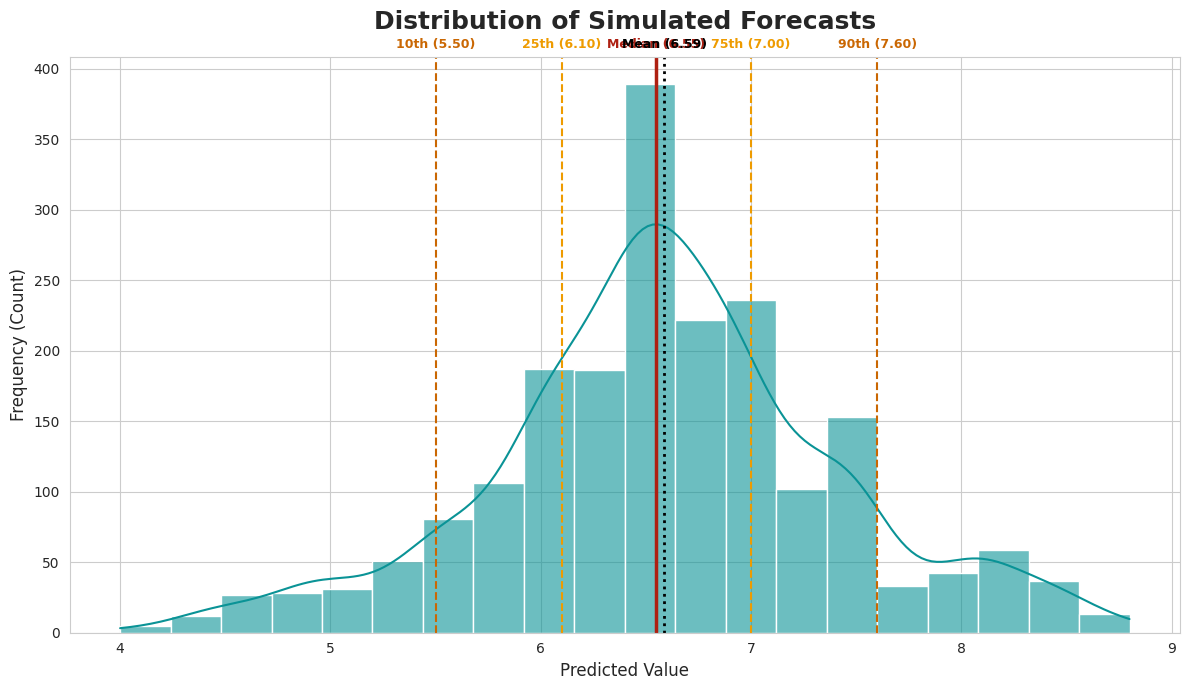


--- Calculated Statistics ---
Mean           : 6.588
Q10            : 5.500
Q25            : 6.100
Q50            : 6.550
Q75            : 7.000
Q90            : 7.600


In [ ]:
# Create the Plot ---
# Set a nice style for the plot
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

# Create the histogram using seaborn for better aesthetics
# `kde=True` adds a smooth line representing the kernel density estimate
ax = sns.histplot(simulation_results, bins=20, kde=True, color='#0a9396', alpha=0.6)

# Add Vertical Lines and Labels for Stats ---
# Define the lines to draw
lines_to_draw = [
    {'value': stats['q10'], 'label': f"10th ({stats['q10']:.2f})", 'color': '#ca6702', 'style': '--'},
    {'value': stats['q25'], 'label': f"25th ({stats['q25']:.2f})", 'color': '#ee9b00', 'style': '--'},
    {'value': stats['q50'], 'label': f"Median ({stats['q50']:.2f})", 'color': '#ae2012', 'style': '-', 'width': 2.5},
    {'value': stats['mean'], 'label': f"Mean ({stats['mean']:.2f})", 'color': '#000000', 'style': ':', 'width': 2},
    {'value': stats['q75'], 'label': f"75th ({stats['q75']:.2f})", 'color': '#ee9b00', 'style': '--'},
    {'value': stats['q90'], 'label': f"90th ({stats['q90']:.2f})", 'color': '#ca6702', 'style': '--'}
]

# Plot each line
for line in lines_to_draw:
    plt.axvline(
        x=line['value'],
        color=line['color'],
        linestyle=line['style'],
        linewidth=line.get('width', 1.5),
        label=line['label']
    )
    # Add text label slightly above the plot
    plt.text(line['value'], ax.get_ylim()[1] * 1.01, line['label'], color=line['color'], ha='center', va='bottom', fontsize=9, weight='bold')


# --- Final Touches (Labels, Title) ---
plt.title('Distribution of Simulated Forecasts', fontsize=18, weight='bold', pad=20)
plt.xlabel('Predicted Value', fontsize=12)
plt.ylabel('Frequency (Count)', fontsize=12)
plt.legend().set_visible(False) # Hide the default legend as we have text labels
plt.tight_layout()
plt.show()

# --- Print the stats for reference ---
print("\n--- Calculated Statistics ---")
for key, value in stats.items():
    print(f"{key.capitalize():<15}: {value:.3f}")

In [ ]:
# Historical data that will be used in the prompt
historical_data = [1.0,2.1,3.3,4.2,5.7,5.0,6.1,5.5,7.0]
prompt = ",".join(map(str, historical_data)) + ","
prompt

'1.0,2.1,3.3,4.2,5.7,5.0,6.1,5.5,7.0,'

In [ ]:
def simulate_future_trajectories(
    prompt_text,
    generator_model,
    grammar_obj,
    horizon=20,
    num_simulations=100,
    temperature=0.7
):
    """
    Runs N simulations to generate multiple full future trajectories.
    """
    if not grammar_obj or not generator_model:
        return None

    all_trajectories = []
    print(f"\n--- Running {num_simulations} simulations for a horizon of {horizon} steps ---")

    # Use tqdm for a progress bar
    for _ in tqdm(range(num_simulations), desc="Simulating Trajectories"):
        response = generator_model(
            prompt_text,
            max_tokens=horizon * 5, # Generate enough tokens to get `horizon` numbers
            temperature=temperature,
            grammar=grammar_obj,
            stop=["\n"]
        )

        generated_text = response['choices'][0]['text']

        # Find all numbers in the generated string
        numbers_str = re.findall(r'-?\d+\.\d+|-?\d+', generated_text)

        # Convert to float and take only up to the desired horizon
        trajectory = [float(n) for n in numbers_str[:horizon]]

        # Ensure the trajectory has the correct length by padding if necessary
        while len(trajectory) < horizon:
            trajectory.append(trajectory[-1]) # Simple padding with the last value

        all_trajectories.append(trajectory)

    return np.array(all_trajectories)


In [ ]:
# 1. Run the simulation to get the future trajectories
trajectories = simulate_future_trajectories(
    prompt_text=prompt,
    generator_model=generator_q8_0,
    grammar_obj=grammar,
    horizon=10,          # How many steps into the future to predict
    num_simulations=1000, # Number of different futures to generate
    temperature=0.9      # Controls the "width" of the cloud
)


--- Running 1000 simulations for a horizon of 10 steps ---


Simulating Trajectories: 100%|██████████| 1000/1000 [09:43<00:00,  1.71it/s]


In [ ]:
def plot_forecast_cloud(historical_data, forecast_trajectories):
    """
    Visualizes historical data and a cloud of forecasted trajectories,
    ensuring the forecast is connected to the historical data.
    """
    # --- Calculate Quantiles ---
    q10 = np.quantile(forecast_trajectories, 0.10, axis=0)
    q25 = np.quantile(forecast_trajectories, 0.25, axis=0)
    q50 = np.quantile(forecast_trajectories, 0.50, axis=0)
    q75 = np.quantile(forecast_trajectories, 0.75, axis=0)
    q90 = np.quantile(forecast_trajectories, 0.90, axis=0)

    # --- THE CRITICAL FIX IS HERE ---
    # Get the last point of the historical data to anchor the forecast
    last_hist_value = historical_data[-1]
    last_hist_time = len(historical_data) - 1

    # Prepend the last historical value to each forecast quantile series
    q10 = np.insert(q10, 0, last_hist_value)
    q25 = np.insert(q25, 0, last_hist_value)
    q50 = np.insert(q50, 0, last_hist_value)
    q75 = np.insert(q75, 0, last_hist_value)
    q90 = np.insert(q90, 0, last_hist_value)

    # Adjust the forecast time axis to start from the last historical point
    forecast_time = np.arange(last_hist_time, last_hist_time + len(q50))
    # --- END OF FIX ---

    # --- Create the Plot ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 8))

    # Define the historical time axis
    historical_time = np.arange(len(historical_data))

    # Plot historical data
    plt.plot(historical_time, historical_data, color='#005f73', label='Historical Data', linewidth=2.5, zorder=3)

    # Plot the median forecast (50th percentile)
    plt.plot(forecast_time, q50, color='#ae2012', linestyle='--', label='Median Forecast (50th)', linewidth=2, zorder=3)

    # Create the "Cloud" using fill_between
    plt.fill_between(forecast_time, q10, q90, color='#ee9b00', alpha=0.2, label='80% Prediction Interval', zorder=1)
    plt.fill_between(forecast_time, q25, q75, color='#ca6702', alpha=0.3, label='50% Prediction Interval', zorder=2)

    # --- Final Touches ---
    plt.title('Probabilistic Time Series Forecast', fontsize=20, weight='bold', pad=20)
    plt.xlabel('Time Steps', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

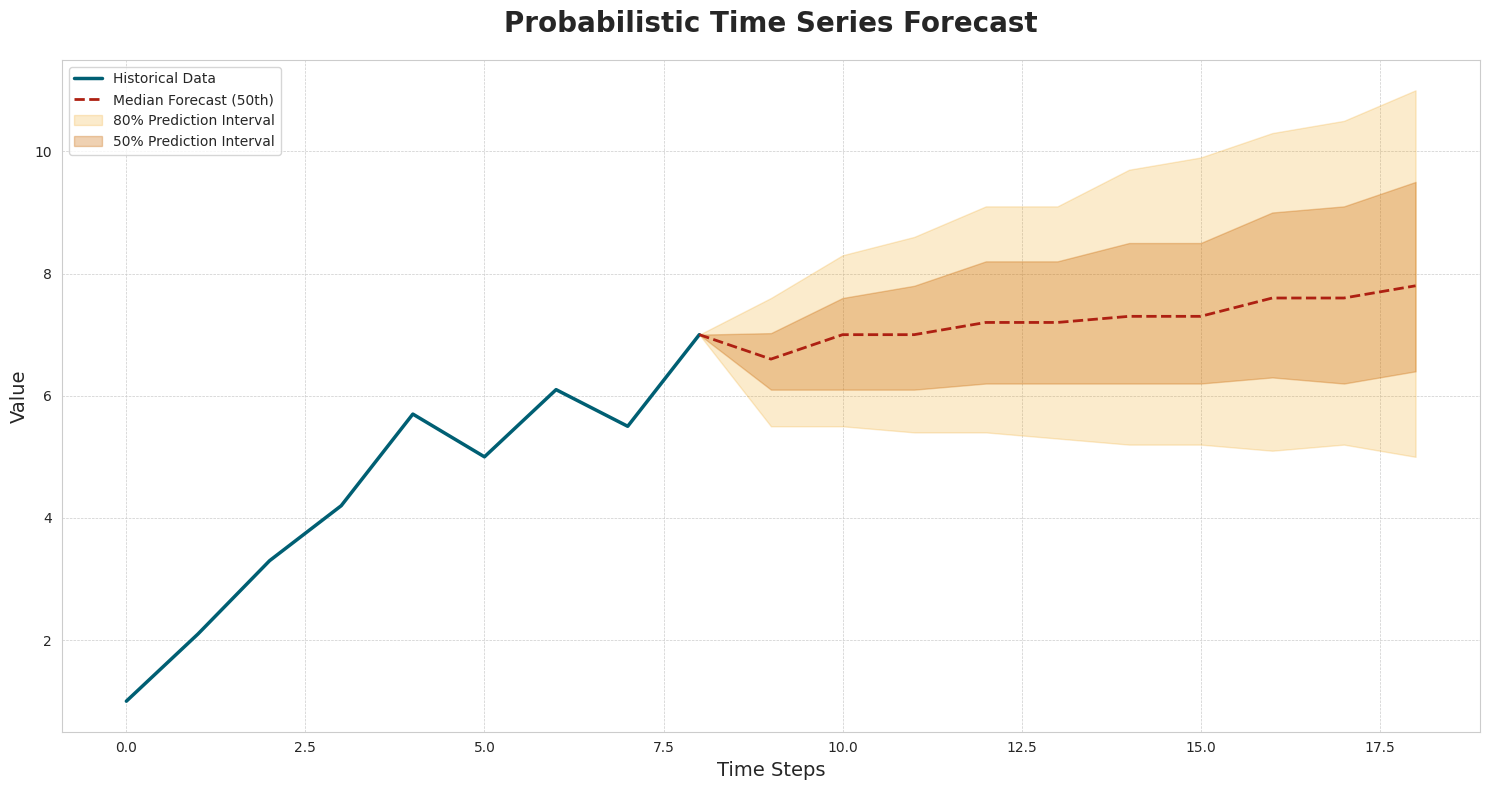

In [ ]:
if trajectories is not None:
    plot_forecast_cloud(historical_data, trajectories)

In [ ]:
trajectories[100]

array([5.9, 4.1, 5.5, 5.1, 5.1, 4.2, 4.2, 4.9, 4.7, 4. ])

In [ ]:
file_path = '/content/drive/MyDrive/dev/sapheneia/github/sapheneia/notebooks/marcelo/trajectories_simulation.npy'
np.save(file_path,trajectories)

In [ ]:
simulated_trajectories = np.load(file_path)
print(simulated_trajectories)

[[6.6 5.8 5.9 ... 3.9 3.9 3.7]
 [7.5 5.  6.2 ... 7.5 8.  5.2]
 [7.  6.1 6.7 ... 6.9 7.5 7.3]
 ...
 [6.5 7.4 6.8 ... 8.5 9.1 8.9]
 [7.2 7.1 7.4 ... 8.3 8.4 7.8]
 [7.  6.1 6.4 ... 4.2 5.  4.5]]


# time-series sequences with TinyLlama quantized models (sapheneia_v1)

### Introduction

- This action has been completed with the Notebook: https://github.com/labrem/sapheneia/blob/main/notebooks/marcelo/sapheneia_v1.ipynb.
- The following Gemini thread has been used to help build this up both conceptually and in practice: https://g.co/gemini/share/c5212fd78fad.
- This Notebook tests the capabilities of TinyLlama quantized models to generate raw token sequences given an input sequence.
- In order to speed up the model loading, the models have been stored in a local drive.

### Accomplishments

- With this Notebook we are able to achieve the following items.
    - Load and run a local drive instance of the TinyLlama model with different quantization levels (2-bit, 4-bit, 6-bit and 8-bit) on CPU as well as with GPU acceleration.
    - Compute the execution time for each model.
    - Check model behavior with different parameters such as:
    
    ```python
        parameters = {
        'max_tokens': 20, # Maximum number of output generated tokens
        'logprobs': 10, # Number of output token-level log probabilities
        'grammar': grammar, # Valid grammar for output generation
        'temperature': 0.9 # Temperature calibrating the 'surprise of the output generation
    }
    ```
    
    - Define a grammar such that it forces the model to output only certain to tokens such as numbers, period and comma.
    
    ```python
    gbnf_grammar_str = r'''
    root   ::= sequence
    sequence ::= number ("," number)*
    number ::= ("-")? ([0-9]+ | [0-9]+ "." [0-9]+)
    '''
    try:
        grammar = LlamaGrammar.from_string(gbnf_grammar_str)
        print("Strict grammar parsed successfully")
        print(grammar)
    except Exception as e:
        print(f"Error parsing grammar: {e}")
        grammar = None
    ```
    
    - Understand how to output generated token log probabilities. Note how in the log-probabilities for last number in the generated sequence below, where `1`, `2` and `.` appear as the highest probabilities to be sampled by the model. Also note how characters such as `\n` and `:` also show up in the top 10 probabilities, but is never selected in the generative process because it is not compliant with the established grammar.
    
    ```python
    prompt = "1.0,2.1,3.3,4.2,5.7,"
    ...
    ### Running q8_0
    	response = 6.7,7.6,8.9,10.4,12.
    ...
    ... {'1': np.float32(-0.110834435),
    '9': np.float32(-3.750521),
    '2': np.float32(-4.000365),
    '8': np.float32(-4.487987),
    '7': np.float32(-5.1254697),
    '0': np.float32(-5.1982684),
    '\n': np.float32(-5.263313),
    '6': np.float32(-5.366506),
    ' ': np.float32(-5.544479),
    '5': np.float32(-5.6029096)},
    {'2': np.float32(-0.5808073),
    '1': np.float32(-1.1937376),
    '3': np.float32(-2.658832),
    '0': np.float32(-3.187264),
    '4': np.float32(-4.535298),
    '5': np.float32(-5.0283246),
    '.': np.float32(-5.481704),
    '6': np.float32(-6.451225),
    '7': np.float32(-6.923182),
    '8': np.float32(-7.3887563)},
    {'.': np.float32(-0.03789382),
    ',': np.float32(-3.8787103),
    '\n': np.float32(-5.5151057),
    ' ': np.float32(-6.6268954),
    ':': np.float32(-7.178901),
    ')': np.float32(-7.3973727),
    '.,': np.float32(-7.824158),
    ']': np.float32(-7.8326225),
    '-': np.float32(-7.9419684),
    '+': np.float32(-8.018802)}]}
    ```

